# part 1

C:\Users\ReMarkt\AppData\Local\Temp\ipykernel_2688\3055159856.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  quad = float(e.T @ Sinv_e)
C:\Users\ReMarkt\AppData\Local\Temp\ipykernel_2688\3055159856.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  He = float(H.T @ Sinv_e)         # scalaire
C:\Users\ReMarkt\AppData\Local\Temp\ipykernel_2688\3055159856.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  HSH = float(H.T @ Sinv_H)        # scalaire


MLE success: True | CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
σ̂_e=0.03432 (true 0.04)
sigma_u_hat=1.01510 (true 1.0)
MSE(beta_hat, beta_true) = 0.014876


C:\Users\ReMarkt\AppData\Local\Temp\ipykernel_2688\3055159856.py:85: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  He = float(H.T @ Sinv_e)
C:\Users\ReMarkt\AppData\Local\Temp\ipykernel_2688\3055159856.py:89: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  HSH = float(H.T @ Sinv_H)


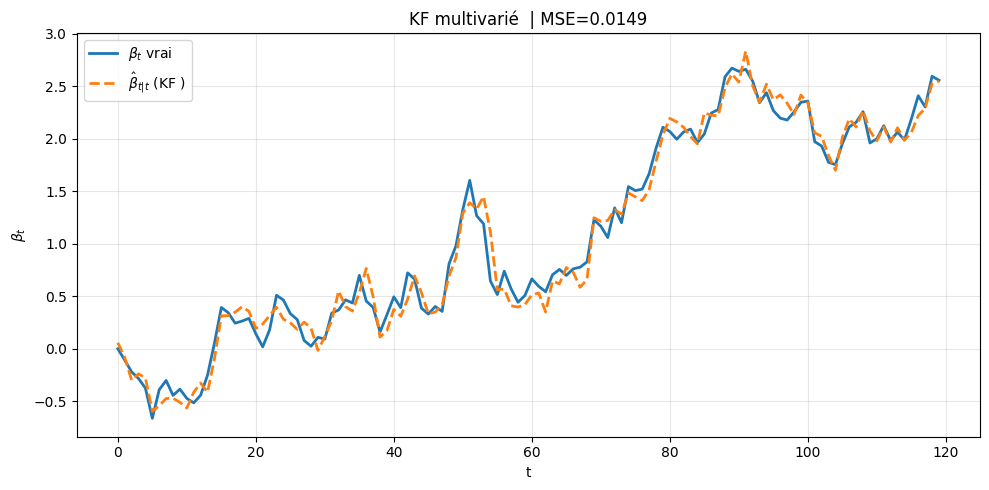

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ==========================================================
# 1) Kalman multivarié (obs vector y_t, état scalaire beta_t)
# ==========================================================

def kf_loglike_multivariate(Y_list, Q, su, beta0=0.0, P0=1e6):
    """
    Y_list: liste de vecteurs y_t (numpy array shape (N_t,))
    Modèle:
      beta_t = beta_{t-1} + xi_t,  xi_t ~ N(0,Q)
      y_t    = 1_{N_t} * beta_t + u_t, u_t ~ N(0, su^2 I_{N_t})

    Retour: log-vraisemblance (Kalman) multivariée
    """
    beta_pred = beta0
    P_pred = P0
    loglik = 0.0

    for y_t in Y_list:
        y_t = np.asarray(y_t)
        n = y_t.size

        H = np.ones((n, 1))              # (n x 1)
        R = (su**2) * np.eye(n)          # (n x n)

        # Innovation
        e = y_t.reshape(-1, 1) - H * beta_pred  # (n x 1)

        # S = H P H' + R  (n x n)
        S = P_pred * (H @ H.T) + R

        # log|S| + e' S^{-1} e
        sign, logdetS = np.linalg.slogdet(S)
        if sign <= 0:
            return -np.inf  # cas pathologique (devrait pas arriver si su>0)

        Sinv_e = np.linalg.solve(S, e)
        quad = float(e.T @ Sinv_e)

        loglik += -0.5 * (n * np.log(2*np.pi) + logdetS + quad)

        # Gain K = P H' S^{-1}   -> (1 x n)
        # beta_upd = beta_pred + K e
        # Ici, K e = P * H' * S^{-1} e
        He = float(H.T @ Sinv_e)         # scalaire
        beta_upd = beta_pred + P_pred * He

        # P_upd = P - P H' S^{-1} H P
        Sinv_H = np.linalg.solve(S, H)   # (n x 1)
        HSH = float(H.T @ Sinv_H)        # scalaire
        P_upd = P_pred - (P_pred**2) * HSH

        # Predict next
        beta_pred = beta_upd
        P_pred = P_upd + Q

    return loglik


def kf_filter_multivariate(Y_list, Q, su, beta0=0.0, P0=1e6):
    """
    Filtre KF multivarié -> renvoie beta_{t|t} et P_{t|t} pour t=1..T
    """
    T = len(Y_list)
    beta_filt = np.zeros(T)
    P_filt = np.zeros(T)

    beta_pred = beta0
    P_pred = P0

    for t, y_t in enumerate(Y_list):
        y_t = np.asarray(y_t)
        n = y_t.size

        H = np.ones((n, 1))
        R = (su**2) * np.eye(n)

        e = y_t.reshape(-1, 1) - H * beta_pred
        S = P_pred * (H @ H.T) + R

        Sinv_e = np.linalg.solve(S, e)
        He = float(H.T @ Sinv_e)
        beta_upd = beta_pred + P_pred * He

        Sinv_H = np.linalg.solve(S, H)
        HSH = float(H.T @ Sinv_H)
        P_upd = P_pred - (P_pred**2) * HSH

        beta_filt[t] = beta_upd
        P_filt[t] = P_upd

        beta_pred = beta_upd
        P_pred = P_upd + Q

    return beta_filt, P_filt


# ==========================================================
# 2) MLE (Q, sigma_u) via log-vraisemblance multivariée
# ==========================================================

def mle_multivariate_kf(Y_list, beta0=0.0, P0=1e6,
                        x0=(np.log(0.04), np.log(1.0))):
    """
    Estime directement :
        sigma_xi2 (variance d'état)
        sigma_v2  (variance observation)
    par MLE.

    Optimisation sur (log sigma_xi2, log sigma_v2)
    """

    def objective(params):
        log_sigma_xi2, log_sigma_v2 = params

        sigma_xi2 = np.exp(log_sigma_xi2)
        sigma_v2  = np.exp(log_sigma_v2)

        # su = sqrt(sigma_v2) car ton filtre prend l'écart-type
        su = np.sqrt(sigma_v2)

        ll = kf_loglike_multivariate(
            Y_list,
            Q=sigma_xi2,
            su=su,
            beta0=beta0,
            P0=P0
        )
        return -ll

    res = minimize(objective, np.array(x0), method="L-BFGS-B")

    log_sigma_xi2_hat, log_sigma_v2_hat = res.x

    return {
        "sigma_xi2_hat": float(np.exp(log_sigma_xi2_hat)),
        "sigma_v2_hat":  float(np.exp(log_sigma_v2_hat)),
        "success": bool(res.success),
        "message": res.message
    }


# ==========================================================
# 3) Exemple : simulation panel + estimation + filtre
# ==========================================================

if __name__ == "__main__":
    rng = np.random.default_rng(123)

    T = 120
    N_t = rng.integers(20, 61, size=T)  # panel potentiellement déséquilibré

    Q_true = 0.04
    su_true = 1.0

    # vrai beta_t (random walk)
    beta_true = np.zeros(T)
    for t in range(1, T):
        beta_true[t] = beta_true[t-1] + rng.normal(0, np.sqrt(Q_true))

    # données individuelles Y_it : y_t = beta_t * 1 + u_t
    Y_list = []
    for t in range(T):
        n = int(N_t[t])
        u_t = rng.normal(0, su_true, size=n)
        y_t = beta_true[t] + u_t
        Y_list.append(y_t)

    # MLE multivariée
    fit = mle_multivariate_kf(Y_list)
    print("MLE success:", fit["success"], "|", fit["message"])
    print(f"σ̂_e={fit['sigma_xi2_hat']:.5f} (true {Q_true})")
    print(f"sigma_u_hat={fit['sigma_v2_hat']:.5f} (true {su_true})")

    # Filtre KF multivarié
    beta_hat, P_hat = kf_filter_multivariate(
    Y_list,
    fit["sigma_xi2_hat"],
    np.sqrt(fit["sigma_v2_hat"])
)


    mse = np.mean((beta_hat - beta_true)**2)
    print(f"MSE(beta_hat, beta_true) = {mse:.6f}")

    # Graphe
    plt.figure(figsize=(10,5))
    plt.plot(beta_true, label=r"$\beta_t$ vrai", linewidth=2)
    plt.plot(beta_hat, "--", label=r"$\hat\beta_{t|t}$ (KF )", linewidth=2)
    plt.xlabel("t")
    plt.ylabel(r"$\beta_t$")
    plt.title(f"KF multivarié  | MSE={mse:.4f}")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [5]:
import numpy as np

def mc_bias_var_params(MC=200, T=120, Nmin=20, Nmax=60,
                       Q_true=0.04, su_true=1.0, seed=123):
    rng = np.random.default_rng(seed)

    Q_hats = []
    su_hats = []
    success = 0

    for _ in range(MC):
        N_t = rng.integers(Nmin, Nmax + 1, size=T)

        # beta vrai
        beta_true = np.zeros(T)
        for t in range(1, T):
            beta_true[t] = beta_true[t-1] + rng.normal(0, np.sqrt(Q_true))

        # panel Y_list
        Y_list = []
        for t in range(T):
            n = int(N_t[t])
            u_t = rng.normal(0, su_true, size=n)
            y_t = beta_true[t] + u_t
            Y_list.append(y_t)

        fit = mle_multivariate_kf(Y_list)
        if fit["success"]:
            success += 1
            Q_hats.append(fit["Q_hat"])
            su_hats.append(fit["sigma_u_hat"])

    Q_hats = np.array(Q_hats)
    su_hats = np.array(su_hats)

    # stats Monte Carlo
    out = {
        "MC_total": MC,
        "MC_success": success,
        "Q_mean": float(Q_hats.mean()),
        "Q_bias": float(Q_hats.mean() - Q_true),
        "Q_var": float(Q_hats.var(ddof=1)),
        "Q_mse": float(np.mean((Q_hats - Q_true)**2)),

        "su_mean": float(su_hats.mean()),
        "su_bias": float(su_hats.mean() - su_true),
        "su_var": float(su_hats.var(ddof=1)),
        "su_mse": float(np.mean((su_hats - su_true)**2)),
    }
    return out

# Exemple d'utilisation
stats = mc_bias_var_params(MC=200, T=120, Q_true=0.04, su_true=1.0)
print(stats)


C:\Users\ReMarkt\AppData\Local\Temp\ipykernel_2688\3897255935.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  quad = float(e.T @ Sinv_e)
C:\Users\ReMarkt\AppData\Local\Temp\ipykernel_2688\3897255935.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  He = float(H.T @ Sinv_e)         # scalaire
C:\Users\ReMarkt\AppData\Local\Temp\ipykernel_2688\3897255935.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  HSH = float(H.T @ Sinv_H)        # scalaire


{'MC_total': 200, 'MC_success': 200, 'Q_mean': 0.03912514771033329, 'Q_bias': -0.0008748522896667096, 'Q_var': 7.42046908053919e-05, 'Q_mse': 7.459903388010001e-05, 'su_mean': 0.9997618459988622, 'su_bias': -0.0002381540011378025, 'su_var': 0.00010367066797384962, 'su_mse': 0.0001032090319622383}


C:\Users\ReMarkt\AppData\Local\Temp\ipykernel_2688\264588608.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  quad = float(e.T @ Sinv_e)
C:\Users\ReMarkt\AppData\Local\Temp\ipykernel_2688\264588608.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  He = float(H.T @ Sinv_e)         # scalaire
C:\Users\ReMarkt\AppData\Local\Temp\ipykernel_2688\264588608.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  HSH = float(H.T @ Sinv_H)        # scalaire
C:\Users\ReM

MC success: 297/300


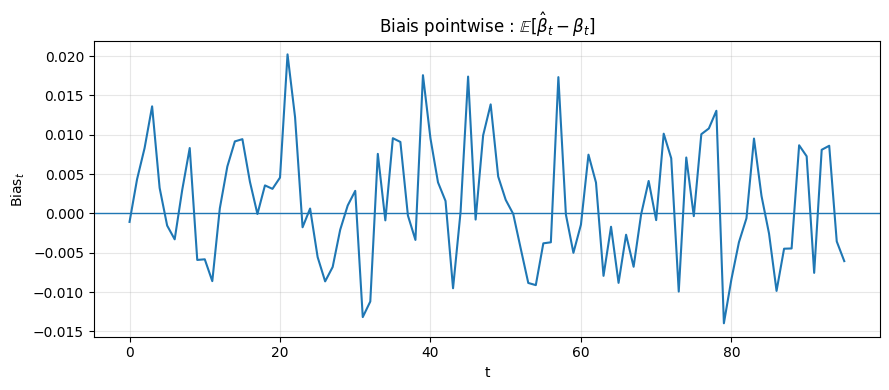

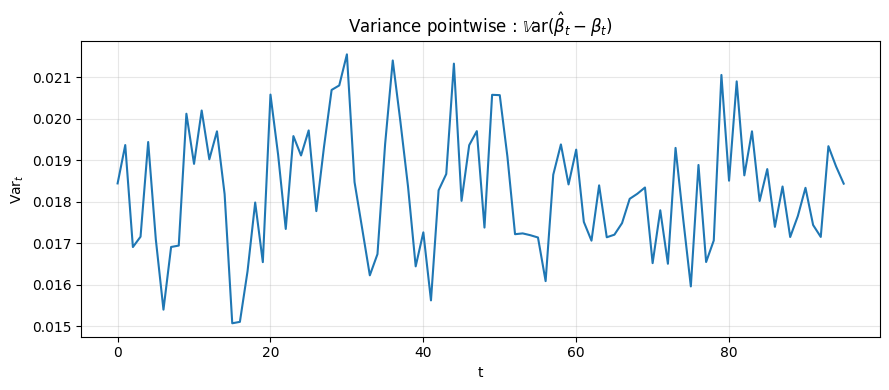

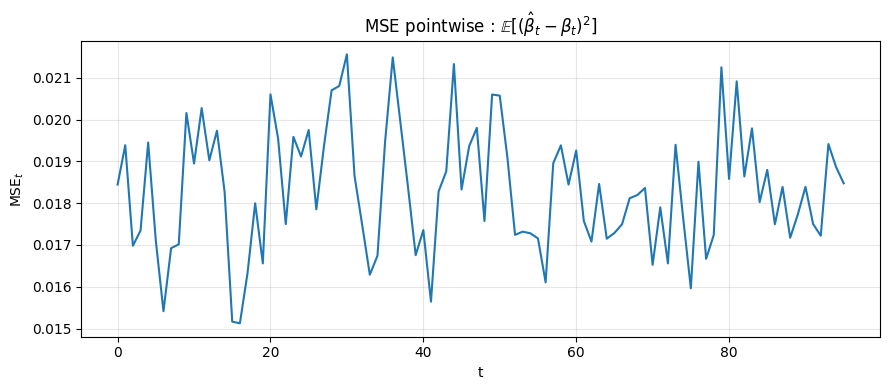

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_panel_list(T, Nmin, Nmax, sigma_xi2_true, sigma_v2_true, rng):
    N_t = rng.integers(Nmin, Nmax + 1, size=T)

    beta_true = np.zeros(T)
    for t in range(1, T):
        beta_true[t] = beta_true[t-1] + rng.normal(0.0, np.sqrt(sigma_xi2_true))

    Y_list = []
    for t in range(T):
        n = int(N_t[t])
        v = rng.normal(0.0, np.sqrt(sigma_v2_true), size=n)
        Y_list.append(beta_true[t] + v)

    return beta_true, Y_list


def mc_bias_var_beta(T=120, MC=300, Nmin=20, Nmax=60,
                     sigma_xi2_true=0.04, sigma_v2_true=1.0,
                     seed=123, burn_frac=0.0):
    rng = np.random.default_rng(seed)
    burn = int(burn_frac * T)

    # stocker les erreurs (MC x T)
    errors = np.zeros((MC, T))
    ok_count = 0

    for m in range(MC):
        beta_true, Y_list = simulate_panel_list(
            T, Nmin, Nmax, sigma_xi2_true, sigma_v2_true, rng
        )

        fit = mle_multivariate_kf(Y_list)   # doit retourner sigma_xi2_hat, sigma_v2_hat
        if not fit["success"]:
            # si ça rate, on saute cette réplication
            errors[m, :] = np.nan
            continue

        ok_count += 1
        xi2_hat = fit["sigma_xi2_hat"]
        v2_hat  = fit["sigma_v2_hat"]

        beta_hat, _ = kf_filter_multivariate(Y_list, Q=xi2_hat, su=np.sqrt(v2_hat))

        errors[m, :] = beta_hat - beta_true

    # garder seulement les runs OK
    errors_ok = errors[~np.isnan(errors).any(axis=1)]
    print(f"MC success: {errors_ok.shape[0]}/{MC}")

    # biais(t), variance(t), mse(t)
    bias_t = errors_ok.mean(axis=0)
    var_t  = errors_ok.var(axis=0, ddof=1)
    mse_t  = bias_t**2 + var_t

    # optionnel : enlever un burn-in pour l'affichage
    return bias_t[burn:], var_t[burn:], mse_t[burn:]


def plot_bias_var_mse(bias_t, var_t, mse_t):
    t = np.arange(len(bias_t))

    plt.figure(figsize=(9, 4))
    plt.plot(t, bias_t)
    plt.axhline(0.0, linewidth=1)
    plt.xlabel("t")
    plt.ylabel(r"$\mathrm{Bias}_t$")
    plt.title(r"Biais pointwise : $\mathbb{E}[\hat\beta_t-\beta_t]$")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(9, 4))
    plt.plot(t, var_t)
    plt.xlabel("t")
    plt.ylabel(r"$\mathrm{Var}_t$")
    plt.title(r"Variance pointwise : $\mathbb{V}\mathrm{ar}(\hat\beta_t-\beta_t)$")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(9, 4))
    plt.plot(t, mse_t)
    plt.xlabel("t")
    plt.ylabel(r"$\mathrm{MSE}_t$")
    plt.title(r"MSE pointwise : $\mathbb{E}[(\hat\beta_t-\beta_t)^2]$")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# ---------------- RUN ----------------
if __name__ == "__main__":
    bias_t, var_t, mse_t = mc_bias_var_beta(
        T=120, MC=300, Nmin=20, Nmax=60,
        sigma_xi2_true=0.04, sigma_v2_true=1.0,
        seed=123,
        burn_frac=0.2  # mets 0.0 si tu veux tout afficher
    )
    plot_bias_var_mse(bias_t, var_t, mse_t)


C:\Users\ReMarkt\AppData\Local\Temp\ipykernel_2688\759880188.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  quad = float(e.T @ Sinv_e)
C:\Users\ReMarkt\AppData\Local\Temp\ipykernel_2688\759880188.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  He = float(H.T @ Sinv_e)            # scalaire
C:\Users\ReMarkt\AppData\Local\Temp\ipykernel_2688\759880188.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  HSH = float(H.T @ Sinv_H)           # scalaire


MLE success: True | CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
sigma_xi2_hat=0.03432 (true 0.04)
sigma_v2_hat =1.01515 (true 1.0)
MSE(beta_hat, beta_true) = 0.014876


C:\Users\ReMarkt\AppData\Local\Temp\ipykernel_2688\759880188.py:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  He = float(H.T @ Sinv_e)
C:\Users\ReMarkt\AppData\Local\Temp\ipykernel_2688\759880188.py:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  HSH = float(H.T @ Sinv_H)


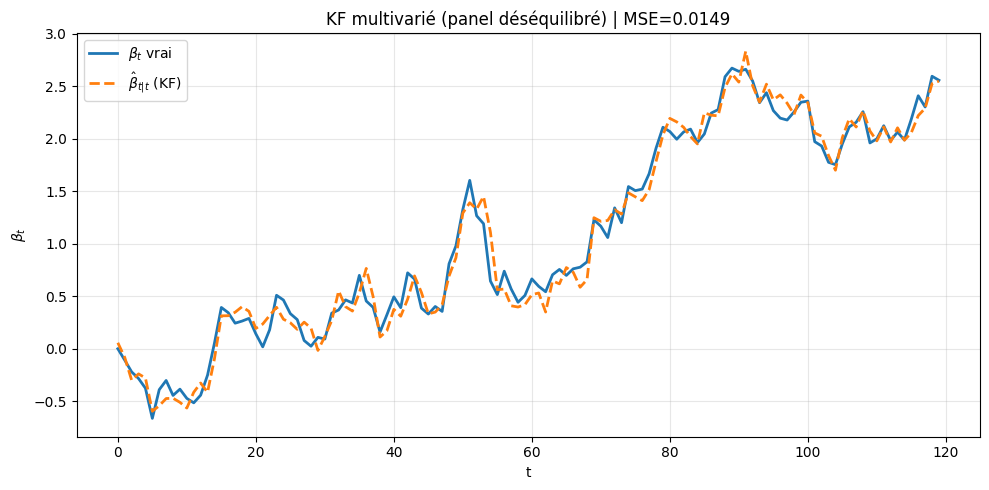

[MC beta] success: 296/300


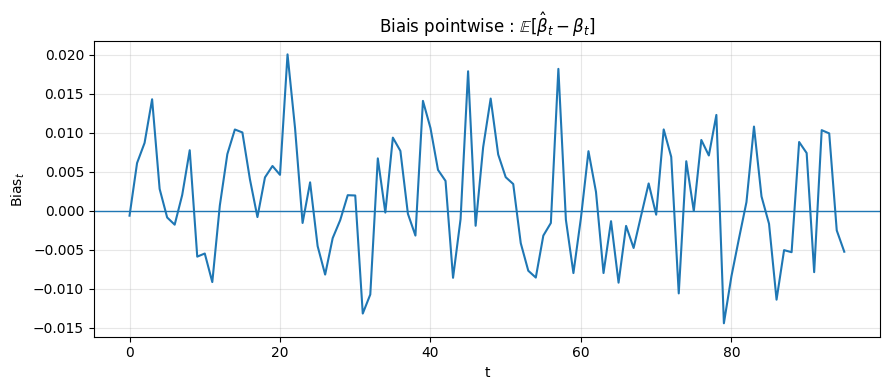

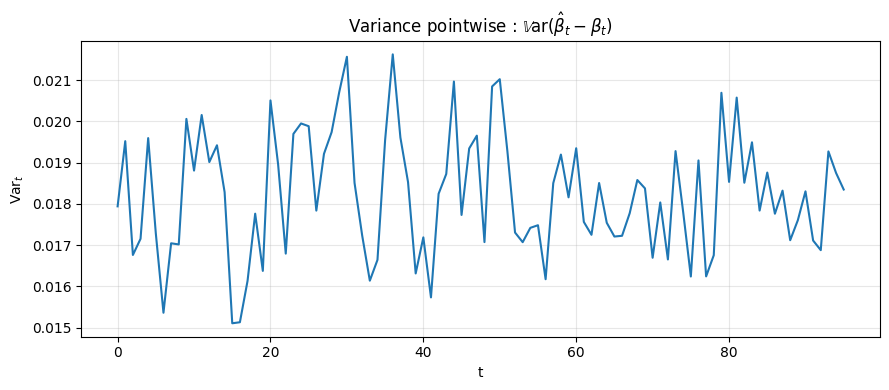

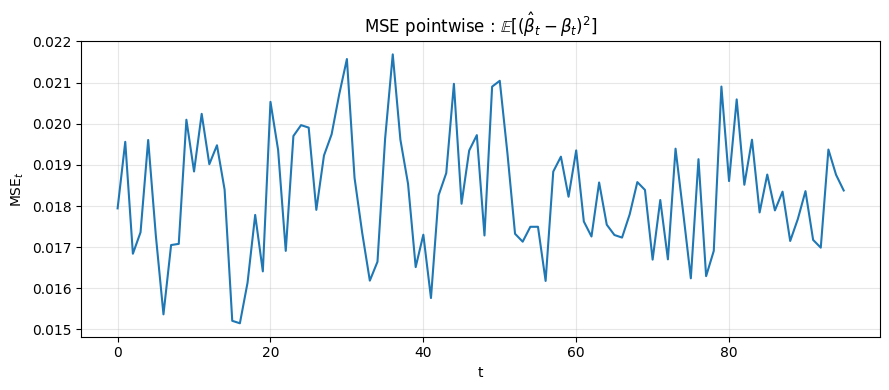

[MC params] success: 296/300

MC parameter stats:
MC_total: 300
MC_success: 296
sigma_xi2_mean: 0.03977286627682005
sigma_xi2_bias: -0.00022713372317995084
sigma_xi2_var: 7.551854971483132e-05
sigma_xi2_mse: 7.531500920751381e-05
sigma_v2_mean: 0.9998068619224346
sigma_v2_bias: -0.00019313807756538015
sigma_v2_var: 0.0004361489939281465
sigma_v2_mse: 0.0004347128199143138


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ==========================================================
# 1) KF multivarié (obs vector y_t, état scalaire beta_t)
#    Modèle:
#      beta_t = beta_{t-1} + xi_t,  xi_t ~ N(0, sigma_xi2)
#      y_t    = 1_{N_t} * beta_t + v_t, v_t ~ N(0, sigma_v2 I_{N_t})
# ==========================================================

def kf_loglike_multivariate(Y_list, sigma_xi2, sigma_v2, beta0=0.0, P0=1e6):
    """
    Log-vraisemblance KF (innovations), avec dimension N_t variable.
    sigma_xi2 = Var(xi_t)
    sigma_v2  = Var(v_it)
    """
    beta_pred = beta0
    P_pred = P0
    loglik = 0.0

    for y_t in Y_list:
        y_t = np.asarray(y_t)
        n = y_t.size

        H = np.ones((n, 1))                 # (n x 1)
        R = sigma_v2 * np.eye(n)            # (n x n)

        e = y_t.reshape(-1, 1) - H * beta_pred           # (n x 1)
        S = P_pred * (H @ H.T) + R                       # (n x n)

        sign, logdetS = np.linalg.slogdet(S)
        if sign <= 0:
            return -np.inf

        Sinv_e = np.linalg.solve(S, e)
        quad = float(e.T @ Sinv_e)

        loglik += -0.5 * (n * np.log(2*np.pi) + logdetS + quad)

        # update
        He = float(H.T @ Sinv_e)            # scalaire
        beta_upd = beta_pred + P_pred * He

        Sinv_H = np.linalg.solve(S, H)      # (n x 1)
        HSH = float(H.T @ Sinv_H)           # scalaire
        P_upd = P_pred - (P_pred**2) * HSH

        # predict next
        beta_pred = beta_upd
        P_pred = P_upd + sigma_xi2

    return loglik


def kf_filter_multivariate(Y_list, sigma_xi2, sigma_v2, beta0=0.0, P0=1e6):
    """
    Filtre KF multivarié -> renvoie beta_{t|t}, P_{t|t}.
    """
    T = len(Y_list)
    beta_filt = np.zeros(T)
    P_filt = np.zeros(T)

    beta_pred = beta0
    P_pred = P0

    for t, y_t in enumerate(Y_list):
        y_t = np.asarray(y_t)
        n = y_t.size

        H = np.ones((n, 1))
        R = sigma_v2 * np.eye(n)

        e = y_t.reshape(-1, 1) - H * beta_pred
        S = P_pred * (H @ H.T) + R

        Sinv_e = np.linalg.solve(S, e)
        He = float(H.T @ Sinv_e)
        beta_upd = beta_pred + P_pred * He

        Sinv_H = np.linalg.solve(S, H)
        HSH = float(H.T @ Sinv_H)
        P_upd = P_pred - (P_pred**2) * HSH

        beta_filt[t] = beta_upd
        P_filt[t] = P_upd

        beta_pred = beta_upd
        P_pred = P_upd + sigma_xi2

    return beta_filt, P_filt


# ==========================================================
# 2) MLE : estimer sigma_xi2 et sigma_v2
# ==========================================================

def mle_multivariate_kf(Y_list, beta0=0.0, P0=1e6, x0=(np.log(0.04), np.log(1.0))):
    """
    MLE sur (log sigma_xi2, log sigma_v2) pour garantir positivité.
    """
    def objective(params):
        log_sigma_xi2, log_sigma_v2 = params
        sigma_xi2 = np.exp(log_sigma_xi2)
        sigma_v2  = np.exp(log_sigma_v2)
        ll = kf_loglike_multivariate(Y_list, sigma_xi2, sigma_v2, beta0=beta0, P0=P0)
        return -ll

    res = minimize(objective, np.array(x0), method="L-BFGS-B")
    log_sigma_xi2_hat, log_sigma_v2_hat = res.x

    return {
        "sigma_xi2_hat": float(np.exp(log_sigma_xi2_hat)),
        "sigma_v2_hat":  float(np.exp(log_sigma_v2_hat)),
        "success": bool(res.success),
        "message": res.message
    }


# ==========================================================
# 3) Simulation utilitaire : panel déséquilibré
# ==========================================================

def simulate_panel_list(T, Nmin, Nmax, sigma_xi2_true, sigma_v2_true, rng):
    """
    Simule beta_true (RW) + Y_list (liste de vecteurs y_t de taille N_t variable).
    """
    N_t = rng.integers(Nmin, Nmax + 1, size=T)

    beta_true = np.zeros(T)
    for t in range(1, T):
        beta_true[t] = beta_true[t-1] + rng.normal(0.0, np.sqrt(sigma_xi2_true))

    Y_list = []
    for t in range(T):
        n = int(N_t[t])
        v = rng.normal(0.0, np.sqrt(sigma_v2_true), size=n)
        Y_list.append(beta_true[t] + v)

    return beta_true, Y_list, N_t


# ==========================================================
# 4) MC: biais(t), variance(t), MSE(t) de (beta_hat - beta_true)
# ==========================================================

def mc_bias_var_mse_beta(T=120, MC=300, Nmin=20, Nmax=60,
                         sigma_xi2_true=0.04, sigma_v2_true=1.0,
                         seed=123, burn_frac=0.0):
    rng = np.random.default_rng(seed)
    burn = int(burn_frac * T)

    errors = np.full((MC, T), np.nan)
    ok = 0

    for m in range(MC):
        beta_true, Y_list, _ = simulate_panel_list(T, Nmin, Nmax, sigma_xi2_true, sigma_v2_true, rng)

        fit = mle_multivariate_kf(Y_list)
        if not fit["success"]:
            continue

        ok += 1
        beta_hat, _ = kf_filter_multivariate(Y_list, fit["sigma_xi2_hat"], fit["sigma_v2_hat"])
        errors[m, :] = beta_hat - beta_true

    errors_ok = errors[~np.isnan(errors).any(axis=1)]
    print(f"[MC beta] success: {errors_ok.shape[0]}/{MC}")

    bias_t = errors_ok.mean(axis=0)
    var_t  = errors_ok.var(axis=0, ddof=1)
    mse_t  = bias_t**2 + var_t

    return bias_t[burn:], var_t[burn:], mse_t[burn:]


def plot_bias_var_mse(bias_t, var_t, mse_t):
    t = np.arange(len(bias_t))

    plt.figure(figsize=(9, 4))
    plt.plot(t, bias_t)
    plt.axhline(0.0, linewidth=1)
    plt.xlabel("t")
    plt.ylabel(r"$\mathrm{Bias}_t$")
    plt.title(r"Biais pointwise : $\mathbb{E}[\hat\beta_t-\beta_t]$")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(9, 4))
    plt.plot(t, var_t)
    plt.xlabel("t")
    plt.ylabel(r"$\mathrm{Var}_t$")
    plt.title(r"Variance pointwise : $\mathbb{V}\mathrm{ar}(\hat\beta_t-\beta_t)$")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(9, 4))
    plt.plot(t, mse_t)
    plt.xlabel("t")
    plt.ylabel(r"$\mathrm{MSE}_t$")
    plt.title(r"MSE pointwise : $\mathbb{E}[(\hat\beta_t-\beta_t)^2]$")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# ==========================================================
# 5) MC: biais/variance/MSE des paramètres estimés (sigma_xi2_hat, sigma_v2_hat)
# ==========================================================

def mc_bias_var_params(MC=300, T=120, Nmin=20, Nmax=60,
                       sigma_xi2_true=0.04, sigma_v2_true=1.0, seed=123):
    rng = np.random.default_rng(seed)

    xi2_hats = []
    v2_hats = []
    ok = 0

    for _ in range(MC):
        _, Y_list, _ = simulate_panel_list(T, Nmin, Nmax, sigma_xi2_true, sigma_v2_true, rng)

        fit = mle_multivariate_kf(Y_list)
        if not fit["success"]:
            continue

        ok += 1
        xi2_hats.append(fit["sigma_xi2_hat"])
        v2_hats.append(fit["sigma_v2_hat"])

    xi2_hats = np.array(xi2_hats)
    v2_hats  = np.array(v2_hats)

    print(f"[MC params] success: {ok}/{MC}")

    out = {
        "MC_total": MC,
        "MC_success": ok,

        "sigma_xi2_mean": float(xi2_hats.mean()),
        "sigma_xi2_bias": float(xi2_hats.mean() - sigma_xi2_true),
        "sigma_xi2_var":  float(xi2_hats.var(ddof=1)),
        "sigma_xi2_mse":  float(np.mean((xi2_hats - sigma_xi2_true)**2)),

        "sigma_v2_mean": float(v2_hats.mean()),
        "sigma_v2_bias": float(v2_hats.mean() - sigma_v2_true),
        "sigma_v2_var":  float(v2_hats.var(ddof=1)),
        "sigma_v2_mse":  float(np.mean((v2_hats - sigma_v2_true)**2)),
    }
    return out


# ==========================================================
# 6) Démo 1 simulation: beta vrai vs beta filtré + MSE
# ==========================================================

def demo_one_run(T=120, Nmin=20, Nmax=60, sigma_xi2_true=0.04, sigma_v2_true=1.0, seed=123):
    rng = np.random.default_rng(seed)
    beta_true, Y_list, N_t = simulate_panel_list(T, Nmin, Nmax, sigma_xi2_true, sigma_v2_true, rng)

    fit = mle_multivariate_kf(Y_list)
    print("MLE success:", fit["success"], "|", fit["message"])
    print(f"sigma_xi2_hat={fit['sigma_xi2_hat']:.5f} (true {sigma_xi2_true})")
    print(f"sigma_v2_hat ={fit['sigma_v2_hat']:.5f} (true {sigma_v2_true})")

    beta_hat, _ = kf_filter_multivariate(Y_list, fit["sigma_xi2_hat"], fit["sigma_v2_hat"])
    mse = float(np.mean((beta_hat - beta_true)**2))
    print(f"MSE(beta_hat, beta_true) = {mse:.6f}")

    plt.figure(figsize=(10, 5))
    plt.plot(beta_true, label=r"$\beta_t$ vrai", linewidth=2)
    plt.plot(beta_hat, "--", label=r"$\hat\beta_{t|t}$ (KF)", linewidth=2)
    plt.xlabel("t")
    plt.ylabel(r"$\beta_t$")
    plt.title(f"KF multivarié (panel déséquilibré) | MSE={mse:.4f}")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


# ==========================================================
# RUN (un seul script propre)
# ==========================================================

if __name__ == "__main__":
    # Paramètres "vrais"
    sigma_xi2_true = 0.04
    sigma_v2_true  = 1.0

    # (A) Une simulation : tracer beta vrai vs beta filtré
    demo_one_run(
        T=120, Nmin=20, Nmax=60,
        sigma_xi2_true=sigma_xi2_true,
        sigma_v2_true=sigma_v2_true,
        seed=123
    )

    # (B) Monte Carlo : biais(t), var(t), MSE(t) de (beta_hat - beta_true)
    bias_t, var_t, mse_t = mc_bias_var_mse_beta(
        T=120, MC=300, Nmin=20, Nmax=60,
        sigma_xi2_true=sigma_xi2_true,
        sigma_v2_true=sigma_v2_true,
        seed=123,
        burn_frac=0.2
    )
    plot_bias_var_mse(bias_t, var_t, mse_t)

    # (C) Monte Carlo : biais/variance/MSE des paramètres estimés
    stats = mc_bias_var_params(
        MC=300, T=120, Nmin=20, Nmax=60,
        sigma_xi2_true=sigma_xi2_true,
        sigma_v2_true=sigma_v2_true,
        seed=123
    )
    print("\nMC parameter stats:")
    for k, v in stats.items():
        print(f"{k}: {v}")


N: [5, 10, 20, 40, 60, 100, 120, 150, 200]
Bias: [-2.65576707e-04  4.22709534e-04  3.10800475e-05 -1.75743910e-04
  5.90875330e-04  3.33783454e-04  1.04593274e-04  2.61802090e-04
 -1.30839596e-04]
Var: [0.07184413 0.04620664 0.02917505 0.01739691 0.01264508 0.0083939
 0.00709067 0.00586757 0.00449847]
MSE: [0.07184375 0.04620653 0.02917487 0.01739684 0.01264535 0.00839396
 0.00709063 0.0058676  0.00449846]
sigma_xi2_hat: [0.03992284 0.0395579  0.03999686 0.04029373 0.04021967 0.040165
 0.03984629 0.03960191 0.03985836]
sigma_u2_hat: [1.00009191 0.99918299 0.99878946 0.9999754  0.99916755 0.99959979
 1.00024652 0.99967845 1.00022121]


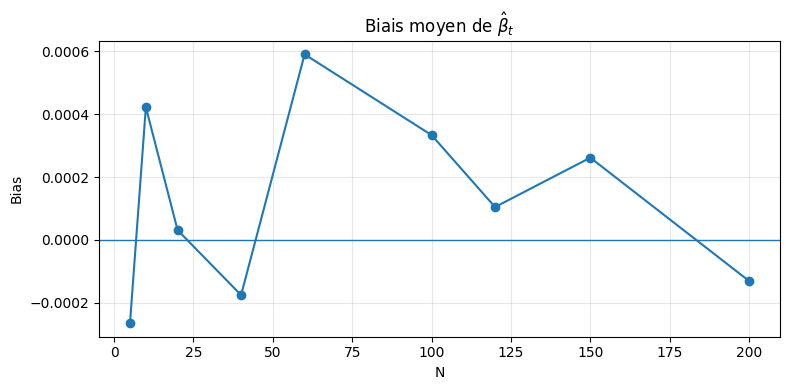

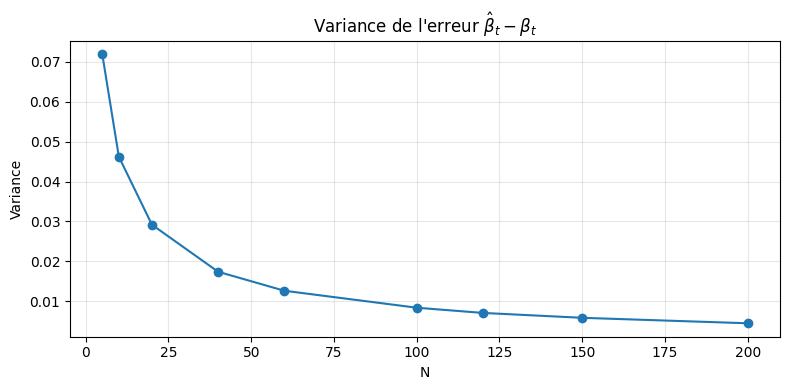

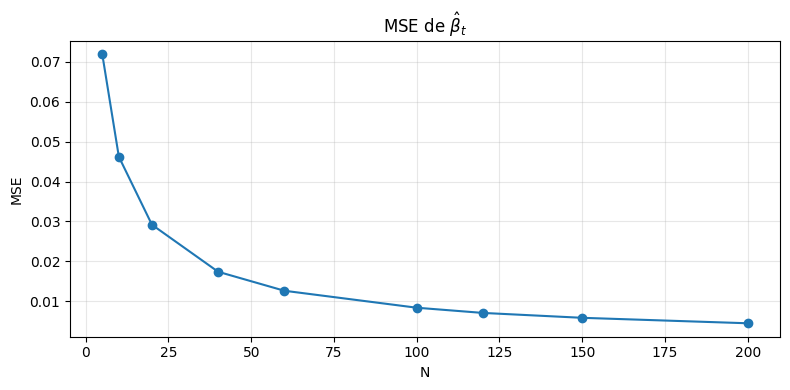

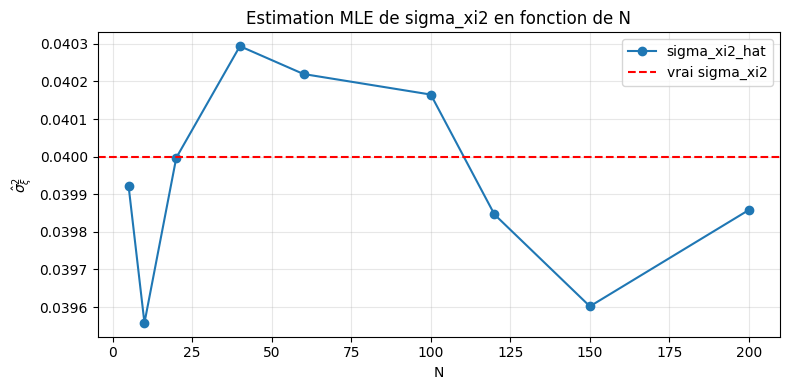

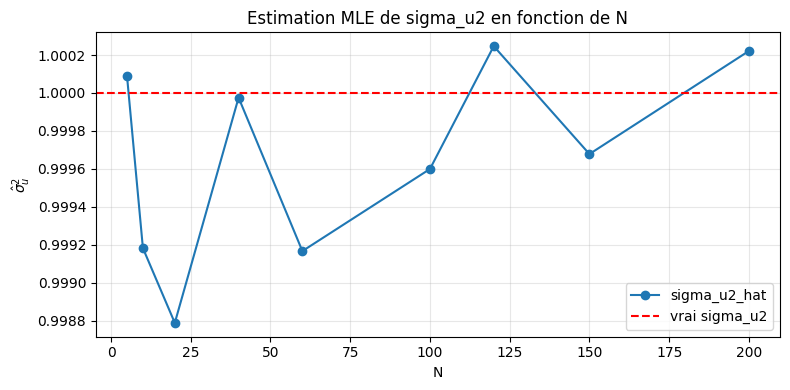

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# =========================================================
# KF multivarié (état scalaire)
# =========================================================
def kf_filter_multivariate(Y, sigma_xi2, sigma_u2, beta0=0.0, P0=1e6):
    """
    Filtre de Kalman multivarié pour :
      y_it = beta_t + u_it,   u_it ~ N(0, sigma_u2)
      beta_t = beta_{t-1} + xi_t,  xi_t ~ N(0, sigma_xi2)

    Y : array (T, N)
    """
    T, N = Y.shape
    beta_filt = np.zeros(T)
    P_filt = np.zeros(T)

    beta_pred = beta0
    P_pred = P0

    H = np.ones((N, 1))         # matrice de mesure
    R = sigma_u2 * np.eye(N)    # covariance observation

    for t in range(T):
        y_t = Y[t].reshape(-1, 1)

        # Innovation
        e_t = y_t - H * beta_pred
        S_t = (H @ H.T) * P_pred + R
        K_t = (P_pred * H.T) @ np.linalg.inv(S_t)  # (1xN)

        # Update
        beta_pred = beta_pred + (K_t @ e_t).item()
        P_pred = (1 - (K_t @ H).item()) * P_pred

        beta_filt[t] = beta_pred
        P_filt[t] = P_pred

        # Prediction
        P_pred = P_pred + sigma_xi2

    return beta_filt, P_filt


# =========================================================
# Log-vraisemblance (innovations) - formule fermée panel
# (équivalente au KF multivarié, mais plus stable pour MLE)
# =========================================================
def kf_loglike_panel(Y, sigma_xi2, sigma_u2, beta0=0.0, P0=1e6):
    """
    Log-vraisemblance via innovations pour le modèle :
      y_t = 1_N * beta_t + u_t,  u_t ~ N(0, sigma_u2 I_N)
      beta_t = beta_{t-1} + xi_t, xi_t ~ N(0, sigma_xi2)

    Fermé car S_t = sigma_u2 I + P 11'
    """
    T, N = Y.shape
    b = beta0
    P = P0
    ll = 0.0
    const = -0.5 * N * np.log(2 * np.pi)

    for t in range(T):
        y = Y[t]
        e = y - b
        one_e = e.sum()
        ee = float(e @ e)

        # log det(S_t)
        logdetS = (N - 1) * np.log(sigma_u2) + np.log(sigma_u2 + N * P)

        # e' S^{-1} e  (Woodbury)
        quad = (ee / sigma_u2) - (P / (sigma_u2 * (sigma_u2 + N * P))) * (one_e ** 2)

        ll += const - 0.5 * (logdetS + quad)

        # update
        b = b + P * one_e / (sigma_u2 + N * P)
        P = P * sigma_u2 / (sigma_u2 + N * P)

        # predict
        P = P + sigma_xi2

    return ll


def mle_params_panel(Y, beta0=0.0, P0=1e6):
    """
    MLE de (sigma_xi2, sigma_u2) en optimisant sur log-variances.
    """
    def objective(theta):
        sx2 = np.exp(theta[0])
        su2 = np.exp(theta[1])
        return -kf_loglike_panel(Y, sx2, su2, beta0=beta0, P0=P0)

    x0 = np.log([0.04, 1.0])
    res = minimize(objective, x0, method="L-BFGS-B")
    sx2_hat = float(np.exp(res.x[0]))
    su2_hat = float(np.exp(res.x[1]))
    return sx2_hat, su2_hat, res.success


# =========================================================
# Simulation + MC
# =========================================================
def simulate_panel(T, N, sigma_xi2, sigma_u2, rng):
    beta = np.zeros(T)
    for t in range(1, T):
        beta[t] = beta[t-1] + rng.normal(0, np.sqrt(sigma_xi2))

    U = rng.normal(0, np.sqrt(sigma_u2), size=(T, N))
    Y = beta[:, None] + U
    return beta, Y


def mc_full_results_multivariate_with_mle(list_N, T, MC,
                                          sigma_xi2_true, sigma_u2_true,
                                          seed=123, beta0=0.0, P0=1e6,
                                          burn_frac=0.2):

    rng = np.random.default_rng(seed)
    burn = int(burn_frac * T)

    bias_list = []
    var_list = []
    mse_list = []

    sigma_xi2_mean_list = []
    sigma_u2_mean_list = []

    for N in list_N:

        all_errors = []
        xi2_hats = []
        u2_hats = []

        for _ in range(MC):
            beta_true, Y = simulate_panel(T, N, sigma_xi2_true, sigma_u2_true, rng)

            sx2_hat, su2_hat, ok = mle_params_panel(Y, beta0=beta0, P0=P0)
            if not ok:
                continue

            xi2_hats.append(sx2_hat)
            u2_hats.append(su2_hat)

            beta_hat, _ = kf_filter_multivariate(
                Y, sx2_hat, su2_hat, beta0=beta0, P0=P0
            )

            errors = beta_hat[burn:] - beta_true[burn:]
            all_errors.extend(errors)

        all_errors = np.array(all_errors)

        bias_list.append(np.mean(all_errors))
        var_list.append(np.var(all_errors, ddof=1))
        mse_list.append(np.mean(all_errors**2))

        sigma_xi2_mean_list.append(np.mean(xi2_hats))
        sigma_u2_mean_list.append(np.mean(u2_hats))

    return (np.array(bias_list),
            np.array(var_list),
            np.array(mse_list),
            np.array(sigma_xi2_mean_list),
            np.array(sigma_u2_mean_list))

# =========================================================
# RUN
# =========================================================
if __name__ == "__main__":

    list_N = [5, 10, 20, 40, 60, 100, 120, 150, 200]
    T = 100
    MC = 2000

    (bias_N, var_N, mse_N,
     sigma_xi2_hat_N,
     sigma_u2_hat_N) = mc_full_results_multivariate_with_mle(
        list_N=list_N,
        T=T,
        MC=MC,
        sigma_xi2_true=0.04,
        sigma_u2_true=1.0
    )

    print("N:", list_N)
    print("Bias:", bias_N)
    print("Var:", var_N)
    print("MSE:", mse_N)
    print("sigma_xi2_hat:", sigma_xi2_hat_N)
    print("sigma_u2_hat:", sigma_u2_hat_N)
    # --------- Graphes ---------

    plt.figure(figsize=(8,4))
    plt.plot(list_N, bias_N, marker="o")
    plt.axhline(0, linewidth=1)
    plt.xlabel("N")
    plt.ylabel("Bias")
    plt.title("Biais moyen de $\hat{\\beta}_t$")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(list_N, var_N, marker="o")
    plt.xlabel("N")
    plt.ylabel("Variance")
    plt.title("Variance de l'erreur $\hat{\\beta}_t - \\beta_t$")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(list_N, mse_N, marker="o")
    plt.xlabel("N")
    plt.ylabel("MSE")
    plt.title("MSE de $\hat{\\beta}_t$")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

        # --------- Paramètres estimés ---------

    plt.figure(figsize=(8,4))
    plt.plot(list_N, sigma_xi2_hat_N, marker="o", label="sigma_xi2_hat")
    plt.axhline(0.04, color="r", linestyle="--", label="vrai sigma_xi2")
    plt.xlabel("N")
    plt.ylabel(r"$\hat{\sigma}_\xi^2$")
    plt.title("Estimation MLE de sigma_xi2 en fonction de N")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(list_N, sigma_u2_hat_N, marker="o", label="sigma_u2_hat")
    plt.axhline(1.0, color="r", linestyle="--", label="vrai sigma_u2")
    plt.xlabel("N")
    plt.ylabel(r"$\hat{\sigma}_u^2$")
    plt.title("Estimation MLE de sigma_u2 en fonction de N")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

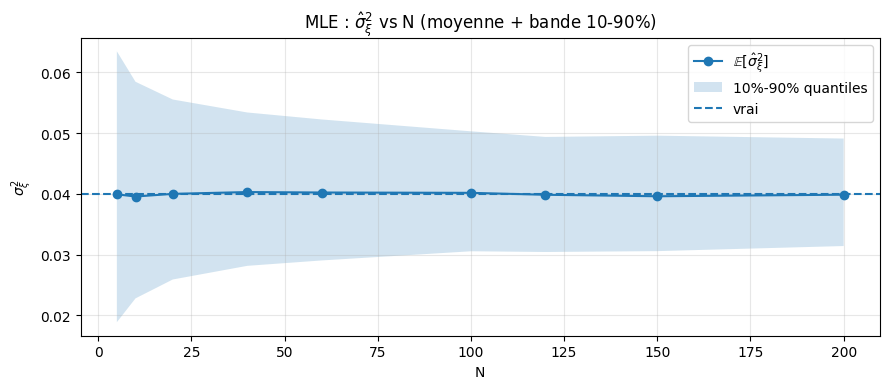

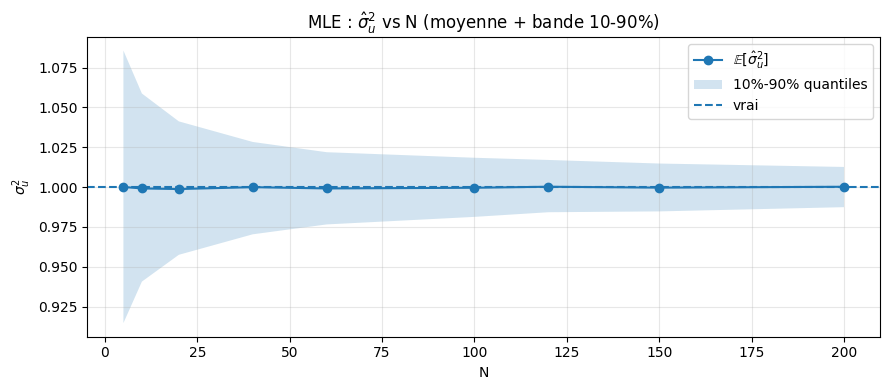

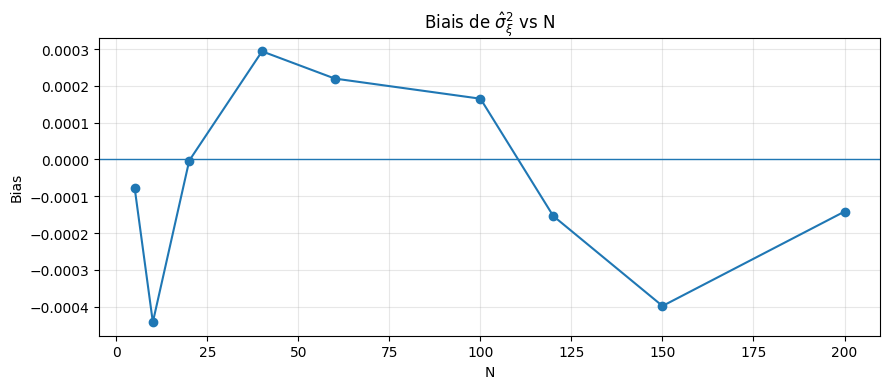

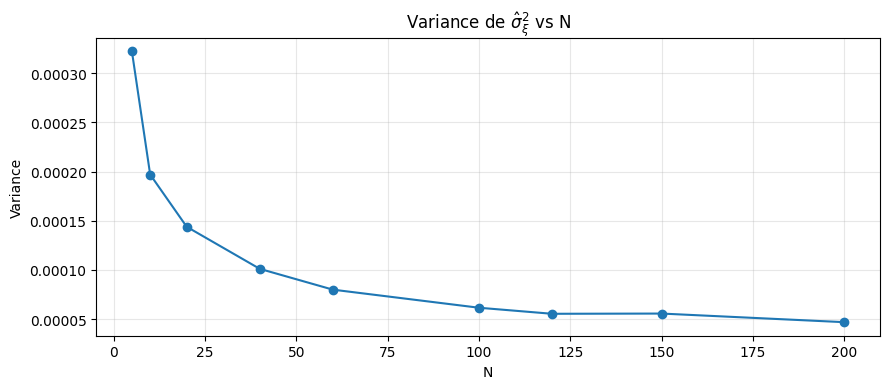

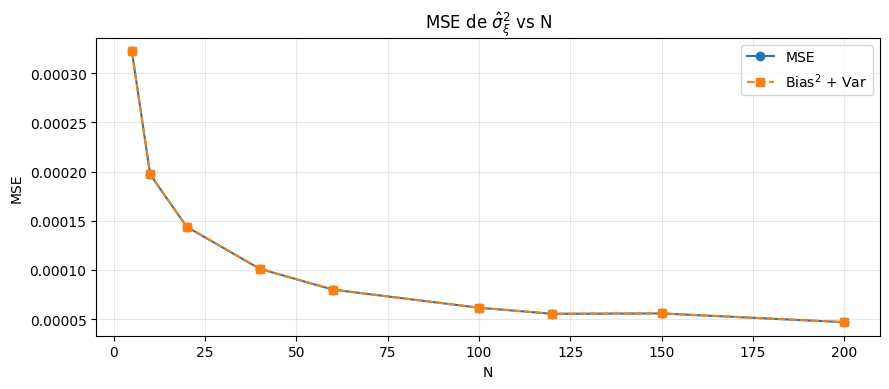

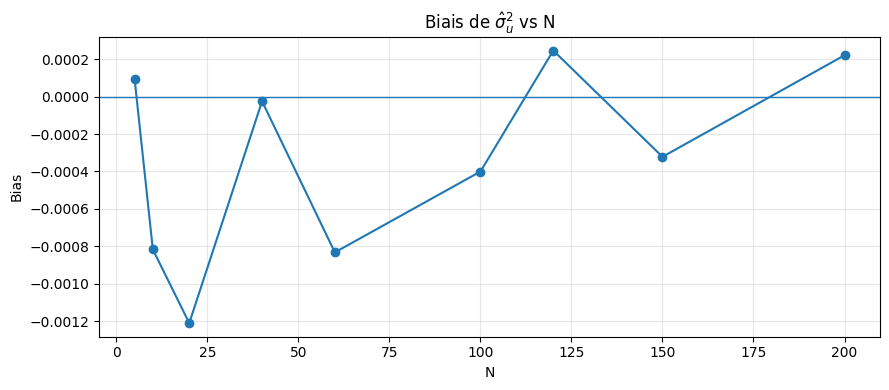

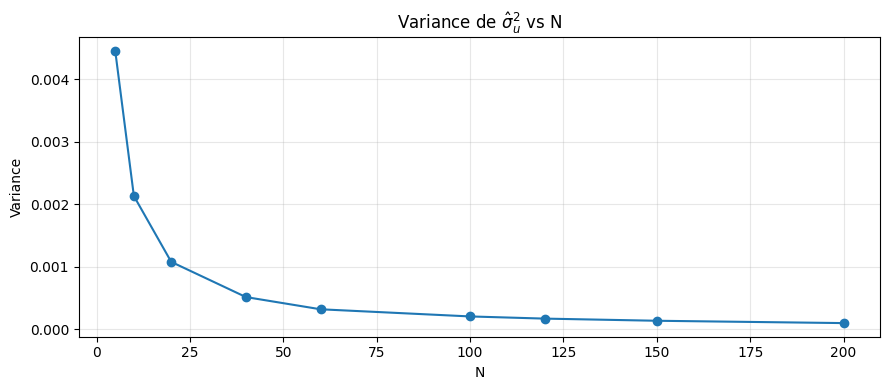

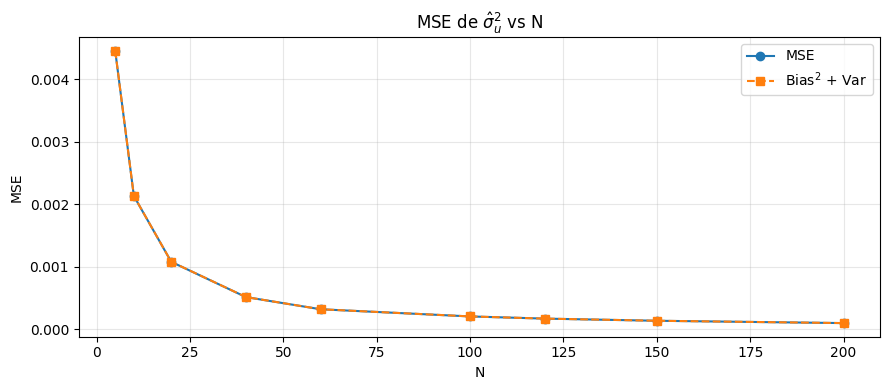

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def mc_params_stats_vs_N(list_N, T, MC,
                         sigma_xi2_true, sigma_u2_true,
                         seed=123, beta0=0.0, P0=1e6):

    rng = np.random.default_rng(seed)

    # sorties par N
    xi2_mean = []
    xi2_bias = []
    xi2_var  = []
    xi2_mse  = []
    xi2_q10  = []
    xi2_q90  = []

    u2_mean = []
    u2_bias = []
    u2_var  = []
    u2_mse  = []
    u2_q10  = []
    u2_q90  = []

    success_rate = []

    for N in list_N:
        xi2_hats = []
        u2_hats  = []
        ok = 0

        for _ in range(MC):
            _, Y = simulate_panel(T, N, sigma_xi2_true, sigma_u2_true, rng)
            sx2_hat, su2_hat, success = mle_params_panel(Y, beta0=beta0, P0=P0)
            if not success:
                continue
            ok += 1
            xi2_hats.append(sx2_hat)
            u2_hats.append(su2_hat)

        xi2_hats = np.array(xi2_hats)
        u2_hats  = np.array(u2_hats)

        success_rate.append(ok / MC)

        # --- sigma_xi^2 stats ---
        m_xi2 = xi2_hats.mean()
        b_xi2 = m_xi2 - sigma_xi2_true
        v_xi2 = xi2_hats.var(ddof=1)
        mse_xi2 = np.mean((xi2_hats - sigma_xi2_true)**2)

        xi2_mean.append(m_xi2)
        xi2_bias.append(b_xi2)
        xi2_var.append(v_xi2)
        xi2_mse.append(mse_xi2)
        xi2_q10.append(np.quantile(xi2_hats, 0.10))
        xi2_q90.append(np.quantile(xi2_hats, 0.90))

        # --- sigma_u^2 stats ---
        m_u2 = u2_hats.mean()
        b_u2 = m_u2 - sigma_u2_true
        v_u2 = u2_hats.var(ddof=1)
        mse_u2 = np.mean((u2_hats - sigma_u2_true)**2)

        u2_mean.append(m_u2)
        u2_bias.append(b_u2)
        u2_var.append(v_u2)
        u2_mse.append(mse_u2)
        u2_q10.append(np.quantile(u2_hats, 0.10))
        u2_q90.append(np.quantile(u2_hats, 0.90))

    return {
        "N": np.array(list_N),
        "xi2_mean": np.array(xi2_mean),
        "xi2_bias": np.array(xi2_bias),
        "xi2_var":  np.array(xi2_var),
        "xi2_mse":  np.array(xi2_mse),
        "xi2_q10":  np.array(xi2_q10),
        "xi2_q90":  np.array(xi2_q90),

        "u2_mean": np.array(u2_mean),
        "u2_bias": np.array(u2_bias),
        "u2_var":  np.array(u2_var),
        "u2_mse":  np.array(u2_mse),
        "u2_q10":  np.array(u2_q10),
        "u2_q90":  np.array(u2_q90),

        "success_rate": np.array(success_rate)
    }


def plot_param_stats_vs_N(stats, sigma_xi2_true, sigma_u2_true):
    N = stats["N"]

    # --- Means with quantile bands ---
    plt.figure(figsize=(9,4))
    plt.plot(N, stats["xi2_mean"], marker="o", label=r"$\mathbb{E}[\hat\sigma_\xi^2]$")
    plt.fill_between(N, stats["xi2_q10"], stats["xi2_q90"], alpha=0.2, label="10%-90% quantiles")
    plt.axhline(sigma_xi2_true, linestyle="--", label="vrai")
    plt.xlabel("N")
    plt.ylabel(r"$\sigma_\xi^2$")
    plt.title(r"MLE : $\hat\sigma_\xi^2$ vs N (moyenne + bande 10-90%)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(9,4))
    plt.plot(N, stats["u2_mean"], marker="o", label=r"$\mathbb{E}[\hat\sigma_u^2]$")
    plt.fill_between(N, stats["u2_q10"], stats["u2_q90"], alpha=0.2, label="10%-90% quantiles")
    plt.axhline(sigma_u2_true, linestyle="--", label="vrai")
    plt.xlabel("N")
    plt.ylabel(r"$\sigma_u^2$")
    plt.title(r"MLE : $\hat\sigma_u^2$ vs N (moyenne + bande 10-90%)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Bias / Var / MSE ---
    plt.figure(figsize=(9,4))
    plt.plot(N, stats["xi2_bias"], marker="o")
    plt.axhline(0, linewidth=1)
    plt.xlabel("N")
    plt.ylabel("Bias")
    plt.title(r"Biais de $\hat\sigma_\xi^2$ vs N")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(9,4))
    plt.plot(N, stats["xi2_var"], marker="o")
    plt.xlabel("N")
    plt.ylabel("Variance")
    plt.title(r"Variance de $\hat\sigma_\xi^2$ vs N")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(9,4))
    plt.plot(N, stats["xi2_mse"], marker="o", label="MSE")
    plt.plot(N, stats["xi2_bias"]**2 + stats["xi2_var"], marker="s", linestyle="--",
             label=r"Bias$^2$ + Var")
    plt.xlabel("N")
    plt.ylabel("MSE")
    plt.title(r"MSE de $\hat\sigma_\xi^2$ vs N")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(9,4))
    plt.plot(N, stats["u2_bias"], marker="o")
    plt.axhline(0, linewidth=1)
    plt.xlabel("N")
    plt.ylabel("Bias")
    plt.title(r"Biais de $\hat\sigma_u^2$ vs N")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(9,4))
    plt.plot(N, stats["u2_var"], marker="o")
    plt.xlabel("N")
    plt.ylabel("Variance")
    plt.title(r"Variance de $\hat\sigma_u^2$ vs N")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(9,4))
    plt.plot(N, stats["u2_mse"], marker="o", label="MSE")
    plt.plot(N, stats["u2_bias"]**2 + stats["u2_var"], marker="s", linestyle="--",
             label=r"Bias$^2$ + Var")
    plt.xlabel("N")
    plt.ylabel("MSE")
    plt.title(r"MSE de $\hat\sigma_u^2$ vs N")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
if __name__ == "__main__":
    list_N = [5, 10, 20, 40, 60, 100, 120, 150, 200]
    T = 100
    MC = 2000  # <- ici

    sigma_xi2_true = 0.04
    sigma_u2_true  = 1.0

    stats = mc_params_stats_vs_N(
        list_N=list_N, T=T, MC=MC,
        sigma_xi2_true=sigma_xi2_true,
        sigma_u2_true=sigma_u2_true,
        seed=123
    )

    plot_param_stats_vs_N(stats, sigma_xi2_true, sigma_u2_true)


In [20]:
print(stats["xi2_mean"])

[0.03992284 0.0395579  0.03999686 0.04029373 0.04021967 0.040165
 0.03984629 0.03960191 0.03985836]


T: [20, 50, 100, 150, 200, 300, 400, 600, 800, 1000]
Bias: [ 1.51946870e-03  5.43719388e-04 -1.27320757e-04 -1.82230311e-04
  1.89196651e-04  1.33908866e-04  9.63204038e-05  1.53355203e-04
  7.19027939e-05 -1.65034890e-04]
Var : [0.01282212 0.01274084 0.01265286 0.01269066 0.01260817 0.01267484
 0.01264456 0.01265004 0.01267341 0.01266981]
MSE : [0.01282402 0.01274098 0.0126528  0.01269064 0.01260817 0.01267483
 0.01264455 0.01265005 0.0126734  0.01266983]
sigma_xi2_hat mean: [0.03954894 0.04011653 0.04013269 0.03979872 0.0398367  0.03978074
 0.04007388 0.0401464  0.04005571 0.0400204 ]
sigma_u2_hat  mean: [0.99920366 1.00063556 0.99979631 1.00034498 1.00033155 1.00028526
 0.99999929 1.00000064 0.99991858 1.00002211]
success rate: [1.    1.    0.999 1.    1.    1.    1.    1.    1.    1.   ]


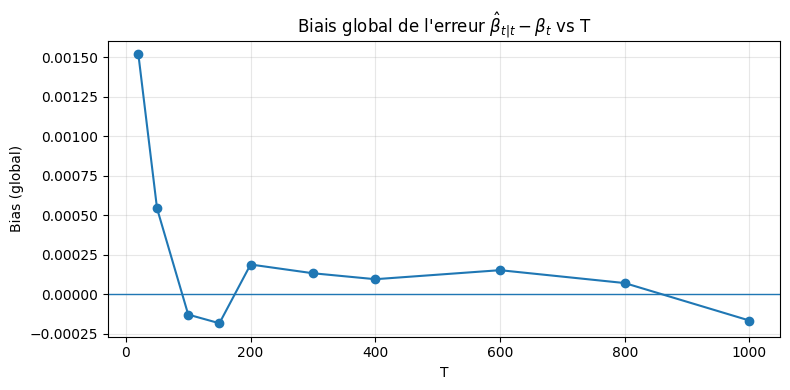

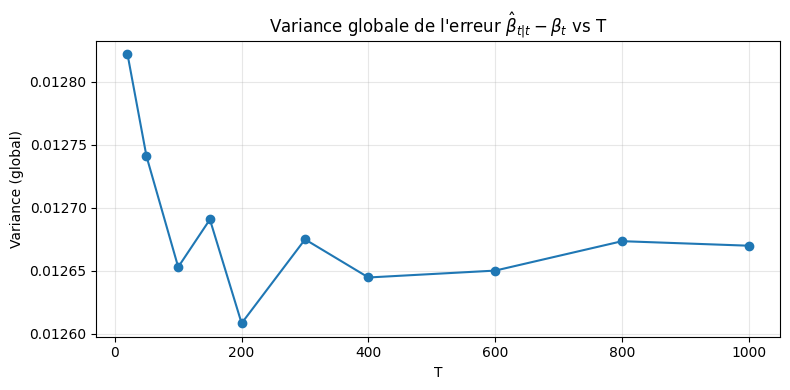

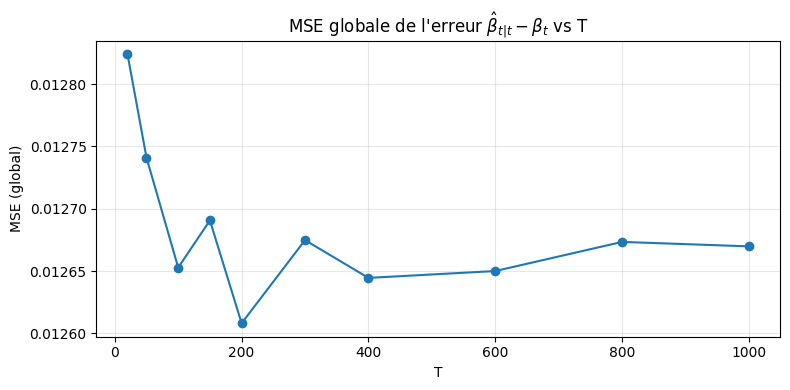

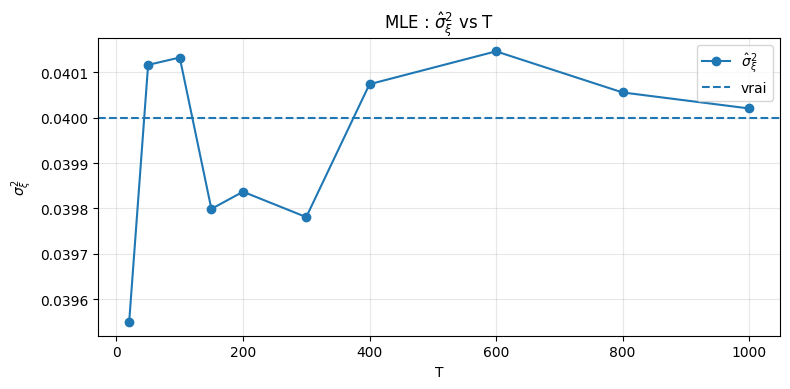

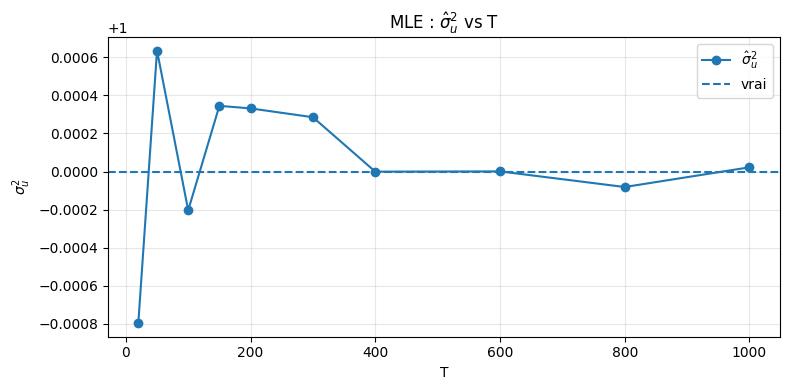

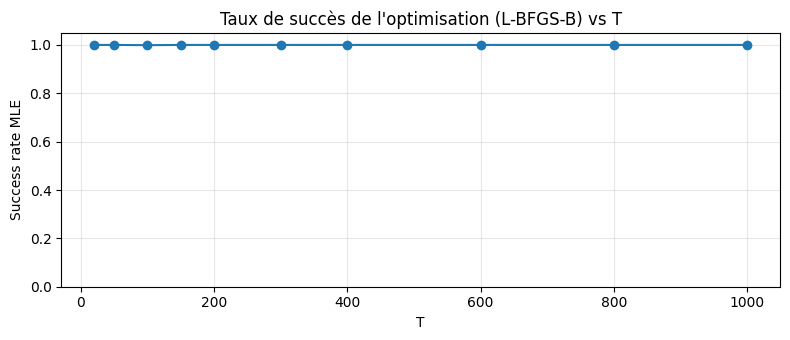

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# =========================================================
# Log-vraisemblance (innovations) - formule fermée panel
# =========================================================
def kf_loglike_panel(Y, sigma_xi2, sigma_u2, beta0=0.0, P0=1e6):
    T, N = Y.shape
    b = beta0
    P = P0
    ll = 0.0
    const = -0.5 * N * np.log(2 * np.pi)

    for t in range(T):
        y = Y[t]
        e = y - b
        one_e = e.sum()
        ee = float(e @ e)

        logdetS = (N - 1) * np.log(sigma_u2) + np.log(sigma_u2 + N * P)
        quad = (ee / sigma_u2) - (P / (sigma_u2 * (sigma_u2 + N * P))) * (one_e ** 2)

        ll += const - 0.5 * (logdetS + quad)

        # update
        b = b + P * one_e / (sigma_u2 + N * P)
        P = P * sigma_u2 / (sigma_u2 + N * P)

        # predict
        P = P + sigma_xi2

    return ll


def mle_params_panel(Y, beta0=0.0, P0=1e6):
    """MLE de (sigma_xi2, sigma_u2) en optimisant sur log-variances."""
    def objective(theta):
        sx2 = np.exp(theta[0])
        su2 = np.exp(theta[1])
        return -kf_loglike_panel(Y, sx2, su2, beta0=beta0, P0=P0)

    res = minimize(objective, np.log([0.04, 1.0]), method="L-BFGS-B")
    return float(np.exp(res.x[0])), float(np.exp(res.x[1])), bool(res.success)


# =========================================================
# Filtre KF panel (état scalaire) : retourne beta_{t|t}
# =========================================================
def kf_filter_panel(Y, sigma_xi2, sigma_u2, beta0=0.0, P0=1e6):
    T, N = Y.shape
    b = beta0
    P = P0

    beta_filt = np.zeros(T)
    P_filt = np.zeros(T)

    for t in range(T):
        e = Y[t] - b
        one_e = e.sum()

        # update
        b = b + P * one_e / (sigma_u2 + N * P)
        P = P * sigma_u2 / (sigma_u2 + N * P)

        beta_filt[t] = b
        P_filt[t] = P

        # predict
        P = P + sigma_xi2

    return beta_filt, P_filt


# =========================================================
# Simulation
# =========================================================
def simulate_panel(T, N, sigma_xi2, sigma_u2, rng):
    beta_true = np.zeros(T)
    for t in range(1, T):
        beta_true[t] = beta_true[t - 1] + rng.normal(0, np.sqrt(sigma_xi2))

    Y = beta_true[:, None] + rng.normal(0, np.sqrt(sigma_u2), size=(T, N))
    return beta_true, Y


# =========================================================
# MC : Bias/Var/MSE de l'erreur + paramètres estimés, vs T
# =========================================================
def mc_results_vs_T_indep_seeds(list_T, N, MC,
                               sigma_xi2_true, sigma_u2_true,
                               seed=123, beta0=0.0, P0=1e6, burn_frac=0.2):

    bias_list, var_list, mse_list = [], [], []
    xi2_mean_list, u2_mean_list, succ_list = [], [], []

    for j, T in enumerate(list_T):
        rng = np.random.default_rng(seed + 1000*j)  # <- seed différent par T
        burn = int(burn_frac * T)

        all_errors = []
        xi2_hats, u2_hats = [], []
        ok = 0

        for _ in range(MC):
            beta_true, Y = simulate_panel(T, N, sigma_xi2_true, sigma_u2_true, rng)

            sx2_hat, su2_hat, success = mle_params_panel(Y, beta0=beta0, P0=P0)
            if not success:
                continue

            ok += 1
            xi2_hats.append(sx2_hat)
            u2_hats.append(su2_hat)

            beta_hat, _ = kf_filter_panel(Y, sx2_hat, su2_hat, beta0=beta0, P0=P0)
            all_errors.extend(beta_hat[burn:] - beta_true[burn:])

        all_errors = np.array(all_errors)

        bias_list.append(all_errors.mean())
        var_list.append(all_errors.var(ddof=1))
        mse_list.append((all_errors**2).mean())

        xi2_mean_list.append(np.mean(xi2_hats))
        u2_mean_list.append(np.mean(u2_hats))
        succ_list.append(ok/MC)

    return (np.array(bias_list), np.array(var_list), np.array(mse_list),
            np.array(xi2_mean_list), np.array(u2_mean_list), np.array(succ_list))

# =========================================================
# RUN
# =========================================================
if __name__ == "__main__":

    sigma_xi2_true = 0.04
    sigma_u2_true  = 1.0

    N  = 60
    MC = 2000
    list_T = [20, 50, 100, 150, 200, 300, 400, 600, 800, 1000]

    bias_T, var_T, mse_T, xi2_hat_T, u2_hat_T, succ_T = mc_results_vs_T_indep_seeds(
        list_T=list_T,
        N=N,
        MC=MC,
        sigma_xi2_true=sigma_xi2_true,
        sigma_u2_true=sigma_u2_true,
        burn_frac=0.2
    )

    print("T:", list_T)
    print("Bias:", bias_T)
    print("Var :", var_T)
    print("MSE :", mse_T)
    print("sigma_xi2_hat mean:", xi2_hat_T)
    print("sigma_u2_hat  mean:", u2_hat_T)
    print("success rate:", succ_T)

    # --- Graphes : erreurs beta ---
    plt.figure(figsize=(8,4))
    plt.plot(list_T, bias_T, marker="o")
    plt.axhline(0, linewidth=1)
    plt.xlabel("T")
    plt.ylabel("Bias (global)")
    plt.title(r"Biais global de l'erreur $\hat\beta_{t|t}-\beta_t$ vs T")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(list_T, var_T, marker="o")
    plt.xlabel("T")
    plt.ylabel("Variance (global)")
    plt.title(r"Variance globale de l'erreur $\hat\beta_{t|t}-\beta_t$ vs T")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(list_T, mse_T, marker="o")
    plt.xlabel("T")
    plt.ylabel("MSE (global)")
    plt.title(r"MSE globale de l'erreur $\hat\beta_{t|t}-\beta_t$ vs T")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- Graphes : paramètres MLE ---
    plt.figure(figsize=(8,4))
    plt.plot(list_T, xi2_hat_T, marker="o", label=r"$\hat\sigma_\xi^2$")
    plt.axhline(sigma_xi2_true, linestyle="--", label="vrai")
    plt.xlabel("T")
    plt.ylabel(r"$\sigma_\xi^2$")
    plt.title(r"MLE : $\hat\sigma_\xi^2$ vs T")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(list_T, u2_hat_T, marker="o", label=r"$\hat\sigma_u^2$")
    plt.axhline(sigma_u2_true, linestyle="--", label="vrai")
    plt.xlabel("T")
    plt.ylabel(r"$\sigma_u^2$")
    plt.title(r"MLE : $\hat\sigma_u^2$ vs T")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- (optionnel) taux de succès de l'optimisation ---
    plt.figure(figsize=(8,3.5))
    plt.plot(list_T, succ_T, marker="o")
    plt.ylim(0, 1.05)
    plt.xlabel("T")
    plt.ylabel("Success rate MLE")
    plt.title("Taux de succès de l'optimisation (L-BFGS-B) vs T")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


T: [  20   50  100  150  200  300  400  600  800 1000]
xi2_mean: [0.039549 0.040117 0.040133 0.039799 0.039837 0.039781 0.040074 0.040146
 0.040056 0.04002 ]
xi2_bias: [-4.51e-04  1.17e-04  1.33e-04 -2.01e-04 -1.63e-04 -2.19e-04  7.40e-05
  1.46e-04  5.60e-05  2.00e-05]
xi2_var: [4.2240e-04 1.5258e-04 7.9850e-05 5.0310e-05 3.8240e-05 2.4630e-05
 1.9080e-05 1.2730e-05 9.1100e-06 7.5900e-06]
xi2_mse: [4.2240e-04 1.5252e-04 7.9830e-05 5.0320e-05 3.8250e-05 2.4670e-05
 1.9080e-05 1.2750e-05 9.1000e-06 7.5900e-06]

u2_mean: [0.999204 1.000636 0.999796 1.000345 1.000332 1.000285 0.999999 1.000001
 0.999919 1.000022]
u2_bias: [-7.96e-04  6.36e-04 -2.04e-04  3.45e-04  3.32e-04  2.85e-04 -1.00e-06
  1.00e-06 -8.10e-05  2.20e-05]
u2_var: [1.70026e-03 6.65620e-04 3.33290e-04 2.21050e-04 1.64040e-04 1.10060e-04
 8.91300e-05 5.67700e-05 4.25500e-05 3.14500e-05]
u2_mse: [1.70005e-03 6.65690e-04 3.33170e-04 2.21050e-04 1.64070e-04 1.10080e-04
 8.90800e-05 5.67400e-05 4.25400e-05 3.14300e-05]
success 

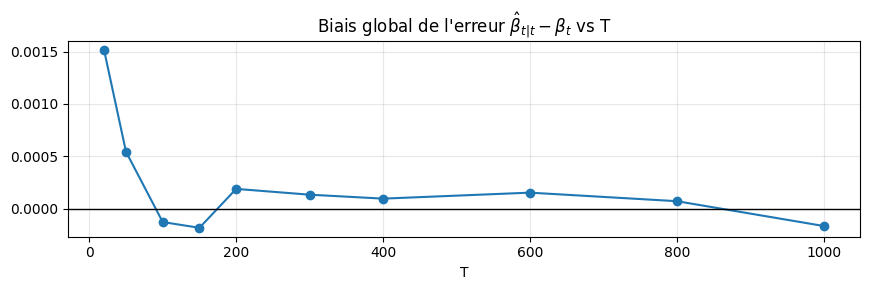

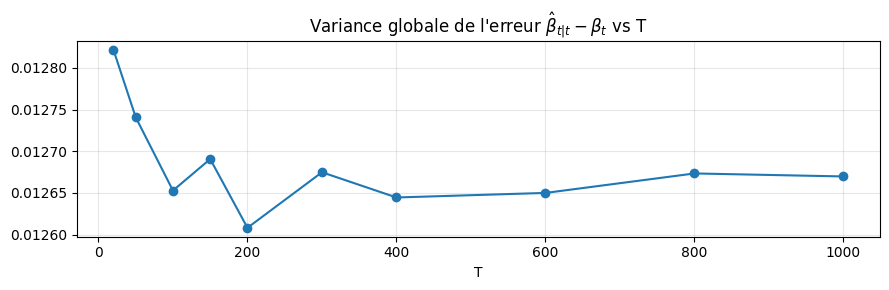

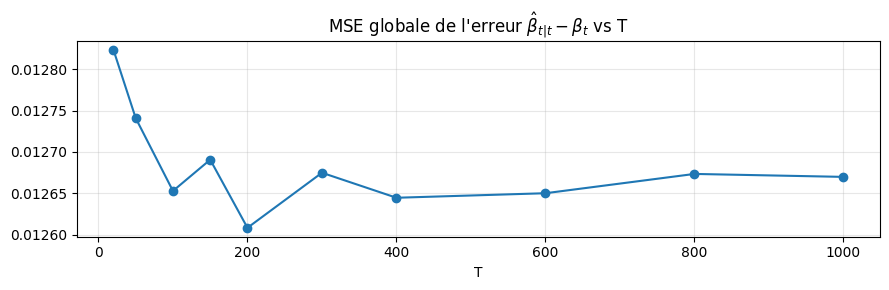

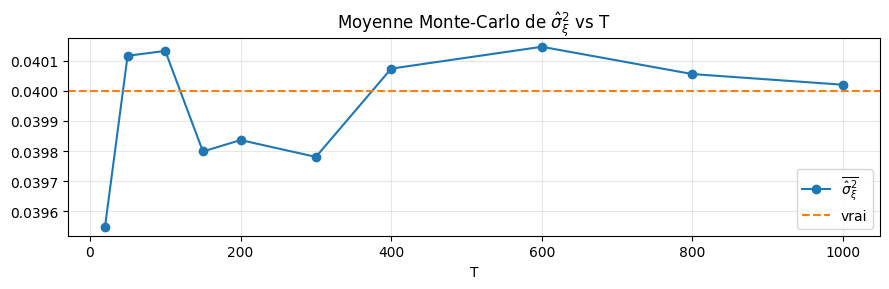

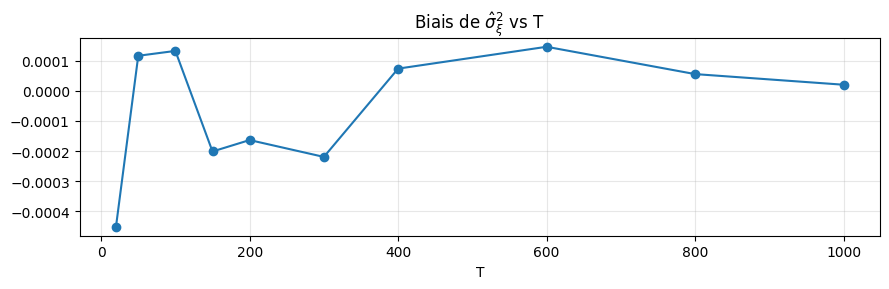

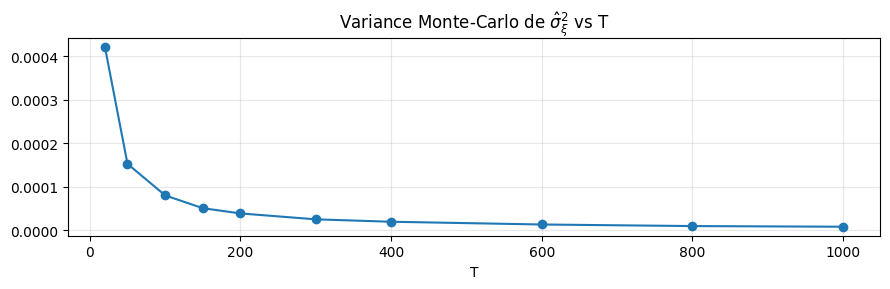

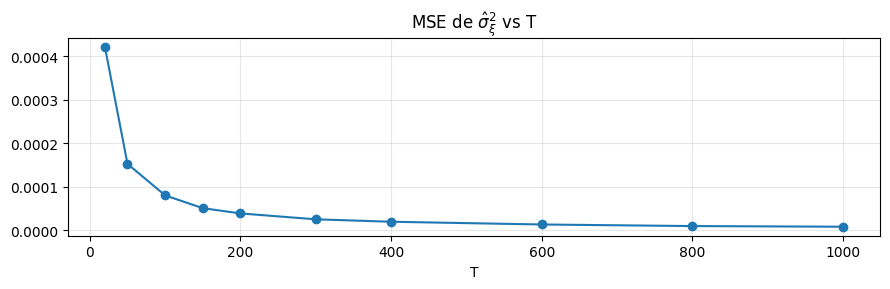

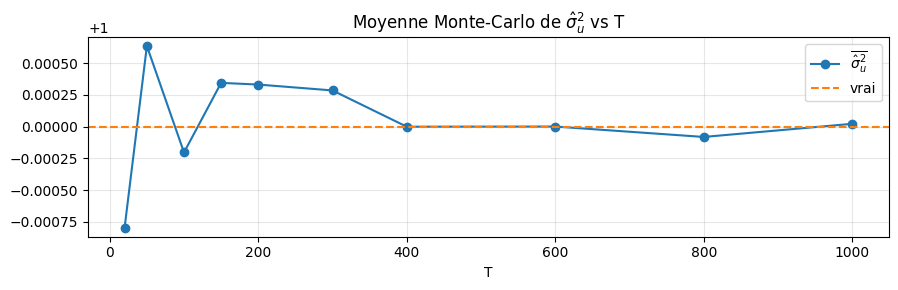

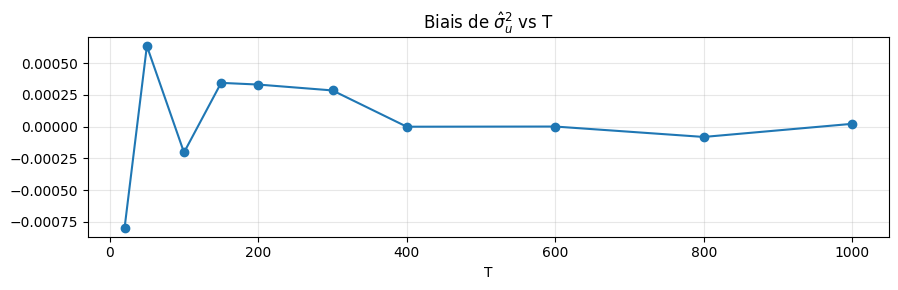

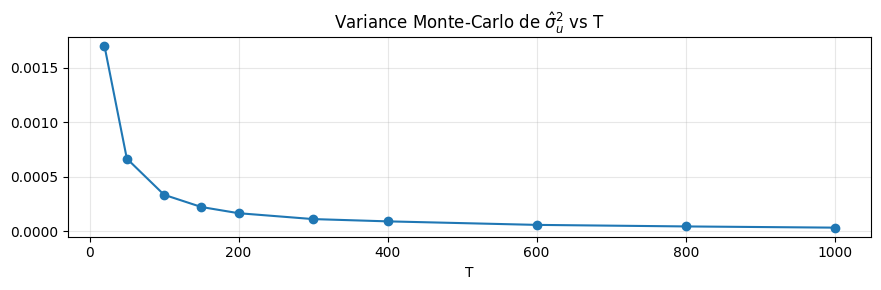

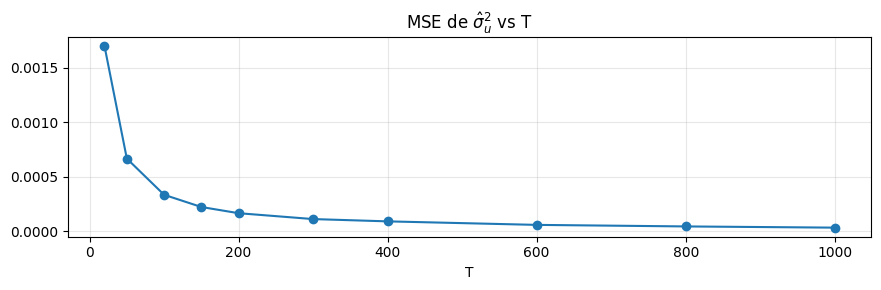

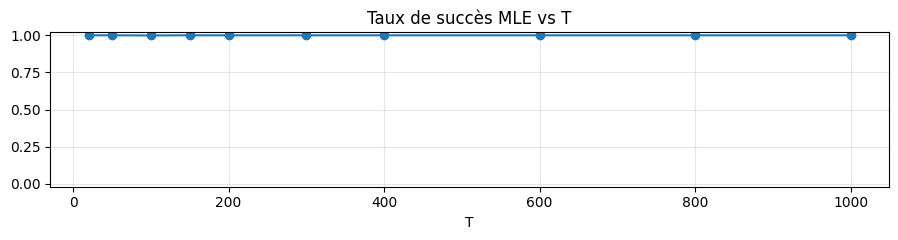

In [30]:
# --------------------------------------------------------
# Ajoute ce bloc après tes définitions existantes
# (simulate_panel, mle_params_panel, kf_filter_panel, ...)
# --------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

def mc_results_vs_T_with_param_stats(list_T, N, MC,
                                     sigma_xi2_true, sigma_u2_true,
                                     seed=123, beta0=0.0, P0=1e6,
                                     burn_frac=0.2):
    """
    Monte-Carlo over different T:
      - bias/var/mse global of beta error (as before)
      - bias/var/mse for estimated params sigma_xi2 and sigma_u2
    Returns dict of arrays indexed by list_T.
    """
    # outputs for beta errors
    bias_list = []
    var_list  = []
    mse_list  = []

    # outputs for params
    xi2_mean = []
    xi2_bias = []
    xi2_var  = []
    xi2_mse  = []

    u2_mean = []
    u2_bias = []
    u2_var  = []
    u2_mse  = []

    success_rate = []

    for j, T in enumerate(list_T):
        # seed different per T to decorrelate experiments
        rng = np.random.default_rng(seed + 1000*j)
        burn = int(burn_frac * T)

        # collect across MC
        all_errors = []
        xi2_hats = []
        u2_hats  = []
        ok = 0

        for _ in range(MC):
            beta_true, Y = simulate_panel(T, N, sigma_xi2_true, sigma_u2_true, rng)

            # MLE des paramètres
            sx2_hat, su2_hat, success = mle_params_panel(Y, beta0=beta0, P0=P0)
            if not success:
                # skip replication if optimisation failed
                continue

            ok += 1
            xi2_hats.append(sx2_hat)
            u2_hats.append(su2_hat)

            # filtre (avec params estimés)
            beta_hat, _ = kf_filter_panel(Y, sx2_hat, su2_hat, beta0=beta0, P0=P0)

            # erreurs à partir du burn-in
            errs = beta_hat[burn:] - beta_true[burn:]
            all_errors.extend(errs)

        all_errors = np.array(all_errors)

        # === stats beta errors ===
        bias_list.append(np.mean(all_errors) if all_errors.size>0 else np.nan)
        var_list.append(np.var(all_errors, ddof=1) if all_errors.size>1 else np.nan)
        mse_list.append(np.mean(all_errors**2) if all_errors.size>0 else np.nan)

        # === stats params ===
        xi2_hats = np.array(xi2_hats)
        u2_hats  = np.array(u2_hats)

        success_rate.append(ok / MC)

        if xi2_hats.size == 0:
            xi2_mean.append(np.nan); xi2_bias.append(np.nan); xi2_var.append(np.nan); xi2_mse.append(np.nan)
        else:
            m_x = xi2_hats.mean()
            xi2_mean.append(m_x)
            xi2_bias.append(m_x - sigma_xi2_true)
            xi2_var.append(xi2_hats.var(ddof=1))
            xi2_mse.append(np.mean((xi2_hats - sigma_xi2_true)**2))

        if u2_hats.size == 0:
            u2_mean.append(np.nan); u2_bias.append(np.nan); u2_var.append(np.nan); u2_mse.append(np.nan)
        else:
            m_u = u2_hats.mean()
            u2_mean.append(m_u)
            u2_bias.append(m_u - sigma_u2_true)
            u2_var.append(u2_hats.var(ddof=1))
            u2_mse.append(np.mean((u2_hats - sigma_u2_true)**2))

    return {
        "T": np.array(list_T),
        "beta_bias": np.array(bias_list),
        "beta_var": np.array(var_list),
        "beta_mse": np.array(mse_list),
        "xi2_mean": np.array(xi2_mean),
        "xi2_bias": np.array(xi2_bias),
        "xi2_var": np.array(xi2_var),
        "xi2_mse": np.array(xi2_mse),
        "u2_mean": np.array(u2_mean),
        "u2_bias": np.array(u2_bias),
        "u2_var": np.array(u2_var),
        "u2_mse": np.array(u2_mse),
        "success_rate": np.array(success_rate)
    }


def plot_results_vs_T(stats, sigma_xi2_true, sigma_u2_true):
    T = stats["T"]

    # Beta error: bias / var / mse
    plt.figure(figsize=(9,3))
    plt.plot(T, stats["beta_bias"], marker="o")
    plt.axhline(0, linewidth=1, color="k")
    plt.title("Biais global de l'erreur $\hat\\beta_{t|t}-\\beta_t$ vs T")
    plt.xlabel("T"); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

    plt.figure(figsize=(9,3))
    plt.plot(T, stats["beta_var"], marker="o")
    plt.title("Variance globale de l'erreur $\hat\\beta_{t|t}-\\beta_t$ vs T")
    plt.xlabel("T"); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

    plt.figure(figsize=(9,3))
    plt.plot(T, stats["beta_mse"], marker="o")
    plt.title("MSE globale de l'erreur $\hat\\beta_{t|t}-\\beta_t$ vs T")
    plt.xlabel("T"); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

    # Param sigma_xi2 : mean, bias, var, mse
    plt.figure(figsize=(9,3))
    plt.plot(T, stats["xi2_mean"], marker="o", label=r"$\overline{\hat\sigma_\xi^2}$")
    plt.axhline(sigma_xi2_true, linestyle="--", color="C1", label="vrai")
    plt.title(r"Moyenne Monte-Carlo de $\hat\sigma_\xi^2$ vs T")
    plt.xlabel("T"); plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

    plt.figure(figsize=(9,3))
    plt.plot(T, stats["xi2_bias"], marker="o")
    plt.title(r"Biais de $\hat\sigma_\xi^2$ vs T")
    plt.xlabel("T"); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

    plt.figure(figsize=(9,3))
    plt.plot(T, stats["xi2_var"], marker="o")
    plt.title(r"Variance Monte-Carlo de $\hat\sigma_\xi^2$ vs T")
    plt.xlabel("T"); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

    plt.figure(figsize=(9,3))
    plt.plot(T, stats["xi2_mse"], marker="o")
    plt.title(r"MSE de $\hat\sigma_\xi^2$ vs T")
    plt.xlabel("T"); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

    # Param sigma_u2 : mean, bias, var, mse
    plt.figure(figsize=(9,3))
    plt.plot(T, stats["u2_mean"], marker="o", label=r"$\overline{\hat\sigma_u^2}$")
    plt.axhline(sigma_u2_true, linestyle="--", color="C1", label="vrai")
    plt.title(r"Moyenne Monte-Carlo de $\hat\sigma_u^2$ vs T")
    plt.xlabel("T"); plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

    plt.figure(figsize=(9,3))
    plt.plot(T, stats["u2_bias"], marker="o")
    plt.title(r"Biais de $\hat\sigma_u^2$ vs T")
    plt.xlabel("T"); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

    plt.figure(figsize=(9,3))
    plt.plot(T, stats["u2_var"], marker="o")
    plt.title(r"Variance Monte-Carlo de $\hat\sigma_u^2$ vs T")
    plt.xlabel("T"); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

    plt.figure(figsize=(9,3))
    plt.plot(T, stats["u2_mse"], marker="o")
    plt.title(r"MSE de $\hat\sigma_u^2$ vs T")
    plt.xlabel("T"); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

    # success rate
    plt.figure(figsize=(9,2.5))
    plt.plot(T, stats["success_rate"], marker="o")
    plt.ylim(-0.02, 1.02)
    plt.title("Taux de succès MLE vs T")
    plt.xlabel("T"); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()


# ---------------- RUN exemple ----------------
if __name__ == "__main__":
    list_T = [20, 50, 100, 150, 200, 300, 400, 600, 800, 1000]
    N = 60
    MC = 2000           # MC plus grand pour param stats
    Q_true = 0.04
    V_true = 1.0

    stats = mc_results_vs_T_with_param_stats(list_T, N, MC, Q_true, V_true,
                                            seed=123, burn_frac=0.2)

    # affichage synthétique
    print("T:", stats["T"])
    print("xi2_mean:", np.round(stats["xi2_mean"], 6))
    print("xi2_bias:", np.round(stats["xi2_bias"], 6))
    print("xi2_var:", np.round(stats["xi2_var"], 8))
    print("xi2_mse:", np.round(stats["xi2_mse"], 8))
    print()
    print("u2_mean:", np.round(stats["u2_mean"], 6))
    print("u2_bias:", np.round(stats["u2_bias"], 6))
    print("u2_var:", np.round(stats["u2_var"], 8))
    print("u2_mse:", np.round(stats["u2_mse"], 8))
    print("success rate:", np.round(stats["success_rate"], 3))

    # tracer les figures
    plot_results_vs_T(stats, Q_true, V_true)

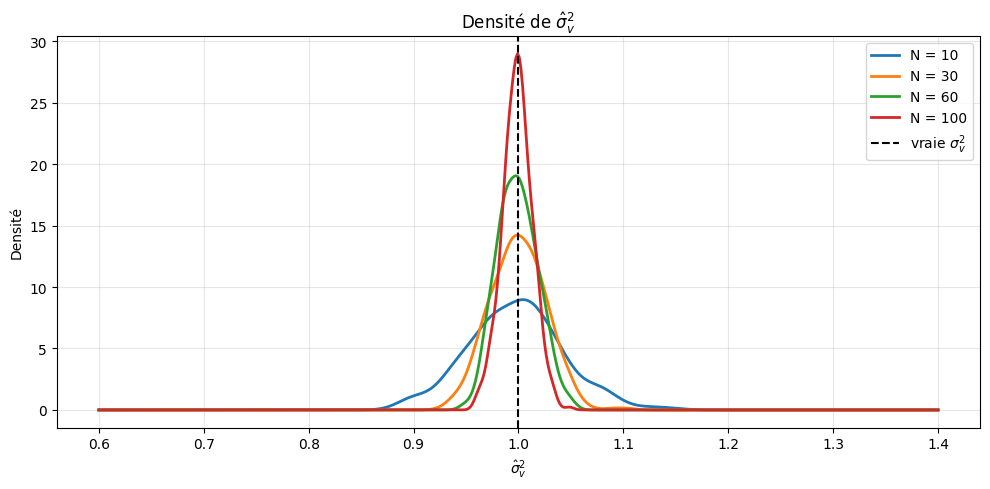

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import gaussian_kde

# =====================================================
# Log-vraisemblance KF multivariée (sigma_xi2 connu)
# =====================================================

def kf_loglike_panel_sigma_u(Y, sigma_xi2, sigma_u2, beta0=0.0, P0=1e6):
    T, N = Y.shape
    b = beta0
    P = P0
    ll = 0.0
    const = -0.5 * N * np.log(2*np.pi)

    for t in range(T):
        y = Y[t]
        e = y - b
        one_e = e.sum()
        ee = np.dot(e, e)

        logdetS = (N - 1)*np.log(sigma_u2) + np.log(sigma_u2 + N*P)
        quad = (ee / sigma_u2) - (P / (sigma_u2*(sigma_u2 + N*P))) * (one_e**2)

        ll += const - 0.5*(logdetS + quad)

        # KF update
        K = P / (sigma_u2 + N*P)
        b = b + K * one_e
        P = P * sigma_u2 / (sigma_u2 + N*P)

        # prediction
        P = P + sigma_xi2

    return ll


# =====================================================
# MLE de sigma_u^2 (sigma_xi^2 connu)
# =====================================================

def mle_sigma_u_panel(Y, sigma_xi2):
    def objective(log_su2):
        su2 = np.exp(log_su2)
        return -kf_loglike_panel_sigma_u(Y, sigma_xi2, su2)

    res = minimize(objective, x0=[0.0], method="L-BFGS-B")
    return np.exp(res.x[0])


# =====================================================
# Monte Carlo : distribution de sigma_u^2
# =====================================================

def mc_sigma_u2_distribution(N, T, MC, sigma_xi2, sigma_u2, seed=123):
    rng = np.random.default_rng(seed)
    samples = []

    for _ in range(MC):
        beta = np.zeros(T)
        for t in range(1, T):
            beta[t] = beta[t-1] + rng.normal(0, np.sqrt(sigma_xi2))

        U = rng.normal(0, np.sqrt(sigma_u2), size=(T, N))
        Y = beta[:, None] + U

        su2_hat = mle_sigma_u_panel(Y, sigma_xi2)
        samples.append(su2_hat)

    return np.array(samples)


# =====================================================
# PARAMÈTRES
# =====================================================

T = 100
MC = 400
sigma_xi2_true = 0.05
sigma_u2_true = 1.0

N_list = [10, 30, 60, 100]

# =====================================================
# SIMULATION
# =====================================================

densities = {}
for N in N_list:
    densities[N] = mc_sigma_u2_distribution(
        N, T, MC, sigma_xi2_true, sigma_u2_true
    )

# =====================================================
# GRAPHE DE DENSITÉ
# =====================================================

xs = np.linspace(0.6, 1.4, 500)

plt.figure(figsize=(10,5))

for N in N_list:
    kde = gaussian_kde(densities[N])
    plt.plot(xs, kde(xs), label=f"N = {N}", linewidth=2)

plt.axvline(sigma_u2_true, color="black", linestyle="--", label="vraie $\\sigma_v^2$")

plt.xlabel(r"$\hat{\sigma}_v^2$")
plt.ylabel("Densité")
plt.title(r"Densité de $\hat{\sigma}_v^2$ ")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


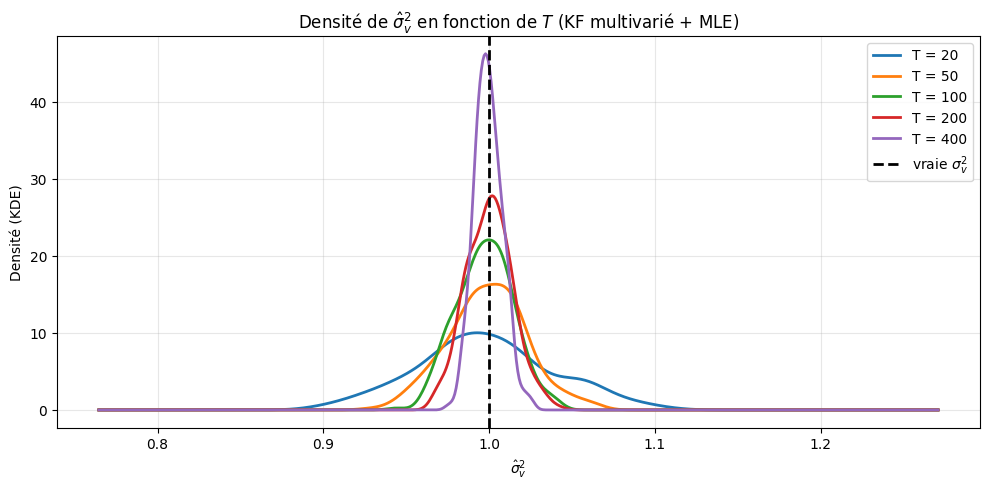

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import gaussian_kde

# =====================================================
# Log-vraisemblance KF multivariée (sigma_xi2 connu)
# Modèle :
#   beta_t = beta_{t-1} + xi_t,  xi_t ~ N(0, sigma_xi2)
#   Y_t    = 1_N * beta_t + u_t, u_t  ~ N(0, sigma_u2 I_N)
# =====================================================

def kf_loglike_panel_sigma_u(Y, sigma_xi2, sigma_u2, beta0=0.0, P0=1e6):
    T, N = Y.shape
    b = beta0
    P = P0
    ll = 0.0
    const = -0.5 * N * np.log(2*np.pi)

    for t in range(T):
        y = Y[t]
        e = y - b
        one_e = e.sum()
        ee = np.dot(e, e)

        # S_t = sigma_u2 I_N + P 1 1'
        logdetS = (N - 1)*np.log(sigma_u2) + np.log(sigma_u2 + N*P)
        quad = (ee / sigma_u2) - (P / (sigma_u2*(sigma_u2 + N*P))) * (one_e**2)

        ll += const - 0.5*(logdetS + quad)

        # KF update (forme fermée, état scalaire)
        K = P / (sigma_u2 + N*P)
        b = b + K * one_e
        P = P * sigma_u2 / (sigma_u2 + N*P)

        # prediction
        P = P + sigma_xi2

    return ll


def mle_sigma_u2_panel(Y, sigma_xi2):
    # optimisation sur log(sigma_u2) pour garantir sigma_u2 > 0
    def objective(log_su2):
        su2 = np.exp(log_su2)
        return -kf_loglike_panel_sigma_u(Y, sigma_xi2, su2)

    res = minimize(objective, x0=[0.0], method="L-BFGS-B")
    return np.exp(res.x[0])


# =====================================================
# Simulation Monte-Carlo : distribution de sigma_u^2 pour un T donné
# =====================================================

def mc_sigma_u2_distribution_T(T, N, MC, sigma_xi2_true, sigma_u2_true, seed=123):
    rng = np.random.default_rng(seed)
    samples = []

    for _ in range(MC):
        # beta_t random walk
        beta = np.zeros(T)
        for t in range(1, T):
            beta[t] = beta[t-1] + rng.normal(0, np.sqrt(sigma_xi2_true))

        # panel Y_{t,i}
        U = rng.normal(0, np.sqrt(sigma_u2_true), size=(T, N))
        Y = beta[:, None] + U

        # MLE sigma_u^2
        su2_hat = mle_sigma_u2_panel(Y, sigma_xi2_true)
        samples.append(su2_hat)

    return np.array(samples)


# =====================================================
# PARAMÈTRES
# =====================================================

N_fixed = 60
MC = 300
sigma_xi2_true = 0.05
sigma_u2_true = 1.0

T_list = [20, 50, 100, 200, 400]

# =====================================================
# SIMULATION
# =====================================================

samples_by_T = {}
for T in T_list:
    samples_by_T[T] = mc_sigma_u2_distribution_T(
        T=T, N=N_fixed, MC=MC,
        sigma_xi2_true=sigma_xi2_true,
        sigma_u2_true=sigma_u2_true,
        seed=123 + T
    )

# =====================================================
# GRAPHE KDE
# =====================================================

# grille x adaptée aux valeurs simulées
all_samples = np.concatenate(list(samples_by_T.values()))
xmin = max(1e-6, all_samples.min() * 0.85)
xmax = all_samples.max() * 1.15
xs = np.linspace(xmin, xmax, 600)

plt.figure(figsize=(10,5))

for T in T_list:
    kde = gaussian_kde(samples_by_T[T])
    plt.plot(xs, kde(xs), linewidth=2, label=f"T = {T}")

plt.axvline(sigma_u2_true, color="black", linestyle="--", linewidth=2,
            label=r"vraie $\sigma_v^2$")

plt.xlabel(r"$\hat{\sigma}_v^2$")
plt.ylabel("Densité (KDE)")
plt.title(r"Densité de $\hat{\sigma}_v^2$ en fonction de $T$ (KF multivarié + MLE)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# Part 2

moyenne sigma_u^2 (N=10)  : 1.0015634273795184
moyenne sigma_u^2 (N=100) : 1.0027245121705963


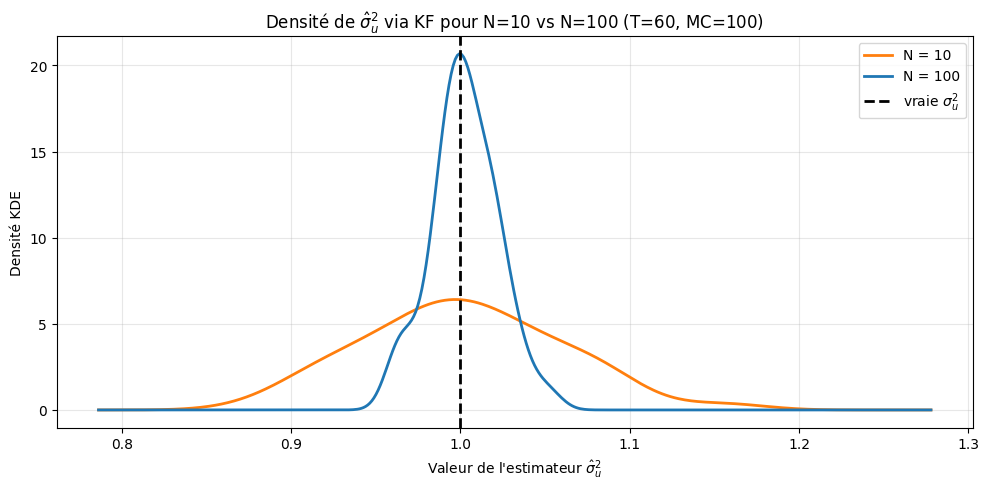

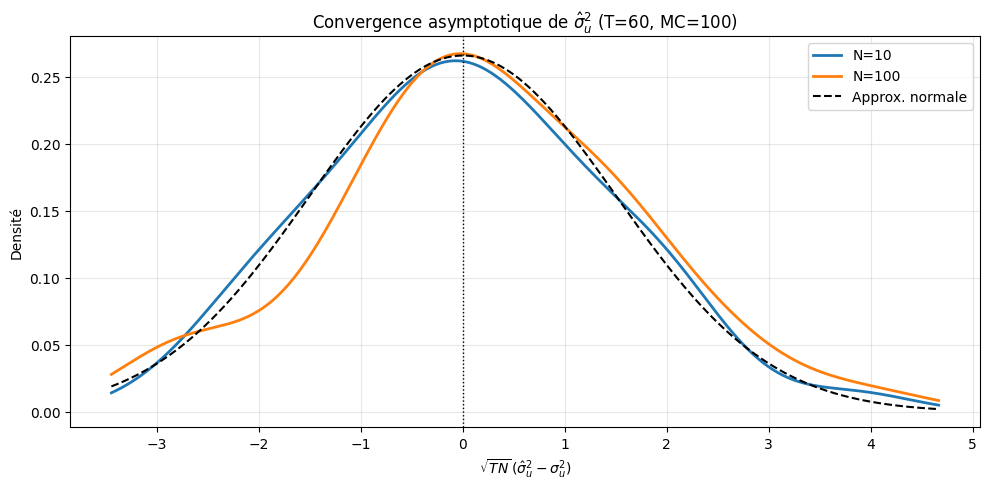

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import gaussian_kde

# =====================================================
# 1. Kalman FILTER avec données INDIVIDUELLES Y_it
#    (on boucle sur i = 1..N à chaque t)
# =====================================================

def kf_loglike_individual(Y, Q, su, beta0=0.0, P0=1e6):
    """
    Log-vraisemblance du modèle :
        beta_t = beta_{t-1} + xi_t,   xi_t ~ N(0, Q)
        Y_it   = beta_t + u_it,      u_it ~ N(0, su^2)
    en utilisant T x N données individuelles Y[t, i].

    On fait les mises à jour Kalman pour chaque individu i
    au même instant t.
    """
    T, N = Y.shape
    beta_pred = beta0
    P_pred = P0
    loglik = 0.0

    for t in range(T):
        # Mises à jour à l'instant t pour chacun des N individus
        for i in range(N):
            y_it = Y[t, i]
            e_it = y_it - beta_pred             # innovation
            S_it = P_pred + su**2               # variance de l'innovation
            loglik += -0.5 * (
                np.log(2*np.pi) + np.log(S_it) + (e_it**2) / S_it
            )
            K_it = P_pred / S_it                # gain de Kalman
            beta_pred = beta_pred + K_it * e_it
            P_pred = (1.0 - K_it) * P_pred

        # Prédiction pour t+1 (processus random walk)
        P_pred = P_pred + Q

    return loglik


def kf_filter_individual(Y, Q, su, beta0=0.0, P0=1e6):
    """
    Même modèle que ci-dessus, mais on renvoie la suite filtrée beta_{t|t}.
    """
    T, N = Y.shape
    beta_upd = np.zeros(T)
    P_upd = np.zeros(T)

    beta_pred = beta0
    P_pred = P0

    for t in range(T):
        # Updates successifs pour i = 1..N
        for i in range(N):
            y_it = Y[t, i]
            e_it = y_it - beta_pred
            S_it = P_pred + su**2
            K_it = P_pred / S_it
            beta_pred = beta_pred + K_it * e_it
            P_pred = (1.0 - K_it) * P_pred

        beta_upd[t] = beta_pred
        P_upd[t] = P_pred

        # prédiction pour t+1
        P_pred = P_pred + Q

    return beta_upd, P_upd


# =====================================================
# 2. MLE de sigma_u avec Q connu (via Kalman individuel)
# =====================================================

def mle_sigma_u_individual(Y, Q_true, beta0=0.0, P0=1e6):
    """
    Estime sigma_u par MLE en maximisant la log-vraisemblance
    donnée par kf_loglike_individual, en supposant Q = Q_true connu.
    On travaille sur log(su) pour imposer su > 0.
    """
    def objective(log_su):
        su = np.exp(log_su)  # su > 0
        return -kf_loglike_individual(Y, Q_true, su, beta0=beta0, P0=P0)

    x0 = np.array([0.0])  # départ sur log(1.0)
    res = minimize(objective, x0, method="L-BFGS-B")
    su_hat = np.exp(res.x[0])
    return su_hat


# =====================================================
# 3. Monte Carlo pour la distribution de sigma_u^2
#    avec données individuelles
# =====================================================

def mc_sigma_u2_individual(N, T=120, MC=500,
                           Q_true=0.04, su_true=1.0, seed=123):
    """
    MC réalisations de l’estimateur sigma_u^2 via :
      - simulation d’un panel Y_it (N obs / période)
      - estimation de sigma_u via MLE Kalman (Q fixé)
    """
    rng = np.random.default_rng(seed)
    sigma2_samples = []

    for _ in range(MC):
        # 1) simuler beta_t (random walk)
        beta = np.zeros(T)
        for t in range(1, T):
            beta[t] = beta[t-1] + rng.normal(0, np.sqrt(Q_true))

        # 2) simuler le panel Y_it
        U = rng.normal(0, su_true, size=(T, N))  # u_it
        Y = beta[:, None] + U                    # Y_it = beta_t + u_it

        # 3) MLE de sigma_u via Kalman individuel
        su_hat = mle_sigma_u_individual(Y, Q_true)
        sigma2_samples.append(su_hat**2)

    return np.array(sigma2_samples)


# =====================================================
# 4. Expérience : N petit vs N grand
# =====================================================

T = 60
MC = 100
N_small = 10
N_large = 100
Q_true = 0.05
su_true = 1.0

sigma2_small = mc_sigma_u2_individual(N_small, T=T, MC=MC,
                                      Q_true=Q_true, su_true=su_true, seed=123)
sigma2_large = mc_sigma_u2_individual(N_large, T=T, MC=MC,
                                      Q_true=Q_true, su_true=su_true, seed=456)

print("moyenne sigma_u^2 (N=10)  :", sigma2_small.mean())
print("moyenne sigma_u^2 (N=100) :", sigma2_large.mean())

# =====================================================
# 5. Tracé des densités (KDE)
# =====================================================

xs = np.linspace(
    min(sigma2_small.min(), sigma2_large.min()) * 0.9,
    max(sigma2_small.max(), sigma2_large.max()) * 1.1,
    400
)

kde_small = gaussian_kde(sigma2_small)
kde_large = gaussian_kde(sigma2_large)

plt.figure(figsize=(10, 5))
plt.plot(xs, kde_small(xs), label=f"N = {N_small}", color="tab:orange", linewidth=2)
plt.plot(xs, kde_large(xs), label=f"N = {N_large}", color="tab:blue", linewidth=2)

plt.axvline(su_true**2, color="k", linestyle="--", linewidth=2, label=r"vraie $\sigma_u^2$")

plt.xlabel(r"Valeur de l'estimateur $\hat{\sigma}_u^2$")
plt.ylabel("Densité KDE")
plt.title(
    rf"Densité de $\hat\sigma_u^2$ via KF pour N={N_small} vs N={N_large} "
    rf"(T={T}, MC={MC})"
)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
from scipy.stats import gaussian_kde, norm

# -----------------------------------------------------
# Transformation asymptotique
# -----------------------------------------------------
Z_small = np.sqrt(T * N_small) * (sigma2_small - su_true**2)
Z_large = np.sqrt(T * N_large) * (sigma2_large - su_true**2)

# Grille
xs = np.linspace(
    min(Z_small.min(), Z_large.min()) * 1.1,
    max(Z_small.max(), Z_large.max()) * 1.1,
    500
)

kde_small = gaussian_kde(Z_small)
kde_large = gaussian_kde(Z_large)

# -----------------------------------------------------
# Tracé
# -----------------------------------------------------
plt.figure(figsize=(10,5))

plt.plot(xs, kde_small(xs), label=f"N={N_small}", linewidth=2)
plt.plot(xs, kde_large(xs), label=f"N={N_large}", linewidth=2)

# Gaussienne standard (repère visuel)
plt.plot(xs, norm.pdf(xs, 0, np.std(Z_large)),
         "k--", label="Approx. normale")

plt.axvline(0, color="k", linestyle=":", linewidth=1)

plt.xlabel(r"$\sqrt{TN}\,(\hat\sigma_u^2 - \sigma_u^2)$")
plt.ylabel("Densité")
plt.title(
    rf"Convergence asymptotique de $\hat\sigma_u^2$ "
    rf"(T={T}, MC={MC})"
)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()



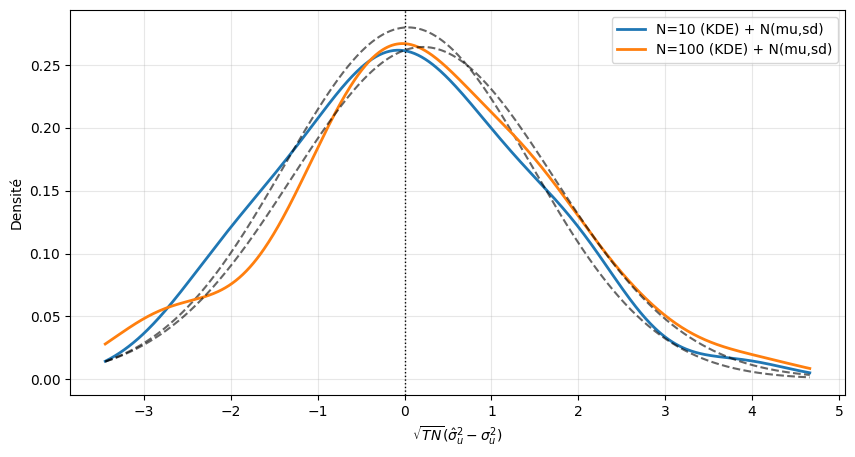


N=10
  mean=0.0383, std=1.4253
  skew=0.2209 (normal=0)
  kurtosis(excess)=-0.1467 (normal=0)
  KS stat=0.0475, p-value=0.9697

N=100
  mean=0.2110, std=1.5093
  skew=0.0393 (normal=0)
  kurtosis(excess)=0.1113 (normal=0)
  KS stat=0.0504, p-value=0.9501


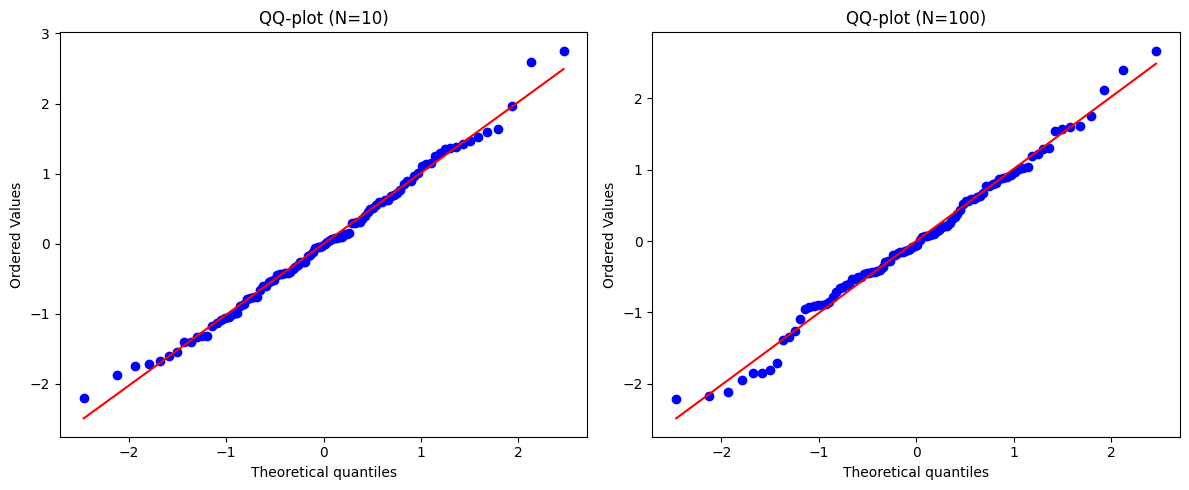

In [26]:
from scipy.stats import norm, gaussian_kde

def plot_kde_and_fitted_normal(Z, label, xs):
    kde = gaussian_kde(Z)
    mu, sd = Z.mean(), Z.std(ddof=1)
    plt.plot(xs, kde(xs), linewidth=2, label=label)
    plt.plot(xs, norm.pdf(xs, mu, sd), "k--", alpha=0.6)

xs = np.linspace(min(Z_small.min(), Z_large.min())*1.1,
                 max(Z_small.max(), Z_large.max())*1.1, 600)

plt.figure(figsize=(10,5))
plot_kde_and_fitted_normal(Z_small, "N=10 (KDE) + N(mu,sd)", xs)
plot_kde_and_fitted_normal(Z_large, "N=100 (KDE) + N(mu,sd)", xs)
plt.axvline(0, color="k", linestyle=":", linewidth=1)
plt.grid(alpha=0.3)
plt.legend()
plt.xlabel(r"$\sqrt{TN}(\hat\sigma_u^2-\sigma_u^2)$")
plt.ylabel("Densité")
plt.show()
import scipy.stats as st
import matplotlib.pyplot as plt

def normal_diagnostics(Z, name):
    mu, sd = Z.mean(), Z.std(ddof=1)
    skew = st.skew(Z, bias=False)
    kurt = st.kurtosis(Z, fisher=True, bias=False)  # 0 si normal
    ks = st.kstest((Z - mu)/sd, 'norm')  # test sur version standardisée
    print(f"\n{name}")
    print(f"  mean={mu:.4f}, std={sd:.4f}")
    print(f"  skew={skew:.4f} (normal=0)")
    print(f"  kurtosis(excess)={kurt:.4f} (normal=0)")
    print(f"  KS stat={ks.statistic:.4f}, p-value={ks.pvalue:.4f}")

# diagnostics
normal_diagnostics(Z_small, "N=10")
normal_diagnostics(Z_large, "N=100")

# QQ-plots
fig, ax = plt.subplots(1, 2, figsize=(12,5))
st.probplot((Z_small - Z_small.mean())/Z_small.std(ddof=1), dist="norm", plot=ax[0])
ax[0].set_title("QQ-plot (N=10)")

st.probplot((Z_large - Z_large.mean())/Z_large.std(ddof=1), dist="norm", plot=ax[1])
ax[1].set_title("QQ-plot (N=100)")
plt.tight_layout()
plt.show()



# Part 3

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t as student_t

# ---------- Simulation ----------
def simulate_panel_student_t_with_outliers(T, N, Q_true, sigma_v2_true, nu,
                                          p_out=0.01, mult=20, seed=123):
    rng = np.random.default_rng(seed)

    beta_true = np.zeros(T)
    for t in range(1, T):
        beta_true[t] = beta_true[t-1] + rng.normal(0.0, np.sqrt(Q_true))
        
    scale = np.sqrt(sigma_v2_true * (nu - 2.0) / nu)
    eps = student_t.rvs(df=nu, loc=0.0, scale=scale, size=(T, N), random_state=rng)

    # outliers rares EN PLUS
    #mask = rng.random((T, N)) < p_out
    #eps[mask] *= mult

    Z = beta_true[:, None] + eps
    return beta_true, Z

# ---------- KF oracle (gaussien) ----------
def kf_oracle_panel(Z, Q_true, sigma_v2_true, beta0=0.0, P0=1e6):
    T, N = Z.shape
    b, P = beta0, P0
    beta_hat = np.zeros(T)

    for t in range(T):
        e = Z[t] - b
        one_e = e.sum()
        denom = sigma_v2_true + N * P

        b = b + P * one_e / denom
        P = P * sigma_v2_true / denom

        beta_hat[t] = b
        P = P + Q_true

    return beta_hat

import numpy as np

def dcs_t_filter_and_u(Z, sigma_v2_true, nu, kappa, beta0=0.0):
    """
    Calcule:
      - beta_hat[t] = beta_t (valeur AVANT mise à jour avec u_t)
      - u[t] = u_t calculé à partir de Z_t et beta_t
      - zeta[t] = kappa * u_{t-1}  (innovation d'état à l'instant t)
    Remarque: zeta[0] = 0 (pas d'u_{-1})
    """
    T, N = Z.shape
    b = beta0

    beta_hat = np.zeros(T)
    u = np.zeros(T)
    zeta = np.zeros(T)

    for t in range(T):
        # stocke beta_t (avant mise à jour)
        beta_hat[t] = b

        # résidus e_t = z_t - 1_N * beta_t
        e = Z[t] - b
        one_e = e.sum()
        ee = float(e @ e)

        # ω_t
        omega = 1.0 + ee / (nu * sigma_v2_true)

        # u_t selon (21)
        u_t = (1.0 / omega) * ((nu + N) / nu) * (1.0 / sigma_v2_true) * one_e
        u[t] = u_t

        # zeta_t = kappa * u_{t-1} (pour t=0 on laisse 0)
        if t >= 1:
            zeta[t] = kappa * u[t-1]
        else:
            zeta[t] = 0.0

        # mise à jour pour la période suivante : beta_{t+1} = beta_t + kappa * u_t
        b = b + kappa * u_t

    return beta_hat, u, zeta


def calibrate_kappa_prof(Z, Q_true, sigma_v2_true, nu, beta0=0.0, kappa_init=0.01,
                         n_iter=100, burn_frac=0.2, var_floor=1e-8, damping=0.2):
    """
    Calibre kappa pour respecter sigma_xi^2 = kappa^2 Var(u_{t-1}).
    On estime Var(u_{t-1}) empiriquement à partir de la série u calculée
    par le filtre. Pour être cohérent avec zeta_t = kappa * u_{t-1},
    on prend la série u[:-1] (excluant le dernier u_T) après burn-in.
    """
    T, _ = Z.shape
    burn = int(burn_frac * T)

    kappa = float(kappa_init)
    for _ in range(n_iter):
        # calcule u avec la valeur courante de kappa
        _, u, _ = dcs_t_filter_and_u(Z, sigma_v2_true, nu, kappa, beta0=beta0)

        # on retire burn-in; pour aligner zeta_t = kappa u_{t-1}, on prend u[:-1]
        if T - burn - 1 > 0:
            u_use = u[burn:-1]   # on enlève le dernier élément car u_{T-1} -> zeta_T
        else:
            # si on a trop peu de points, on prend ce qu'on a (sécurité)
            u_use = u[burn:]

        u_use = u_use - u_use.mean()
        var_u = float(np.mean(u_use**2)) if u_use.size > 0 else var_floor

        # stabilisation
        var_u = max(var_u, var_floor)

        kappa_new = np.sqrt(Q_true / var_u)

        # damping pour stabilité numérique
        kappa = (1.0 - damping) * kappa + damping * kappa_new

    return kappa

# ---------- Comparaison MC ----------
def compare_oracle_kf_vs_dcs_panel(T=300, N=60, MC=2000, Q_true=0.04, sigma_v2_true=1.0,
                                  nu=5, seed=123, burn_frac=0.2, plot_one=True):
    rng = np.random.default_rng(seed)
    burn = int(burn_frac * T)

    mse_kf, mse_dcs = [], []
    saved = None

    for _ in range(MC):
        beta_true, Z = simulate_panel_student_t_with_outliers(
            T, N, Q_true, sigma_v2_true, nu, seed=int(rng.integers(1, 10_000_000))
        )

        beta_kf = kf_oracle_panel(Z, Q_true, sigma_v2_true)

        # kappa calibré "comme le prof"
        kappa = calibrate_kappa_prof(Z, Q_true, sigma_v2_true, nu, kappa_init=0.01, n_iter=10)
        
        beta_dcs, _ = dcs_t_filter_and_u(Z, sigma_v2_true, nu, kappa)

        mse_kf.append(np.mean((beta_kf[burn:] - beta_true[burn:])**2))
        mse_dcs.append(np.mean((beta_dcs[burn:] - beta_true[burn:])**2))

        if plot_one and saved is None:
            saved = (beta_true, beta_kf, beta_dcs, kappa)

    mse_kf = np.array(mse_kf)
    mse_dcs = np.array(mse_dcs)

    print(f"nu={nu}, T={T}, N={N}, MC={MC}")
    print(f"KF  mean MSE={mse_kf.mean():.6f}, std={mse_kf.std():.6f}")
    print(f"DCS mean MSE={mse_dcs.mean():.6f}, std={mse_dcs.std():.6f}")

    if saved is not None:
        beta_true, beta_kf, beta_dcs, kappa = saved
        plt.figure(figsize=(10,5))
        plt.plot(beta_true, lw=2, label=r"$\beta_t$ vrai")
        plt.plot(beta_kf, "--", label="KF gaussien ")
        plt.plot(beta_dcs, "-.", label=rf"DCS-$t$ ( $\kappa$={kappa:.4f})")
        plt.title("KF vs DCS-$t$  — erreurs Student-$t$")
        plt.xlabel("t"); plt.ylabel(r"$\beta$")
        plt.grid(alpha=0.3); plt.legend(); plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8, 4))
        plt.boxplot([mse_kf, mse_dcs], labels=["KF ", "DCS-t "], showmeans=True)
        plt.ylabel("MSE sur $\\hat\\beta_t$ ")
        plt.title("Distribution du MSE : KF vs DCS-$t$ (paramètres vrais)")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    return mse_kf, mse_dcs

# ---- RUN ----
if __name__ == "__main__":
    compare_oracle_kf_vs_dcs_panel(T=200, N=60, MC=2000, Q_true=0.04, sigma_v2_true=1.0, nu=5)



ValueError: too many values to unpack (expected 2)

nu=5, T=500, N=5, MC=2000
KF  mean MSE=0.071753, std=0.008034
DCS mean MSE=0.110626, std=0.012608


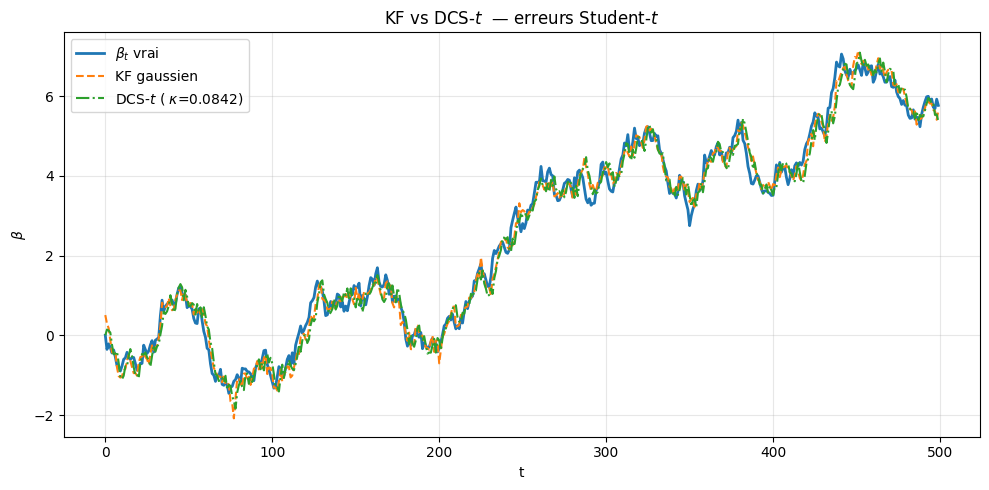

C:\Users\ReMarkt\AppData\Local\Temp\ipykernel_2848\2585093267.py:180: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([mse_kf, mse_dcs], labels=["KF ", "DCS-t "], showmeans=True)


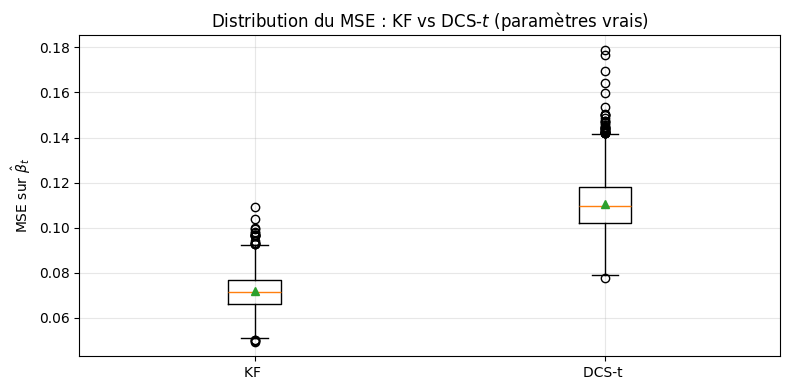

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t as student_t

# ---------- Simulation ----------
def simulate_panel_student_t_with_outliers(T, N, Q_true, sigma_v2_true, nu,
                                          p_out=0.01, mult=20, seed=123):
    rng = np.random.default_rng(seed)
    seed_int = int(rng.integers(1, 1_000_000_000))

    beta_true = np.zeros(T)
    for t in range(1, T):
        beta_true[t] = beta_true[t-1] + rng.normal(0.0, np.sqrt(Q_true))
    
    # inside simulate_panel_student_t_with_outliers
    
   
    scale = np.sqrt(sigma_v2_true * (nu - 2.0) / nu)
    eps = student_t.rvs(df=nu, loc=0.0, scale=scale, size=(T, N), random_state=seed_int)

    # outliers rares EN PLUS
    #mask = rng.random((T, N)) < p_out
    #eps[mask] *= mult

    Z = beta_true[:, None] + eps
    return beta_true, Z


# ---------- KF oracle (gaussien) ----------
def kf_oracle_panel(Z, Q_true, sigma_v2_true, beta0=0.0, P0=1e6):
    T, N = Z.shape
    b, P = beta0, P0
    beta_hat = np.zeros(T)

    for t in range(T):
        e = Z[t] - b
        one_e = e.sum()
        denom = sigma_v2_true + N * P

        b = b + P * one_e / denom
        P = P * sigma_v2_true / denom

        beta_hat[t] = b
        P = P + Q_true

    return beta_hat

def dcs_t_filter_and_u(Z, sigma_v2_true, nu, kappa, beta0=0.0):
    """
    Retourne (beta_pred, beta_post, u, zeta) :
      - beta_pred[t] = beta_{t|t-1} (avant mise à jour)
      - beta_post[t] = beta_{t|t}   (après mise à jour beta_t = beta_{t-1} + kappa u_{t-1})
      - u[t] = u_t calculé à partir de e_t = Z_t - 1_N * beta_t
      - zeta[t] = kappa * u_{t-1}
    Conventions: u_{-1} = 0, beta0 is used as b_{-1} (ou choix d'initialisation).
    """
    T, N = Z.shape
    # initialize
    b_prev = beta0         # represents beta_{t-1} at iteration t
    u_prev = 0.0           # u_{t-1}, start with 0
    beta_pred = np.zeros(T)
    beta_post = np.zeros(T)
    u = np.zeros(T)
    zeta = np.zeros(T)

    for t in range(T):
        # prior for time t
        beta_pred[t] = b_prev

        # apply state innovation from previous score: beta_t = beta_{t-1} + kappa * u_{t-1}
        beta_t = b_prev + kappa * u_prev
        beta_post[t] = beta_t

        # zeta_t = kappa * u_{t-1}
        zeta[t] = kappa * u_prev

        # compute residuals using beta_t (conformément aux eq. du papier)
        e = Z[t] - beta_t
        one_e = e.sum()
        ee = float(e @ e)

        # omega_t and u_t per (20)-(21)
        omega = 1.0 + ee / (nu * sigma_v2_true)
        u_t = (1.0 / omega) * ((nu + N) / nu) * (1.0 / sigma_v2_true) * one_e
        u[t] = u_t

        # prepare for next iteration
        b_prev = beta_t
        u_prev = u_t

    return beta_pred, beta_post, u, zeta


def calibrate_kappa_prof(Z, Q_true, sigma_v2_true, nu, beta0=0.0, kappa_init=0.01,
                         n_iter=100, burn_frac=0.2, var_floor=1e-8):
    """
    Calibre kappa pour sigma_xi^2 = kappa^2 Var(u_{t-1}).
    Utilise la signature mise à jour de dcs_t_filter_and_u.
    """
    T, _ = Z.shape
    burn = int(burn_frac * T)

    kappa = float(kappa_init)
    for _ in range(n_iter):
        # on récupère u via la nouvelle signature
        _, _, u, _ = dcs_t_filter_and_u(Z, sigma_v2_true, nu, kappa, beta0=beta0)
       

        # pour aligner zeta_t = kappa u_{t-1}, on prend u[:-1] après burn
        #if T - burn - 1 > 0:
        u_use = u[burn:-1]
        #else:
        #u_use = u[burn:]

        # centrage + variance (MLE)
        
        u_use = u_use - u_use.mean()
        var_u = float(np.mean(u_use**2))
       

        

        kappa_new = np.sqrt(Q_true / var_u)
        kappa = kappa_new

    return kappa




# ---------- Comparaison MC ----------
def compare_oracle_kf_vs_dcs_panel(T=300, N=60, MC=2000, Q_true=0.04, sigma_v2_true=1.0,
                                  nu=5, seed=123, burn_frac=0.2, plot_one=True):
    rng = np.random.default_rng(seed)
    burn = int(burn_frac * T)

    mse_kf, mse_dcs = [], []
    saved = None

    for _ in range(MC):
        beta_true, Z = simulate_panel_student_t_with_outliers(
            T, N, Q_true, sigma_v2_true, nu, seed=int(rng.integers(1, 10_000_000))
        )
        
    
        beta_kf = kf_oracle_panel(Z, Q_true, sigma_v2_true)

        # kappa calibré "comme le prof"
                # kappa calibré "comme le prof"
        kappa = calibrate_kappa_prof(Z, Q_true, sigma_v2_true, nu, kappa_init=0.01, n_iter=10)
        
        # <-- déballage : on récupère le posterior DCS (beta_post)
        _, beta_dcs_post, u, zeta = dcs_t_filter_and_u(Z, sigma_v2_true, nu, kappa)
       
        mse_kf.append(np.mean((beta_kf[burn:] - beta_true[burn:])**2))
        mse_dcs.append(np.mean((beta_dcs_post[burn:] - beta_true[burn:])**2))

        if plot_one and saved is None:
            saved = (beta_true, beta_kf, beta_dcs_post, u,kappa)

    mse_kf = np.array(mse_kf)
    mse_dcs = np.array(mse_dcs)

    print(f"nu={nu}, T={T}, N={N}, MC={MC}")
    print(f"KF  mean MSE={mse_kf.mean():.6f}, std={mse_kf.std():.6f}")
    print(f"DCS mean MSE={mse_dcs.mean():.6f}, std={mse_dcs.std():.6f}")

    if saved is not None:
        beta_true, beta_kf, beta_dcs, u,kappa = saved
        plt.figure(figsize=(10,5))
        plt.plot(beta_true, lw=2, label=r"$\beta_t$ vrai")
        plt.plot(beta_kf, "--", label="KF gaussien ")
        plt.plot(beta_dcs, "-.", label=rf"DCS-$t$ ( $\kappa$={kappa:.4f})")
        plt.title("KF vs DCS-$t$  — erreurs Student-$t$")
        plt.xlabel("t"); plt.ylabel(r"$\beta$")
        plt.grid(alpha=0.3); plt.legend(); plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8, 4))
        plt.boxplot([mse_kf, mse_dcs], labels=["KF ", "DCS-t "], showmeans=True)
        plt.ylabel("MSE sur $\\hat\\beta_t$ ")
        plt.title("Distribution du MSE : KF vs DCS-$t$ (paramètres vrais)")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
        

        burn = int(0.2 * len(beta_true))


        

    return mse_kf, mse_dcs

# ---- RUN ----
if __name__ == "__main__":
    compare_oracle_kf_vs_dcs_panel(T=500, N=5, MC=2000, Q_true=0.04, sigma_v2_true=1, nu=5)

In [ ]:

def sweep_nu_N(nu_list=[3,5,10,20,50], N_list=[5,20,40,60,100], T=200, MC=500):
    out = {}
    Q_true = 0.04
    sigma_v2_true = 1.0
    for N in N_list:
        for nu in nu_list:
            mse_kf = []; mse_dcs = []
            for _ in range(MC):
                beta_true, Z = simulate_panel_student_t_with_outliers(T, N, Q_true, sigma_v2_true, nu,
                                                                      seed=None)
                beta_kf = kf_oracle_panel(Z, Q_true, sigma_v2_true)
                kappa = calibrate_kappa_prof(Z, Q_true, sigma_v2_true, nu,
                                             kappa_init=0.01, n_iter=10)
                _, beta_dcs_post, _, _ = dcs_t_filter_and_u(Z, sigma_v2_true, nu, kappa)
                burn = int(0.2*T)
                mse_kf.append(np.mean((beta_kf[burn:]-beta_true[burn:])**2))
                mse_dcs.append(np.mean((beta_dcs_post[burn:]-beta_true[burn:])**2))
            out[(N,nu)] = (np.mean(mse_kf), np.mean(mse_dcs))
            print(f"N={N}, nu={nu}: KF={out[(N,nu)][0]:.4f}, DCS={out[(N,nu)][1]:.4f}")
    return out
sweep_nu_N(nu_list=[3,5,10,20,50], N_list=[5,20,40,60,100], T=200, MC=500)

N=5, nu=3: KF=0.0705, DCS=0.0993
N=5, nu=5: KF=0.0709, DCS=0.1095
N=5, nu=10: KF=0.0719, DCS=0.1135
N=5, nu=20: KF=0.0718, DCS=0.1131
N=5, nu=50: KF=0.0707, DCS=0.1114
N=20, nu=3: KF=0.0286, DCS=0.0699
N=20, nu=5: KF=0.0287, DCS=0.0716
N=20, nu=10: KF=0.0291, DCS=0.0716
N=20, nu=20: KF=0.0290, DCS=0.0698
N=20, nu=50: KF=0.0289, DCS=0.0690
N=40, nu=3: KF=0.0174, DCS=0.0600
N=40, nu=5: KF=0.0173, DCS=0.0600
N=40, nu=10: KF=0.0173, DCS=0.0593
N=40, nu=20: KF=0.0173, DCS=0.0588
N=40, nu=50: KF=0.0173, DCS=0.0572
N=60, nu=3: KF=0.0125, DCS=0.0555
N=60, nu=5: KF=0.0127, DCS=0.0554
N=60, nu=10: KF=0.0127, DCS=0.0541
N=60, nu=20: KF=0.0128, DCS=0.0544
N=60, nu=50: KF=0.0126, DCS=0.0533
N=100, nu=3: KF=0.0082, DCS=0.0511
N=100, nu=5: KF=0.0083, DCS=0.0505
N=100, nu=10: KF=0.0083, DCS=0.0496
N=100, nu=20: KF=0.0083, DCS=0.0497
N=100, nu=50: KF=0.0082, DCS=0.0490


{(5, 3): (np.float64(0.07051191062165438), np.float64(0.09933622004081888)),
 (5, 5): (np.float64(0.07090866384555741), np.float64(0.10950344914842758)),
 (5, 10): (np.float64(0.07193055399719636), np.float64(0.11353862706846712)),
 (5, 20): (np.float64(0.07182459703984824), np.float64(0.11312042046038155)),
 (5, 50): (np.float64(0.07071413781048004), np.float64(0.1113512383589972)),
 (20, 3): (np.float64(0.02860620446183654), np.float64(0.06993352376616425)),
 (20, 5): (np.float64(0.02871788599906851), np.float64(0.07160611624523103)),
 (20, 10): (np.float64(0.029110287786804866), np.float64(0.07163050787404925)),
 (20, 20): (np.float64(0.0289682574040309), np.float64(0.06984712750486859)),
 (20, 50): (np.float64(0.028933382470185537), np.float64(0.06898121213467777)),
 (40, 3): (np.float64(0.017395752537909884), np.float64(0.060008565680935405)),
 (40, 5): (np.float64(0.017333248674367346), np.float64(0.06001653977284218)),
 (40, 10): (np.float64(0.017253027467593596), np.float64(0.0

In [ ]:
def sweep_nu_N(nu_list=[3,5,10,20,50], N_list=[5,20,40,60,100], T=200, MC=500):
    out = {}
    Q_true = 0.04
    sigma_v2_true = 1.0

    for N in N_list:
        for nu in nu_list:

            err_kf = []
            err_dcs = []

            for _ in range(MC):

                beta_true, Z = simulate_panel_student_t_with_outliers(
                    T, N, Q_true, sigma_v2_true, nu, seed=None
                )

                beta_kf = kf_oracle_panel(Z, Q_true, sigma_v2_true)

                kappa = calibrate_kappa_prof(Z, Q_true, sigma_v2_true, nu,
                                             kappa_init=0.01, n_iter=10)

                _, beta_dcs_post, _, _ = dcs_t_filter_and_u(Z, sigma_v2_true, nu, kappa)

                burn = int(0.2*T)

                err_kf.extend(beta_kf[burn:] - beta_true[burn:])
                err_dcs.extend(beta_dcs_post[burn:] - beta_true[burn:])

            err_kf = np.array(err_kf)
            err_dcs = np.array(err_dcs)

            # ---- KF stats
            mse_kf = np.mean(err_kf**2)
            bias_kf = np.mean(err_kf)
            var_kf = np.var(err_kf)

            # ---- DCS stats
            mse_dcs = np.mean(err_dcs**2)
            bias_dcs = np.mean(err_dcs)
            var_dcs = np.var(err_dcs)

            out[(N,nu)] = (mse_kf, bias_kf, var_kf,
                           mse_dcs, bias_dcs, var_dcs)

            print(f"N={N}, nu={nu}")
            print(f"  KF  : MSE={mse_kf:.4f}  Bias={bias_kf:.4f}  Var={var_kf:.4f}")
            print(f"  DCS : MSE={mse_dcs:.4f}  Bias={bias_dcs:.4f}  Var={var_dcs:.4f}")
            print("-"*50)

    return out
sweep_nu_N(nu_list=[3,5,10,20,50], N_list=[5,20,40,60,100], T=200, MC=500)

N=5, nu=3
  KF  : MSE=0.0729  Bias=0.0035  Var=0.0728
  DCS : MSE=0.0998  Bias=0.0040  Var=0.0998
--------------------------------------------------
N=5, nu=5
  KF  : MSE=0.0713  Bias=-0.0005  Var=0.0713
  DCS : MSE=0.1097  Bias=0.0000  Var=0.1097
--------------------------------------------------
N=5, nu=10
  KF  : MSE=0.0720  Bias=-0.0034  Var=0.0720
  DCS : MSE=0.1135  Bias=-0.0039  Var=0.1135
--------------------------------------------------
N=5, nu=20
  KF  : MSE=0.0708  Bias=-0.0004  Var=0.0708
  DCS : MSE=0.1124  Bias=-0.0008  Var=0.1124
--------------------------------------------------
N=5, nu=50
  KF  : MSE=0.0715  Bias=0.0007  Var=0.0715
  DCS : MSE=0.1118  Bias=-0.0001  Var=0.1118
--------------------------------------------------
N=20, nu=3
  KF  : MSE=0.0287  Bias=-0.0005  Var=0.0287
  DCS : MSE=0.0699  Bias=-0.0013  Var=0.0699
--------------------------------------------------
N=20, nu=5
  KF  : MSE=0.0286  Bias=-0.0004  Var=0.0286
  DCS : MSE=0.0714  Bias=0.0002  Var=0

{(5, 3): (np.float64(0.0728557369036637),
  np.float64(0.003456379073426703),
  np.float64(0.07284379034736449),
  np.float64(0.09983594632987045),
  np.float64(0.00404677672284506),
  np.float64(0.09981956992802589)),
 (5, 5): (np.float64(0.07126907534426305),
  np.float64(-0.0004981834684900144),
  np.float64(0.07126882715749477),
  np.float64(0.109743246043725),
  np.float64(4.924217265609698e-06),
  np.float64(0.10974324601947708)),
 (5, 10): (np.float64(0.07204574693030724),
  np.float64(-0.0033682886942099344),
  np.float64(0.0720344015615797),
  np.float64(0.11353904631692778),
  np.float64(-0.003915322470486236),
  np.float64(0.1135237165668799)),
 (5, 20): (np.float64(0.07079570806010015),
  np.float64(-0.0003690337076401809),
  np.float64(0.07079557187422278),
  np.float64(0.11244074660070633),
  np.float64(-0.0007707858992707819),
  np.float64(0.11244015248980381)),
 (5, 50): (np.float64(0.07153524960801308),
  np.float64(0.0006694561908525184),
  np.float64(0.07153480143642

# version mle safe explose pas mais prend bcp du temp

PARTIE 2 (MLE) — T=200, N=40, MC=500, nu_true=5, outliers p=0.01, mult=20.0
KF  mean MSE=0.017575, std=0.002201
DCS mean MSE=0.057608, std=0.007251
23.572888179397165


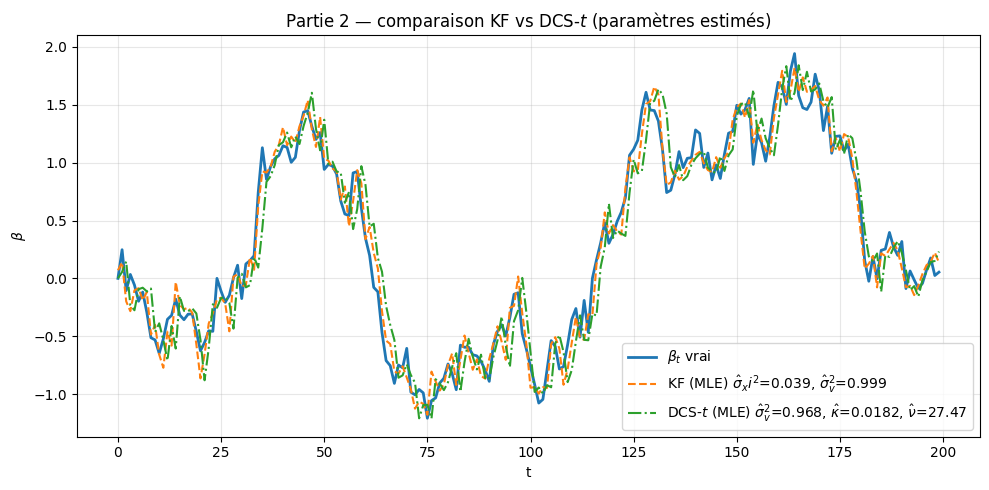

C:\Users\ReMarkt\AppData\Local\Temp\ipykernel_2848\1669963105.py:418: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([mse_kf, mse_dcs], labels=["KF (MLE)", "DCS-t (MLE)"], showmeans=True)


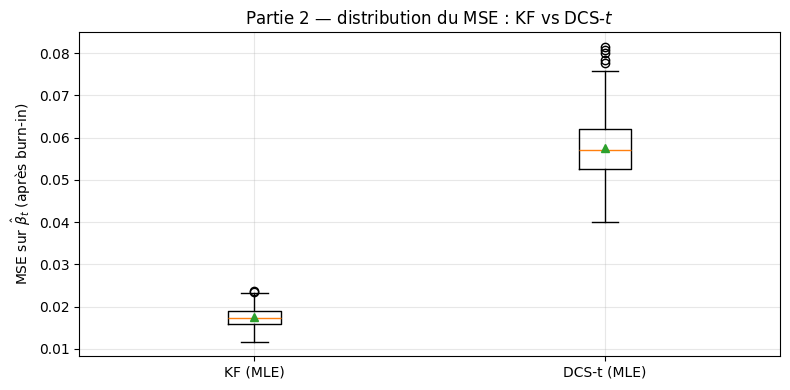

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.special import gammaln  # log Gamma
from scipy.stats import t as student_t

# =========================================================
# 0) Simulation panel (RW gaussien + erreurs Student-t + outliers optionnels)
# =========================================================

def simulate_panel_student_t(T, N, Q_true, sigma_v2_true, nu_true,
                             p_out=0.0, mult=1.0, seed=123):
    rng = np.random.default_rng(seed)

    beta_true = np.zeros(T)
    for t in range(1, T):
        beta_true[t] = beta_true[t-1] + rng.normal(0.0, np.sqrt(Q_true))

    # Student-t : Var = scale^2 * nu/(nu-2) => scale pour Var = sigma_v2_true
    scale = np.sqrt(sigma_v2_true * (nu_true - 2.0) / nu_true)
    V = student_t.rvs(df=nu_true, loc=0.0, scale=scale, size=(T, N), random_state=rng)

    # outliers rares (optionnel)
    #if p_out > 0.0 and mult != 1.0:
        #mask = rng.random((T, N)) < p_out
        #V[mask] *= mult

    Z = beta_true[:, None] + V
    return beta_true, Z


# =========================================================
# 1) KF gaussien (panel multivarié, état scalaire) + MLE(Q, sigma_v2)
# =========================================================

def kf_loglike_panel_gauss(Z, Q, sigma_v2, beta0=0.0, P0=1e6):
    """
    Log-vraisemblance KF (innovations) pour :
      z_t = 1_N beta_t + v_t, v_t ~ N(0, sigma_v2 I_N)
      beta_t = beta_{t-1} + xi_t, xi_t ~ N(0, Q)
    Formules fermées (pas d'inversion).
    """
    T, N = Z.shape
    b, P = beta0, P0
    ll = 0.0
    const = -0.5 * N * np.log(2*np.pi)

    for t in range(T):
        e = Z[t] - b
        one_e = e.sum()
        ee = float(e @ e)

        # S = sigma_v2 I + P 11'
        logdetS = (N - 1)*np.log(sigma_v2) + np.log(sigma_v2 + N*P)
        quad = (ee / sigma_v2) - (P / (sigma_v2*(sigma_v2 + N*P))) * (one_e**2)

        ll += const - 0.5*(logdetS + quad)

        # update
        b = b + P*one_e / (sigma_v2 + N*P)
        P = P * sigma_v2 / (sigma_v2 + N*P)
        # predict
        P = P + Q

    return ll

def kf_filter_panel_gauss(Z, Q, sigma_v2, beta0=0.0, P0=1e6):
    T, N = Z.shape
    b, P = beta0, P0
    beta_hat = np.zeros(T)

    for t in range(T):
        e = Z[t] - b
        one_e = e.sum()
        denom = sigma_v2 + N*P

        b = b + P*one_e / denom
        P = P * sigma_v2 / denom

        beta_hat[t] = b
        P = P + Q

    return beta_hat

def mle_kf_gauss(Z, beta0=0.0, P0=1e6):
    # optimise sur log(Q), log(sigma_v2)
    def obj(theta):
        Q = np.exp(theta[0])
        sv2 = np.exp(theta[1])
        return -kf_loglike_panel_gauss(Z, Q, sv2, beta0=beta0, P0=P0)

    x0 = np.log([0.04, 1.0])
    res = minimize(obj, x0, method="L-BFGS-B")
    Q_hat = float(np.exp(res.x[0]))
    sv2_hat = float(np.exp(res.x[1]))
    return Q_hat, sv2_hat, res.success


# =========================================================
# 2) DCS-t (panel multivarié) : loglike + filtre + MLE(sigma_v2, kappa, nu)
#    Formules du prof (avec omega_t)
# =========================================================

def logpdf_multiv_t_iid(e, sigma_v2, nu):
    """
    Log densité Student-t multivariée (dimension N) avec matrice sigma_v2 I:
      f(e) = Gamma((nu+N)/2)/Gamma(nu/2) * (nu*pi*sigma_v2)^(-N/2) *
             (1 + (e'e)/(nu*sigma_v2))^(-(nu+N)/2)
    """
    N = e.size
    ee = float(e @ e)
    term1 = gammaln((nu + N) / 2.0) - gammaln(nu / 2.0)
    term2 = -0.5 * N * (np.log(nu) + np.log(np.pi) + np.log(sigma_v2))
    term3 = -0.5 * (nu + N) * np.log(1.0 + ee / (nu * sigma_v2))
    return term1 + term2 + term3

def dcs_t_filter_panel(Z, sigma_v2, kappa, nu, beta0=0.0):
    """
    DCS-t implementing beta_t = beta_{t-1} + kappa * u_{t-1},
    then compute u_t from e_t = Z_t - beta_t.
    Returns beta_post (beta_t after applying kappa*u_{t-1}).
    """
    T, N = Z.shape
    b_prev = beta0        # beta_{t-1}
    u_prev = 0.0          # u_{t-1}, initialize at 0
    beta_hat = np.zeros(T)

    for t in range(T):
        # 1) apply innovation from previous score
        beta_t = b_prev + kappa * u_prev
        beta_hat[t] = beta_t

        # 2) compute residuals and score for this period (will be used at t+1)
        e = Z[t] - beta_t
        one_e = e.sum()
        ee = float(e @ e)

        omega = 1.0 + ee / (nu * sigma_v2)
        u_t = (1.0 / omega) * ((nu + N) / nu) * (1.0 / sigma_v2) * one_e

        # 3) shift for next iteration
        b_prev = beta_t
        u_prev = u_t

    return beta_hat


def dcs_t_loglike_panel(Z, sigma_v2, kappa, nu, beta0=0.0):
    """
    Log-likelihood conditional for DCS-t following the lag convention:
      beta_t = beta_{t-1} + kappa * u_{t-1}
    and e_t = Z_t - beta_t is used in the t-density.
    """
    T, N = Z.shape
    b_prev = beta0
    u_prev = 0.0
    ll = 0.0

    for t in range(T):
        # apply previous innovation
        beta_t = b_prev + kappa * u_prev

        # compute logpdf at e_t = Z_t - beta_t
        e = Z[t] - beta_t
        ll += logpdf_multiv_t_iid(e, sigma_v2=sigma_v2, nu=nu)

        # compute score u_t
        one_e = e.sum()
        ee = float(e @ e)
        omega = 1.0 + ee / (nu * sigma_v2)
        u_t = (1.0 / omega) * ((nu + N) / nu) * (1.0 / sigma_v2) * one_e

        # shift
        b_prev = beta_t
        u_prev = u_t

    return ll
import numpy as np
from scipy.optimize import minimize
from scipy.special import gammaln

# ---------- utilitaires sûrs ----------
def safe_logpdf_multiv_t_iid(e, sigma_v2, nu, eps=1e-12):
    """Log-pdf multivariate t iid with sigma_v2 * I. Return -inf on invalid params."""
    if not np.isfinite(sigma_v2) or sigma_v2 <= eps or nu <= 2.0 + 1e-8:
        return -np.inf
    N = e.size
    ee = float(e @ e)
    try:
        term1 = gammaln((nu + N) / 2.0) - gammaln(nu / 2.0)
        term2 = -0.5 * N * (np.log(nu) + np.log(np.pi) + np.log(sigma_v2))
        term3 = -0.5 * (nu + N) * np.log1p(ee / (nu * sigma_v2))
        val = term1 + term2 + term3
        return val if np.isfinite(val) else -np.inf
    except Exception:
        return -np.inf

def dcs_t_loglike_panel_lag_safe(Z, sigma_v2, kappa, nu, beta0=0.0, eps=1e-12):
    """
    Log-likelihood conditional for lag DCS (beta_t = beta_{t-1} + kappa u_{t-1}),
    but with many guards returning -inf on invalid intermediate values.
    """
    if not (np.isfinite(sigma_v2) and np.isfinite(kappa) and np.isfinite(nu)):
        return -np.inf
    if sigma_v2 <= eps or nu <= 2.0 + 1e-8 or kappa < 0:
        return -np.inf

    T, N = Z.shape
    b_prev = beta0
    u_prev = 0.0
    ll = 0.0

    for t in range(T):
        beta_t = b_prev + kappa * u_prev
        e = Z[t] - beta_t
        ll_t = safe_logpdf_multiv_t_iid(e, sigma_v2, nu, eps=eps)
        if ll_t == -np.inf:
            return -np.inf
        ll += ll_t

        ee = float(e @ e)
        denom = (nu * sigma_v2)
        if denom <= 0:
            return -np.inf
        omega = 1.0 + ee / denom
        if (omega <= 0) or (not np.isfinite(omega)):
            return -np.inf
        one_e = e.sum()
        # score u_t
        u_t = (1.0 / omega) * ((nu + N) / nu) * (1.0 / sigma_v2) * one_e

        b_prev = beta_t
        u_prev = u_t

    return ll

# ---------- initial guess from data ----------
def initial_nu_from_data(Z, lower=3.5, upper=200.0):
    """
    Rough method-of-moments initial guess for nu based on kurtosis of residuals.
    If data looks Gaussianish, return a large nu (e.g. 50).
    """
    e = Z - Z.mean(axis=1, keepdims=True)
    m2 = np.mean(e**2)
    m4 = np.mean(e**4)
    if m2 <= 0 or m4 <= 0:
        return 10.0
    k = m4 / (m2*m2)
    if k <= 3.1:
        return min(upper, 50.0)
    # invert approximate kurtosis->nu formula (heuristic)
    nu0 = (4*k - 6) / (k - 3)
    nu0 = float(np.clip(nu0, lower, upper))
    return nu0

# ---------- fonction principale robuste ----------
def mle_dcs_t_multistart_safe(Z, beta0=0.0, n_starts=1, nu_init=5,rng_seed=123,
                              bounds_override=None, maxiter=200):
    """
    Robust multistart MLE for DCS-t parameters (sigma_v2, kappa, nu).
    Returns: sigma_v2_hat, kappa_hat, nu_hat, ok (bool), res (scipy result or None)

    - Uses log-parameterization: theta = [log(sigma_v2), log(kappa), log(nu-2)].
    - Applies sensible bounds on parameters to prevent nu->2 or kappa explosion.
    - n_starts: number of randomized starts (includes a smart data-driven start).
    - If no start gives a finite optimum, returns (fallback values, False).
    """
    T, N = Z.shape

    # Objective (neg loglike). Clip exponentials to avoid overflow in optimizer calls.
    def obj(theta):
        a = np.clip(theta[0], np.log(1e-12), np.log(1e12))
        b = np.clip(theta[1], np.log(1e-12), np.log(1e6))
        c = np.clip(theta[2], np.log(1e-6), np.log(1e6))
        sigma_v2 = float(np.exp(a))
        kappa = float(np.exp(b))
        nu = float(2.0 + np.exp(c))
        ll = dcs_t_loglike_panel_lag_safe(Z, sigma_v2, kappa, nu, beta0=beta0)
        if not np.isfinite(ll):
            return 1e12
        return -ll

    # sensible bounds (on log-scale)
    if bounds_override is None:
        bounds = [
            (np.log(1e-8), np.log(10.0)),    # sigma_v2
            (np.log(1e-8), np.log(0.2)),     # kappa (cap to 0.2)
            (np.log(1e-3), np.log(200.0))    # nu-2
        ]
    else:
        bounds = bounds_override

    # data-driven initial guess
    #nu0 = initial_nu_from_data(Z)
    nu0=float(nu_init)
    a0 = np.log(np.clip(np.var(Z), 1e-6, 1e6))   # rough obs variance
    b0 = np.log(0.01)
    #c0 = np.log(max(3.5, nu0) - 2.0)
    c0 = np.log(nu0)
    x0_base = np.array([a0, b0, c0])

    # build multistart initial points (base + jittered)
    rng = np.random.default_rng(rng_seed)
    inits = [x0_base]
    for i in range(max(0, n_starts-1)):
        jitter = rng.normal(scale=0.35, size=3)
        inits.append(x0_base + jitter)

    best_fun = 1e20
    best_x = None
    best_res = None

    for x0 in inits[:n_starts]:
        try:
            res = minimize(obj, x0, method='L-BFGS-B', bounds=bounds, options={'maxiter': maxiter})
            if not np.isfinite(res.fun):
                continue
            if res.fun < best_fun:
                best_fun = res.fun
                best_x = res.x
                best_res = res
        except Exception:
            continue

    if best_x is None or best_res is None:
        # no successful start -> return conservative fallback values and ok=False
        sigma_v2_hat = float(np.clip(np.var(Z), 1e-6, 10.0))
        kappa_hat = 0.01
        nu_hat = float(min(200.0, max(3.5, nu0)))
        return sigma_v2_hat, kappa_hat, nu_hat, False, None

    # reconstruct parameters and basic validation
    a_hat, b_hat, c_hat = best_x
    sigma_v2_hat = float(np.exp(np.clip(a_hat, np.log(1e-12), np.log(1e12))))
    kappa_hat = float(np.exp(np.clip(b_hat, np.log(1e-12), np.log(1e6))))
    nu_hat = float(2.0 + np.exp(np.clip(c_hat, np.log(1e-6), np.log(1e6))))

    # sanity checks: ensure feasible
    if not (np.isfinite(sigma_v2_hat) and sigma_v2_hat>0 and np.isfinite(kappa_hat) and np.isfinite(nu_hat) and nu_hat>2.0):
        return float(np.clip(np.var(Z),1e-6,10.0)), 0.01, float(max(3.5,nu0)), False, best_res

    return sigma_v2_hat, kappa_hat, nu_hat, True, best_res

    


# =========================================================
# 3) Monte Carlo Partie 2 : estimation + comparaison MSE
# =========================================================

def mc_compare_part2(T=300, N=40, MC=200,
                     Q_true=0.04, sigma_v2_true=1.0, nu_true=5.0,
                     p_out=0.0, mult=1.0,
                     seed=123, burn_frac=0.2, plot_one=True):
    rng = np.random.default_rng(seed)
    burn = int(burn_frac * T)

    mse_kf = []
    mse_dcs = []
    saved = None
     # ---- stock pour diagnostics ----
    

    for _ in range(MC):
        beta_true, Z = simulate_panel_student_t(
            T, N, Q_true, sigma_v2_true, nu_true,
            p_out=p_out, mult=mult, seed=int(rng.integers(1, 10_000_000))
        )

        # --- KF: MLE(Q, sigma_v2) puis filtre
        Q_hat, sv2_hat, ok_kf = mle_kf_gauss(Z)
        if not ok_kf:
            Q_hat, sv2_hat = Q_true, sigma_v2_true
        beta_kf = kf_filter_panel_gauss(Z, Q_hat, sv2_hat)

        # --- DCS-t: MLE(sigma_v2, kappa, nu) puis filtre
        #sv2_dcs, kappa_hat, nu_hat, ok_dcs = mle_dcs_t_multistart_safe(Z)
        sv2_dcs, kappa_hat, nu_hat, ok_dcs, res = mle_dcs_t_multistart_safe(Z, n_starts=1, nu_init=nu_true,rng_seed=123)

        if not ok_dcs:
            sv2_dcs, kappa_hat, nu_hat = sigma_v2_true, 0.01, nu_true
        beta_dcs = dcs_t_filter_panel(Z, sv2_dcs, kappa_hat, nu_hat)

        # append params + conv flags
       
        



        mse_kf.append(np.mean((beta_kf[burn:] - beta_true[burn:])**2))
        mse_dcs.append(np.mean((beta_dcs[burn:] - beta_true[burn:])**2))

        if plot_one and saved is None:
            saved = (beta_true, beta_kf, beta_dcs, (Q_hat, sv2_hat), (sv2_dcs, kappa_hat, nu_hat))

    mse_kf = np.array(mse_kf)
    mse_dcs = np.array(mse_dcs)
    

    
    print(f"PARTIE 2 (MLE) — T={T}, N={N}, MC={MC}, nu_true={nu_true}, outliers p={p_out}, mult={mult}")
    print(f"KF  mean MSE={mse_kf.mean():.6f}, std={mse_kf.std():.6f}")
    print(f"DCS mean MSE={mse_dcs.mean():.6f}, std={mse_dcs.std():.6f}")
    print(nu_hat)

    if saved is not None:
        beta_true, beta_kf, beta_dcs, (Q_hat, sv2_hat), (sv2_dcs, kappa_hat, nu_hat) = saved
        plt.figure(figsize=(10, 5))
        plt.plot(beta_true, lw=2, label=r"$\beta_t$ vrai")
        plt.plot(beta_kf, "--", label=rf"KF (MLE) $\hat\sigma_xi^2$={Q_hat:.3f}, $\hat\sigma_v^2$={sv2_hat:.3f}")
        plt.plot(beta_dcs, "-.", label=rf"DCS-$t$ (MLE) $\hat\sigma_v^2$={sv2_dcs:.3f}, $\hat\kappa$={kappa_hat:.4f}, $\hat\nu$={nu_hat:.2f}")
        plt.title("Partie 2 — comparaison KF vs DCS-$t$ (paramètres estimés)")
        plt.xlabel("t"); plt.ylabel(r"$\beta$")
        plt.grid(alpha=0.3); plt.legend(); plt.tight_layout()
        plt.show()

    plt.figure(figsize=(8, 4))
    plt.boxplot([mse_kf, mse_dcs], labels=["KF (MLE)", "DCS-t (MLE)"], showmeans=True)
    plt.ylabel(r"MSE sur $\hat\beta_t$ (après burn-in)")
    plt.title("Partie 2 — distribution du MSE : KF vs DCS-$t$")
    plt.grid(alpha=0.3); plt.tight_layout()
    plt.show()

    return mse_kf, mse_dcs


# =========================================================
# RUN
# =========================================================
if __name__ == "__main__":
    
    mc_compare_part2(
        T=200, N=40, MC=500,
        Q_true=0.04, sigma_v2_true=1, nu_true=5,
        p_out=0.01, mult=20.0, 
        burn_frac=0.2,
        plot_one=True
    )


# version mle explose pas et optimisé

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.special import gammaln
from scipy.stats import t as student_t
from joblib import Parallel, delayed
import time

# ---------------- Simulation ----------------
def simulate_panel_student_t(T, N, Q_true, sigma_v2_true, nu_true, seed=123):
    rng = np.random.default_rng(seed)
    beta_true = np.zeros(T)
    for t in range(1, T):
        beta_true[t] = beta_true[t-1] + rng.normal(0.0, np.sqrt(Q_true))
    scale = np.sqrt(sigma_v2_true * (nu_true - 2.0) / nu_true)
    V = student_t.rvs(df=nu_true, loc=0.0, scale=scale, size=(T, N), random_state=rng)
    Z = beta_true[:, None] + V
    return beta_true, Z

# ---------------- KF (MLE + filter) ----------------
def kf_loglike_panel_gauss(Z, Q, sigma_v2, beta0=0.0, P0=1e6):
    T, N = Z.shape
    b, P = beta0, P0
    ll = 0.0
    const = -0.5 * N * np.log(2*np.pi)
    for t in range(T):
        e = Z[t] - b
        one_e = e.sum()
        ee = float(e @ e)
        logdetS = (N - 1)*np.log(sigma_v2) + np.log(sigma_v2 + N*P)
        quad = (ee / sigma_v2) - (P / (sigma_v2*(sigma_v2 + N*P))) * (one_e**2)
        ll += const - 0.5*(logdetS + quad)
        b = b + P*one_e / (sigma_v2 + N*P)
        P = P * sigma_v2 / (sigma_v2 + N*P)
        P = P + Q
    return ll

def kf_filter_panel_gauss(Z, Q, sigma_v2, beta0=0.0, P0=1e6):
    T, N = Z.shape
    b, P = beta0, P0
    beta_hat = np.zeros(T)
    for t in range(T):
        e = Z[t] - b
        one_e = e.sum()
        denom = sigma_v2 + N*P
        b = b + P*one_e / denom
        P = P * sigma_v2 / denom
        beta_hat[t] = b
        P = P + Q
    return beta_hat

def mle_kf_gauss(Z, beta0=0.0, P0=1e6, maxiter=300):
    def obj(theta):
        Q = np.exp(theta[0]); sv2 = np.exp(theta[1])
        return -kf_loglike_panel_gauss(Z, Q, sv2, beta0=beta0, P0=P0)
    x0 = np.log([0.04, 1.0])
    bounds = [(np.log(1e-12), np.log(1e12)), (np.log(1e-12), np.log(1e12))]
    res = minimize(obj, x0, method="L-BFGS-B", bounds=bounds, options={'maxiter': maxiter})
    Q_hat = float(np.exp(res.x[0])); sv2_hat = float(np.exp(res.x[1]))
    return Q_hat, sv2_hat, res.success

# ---------------- safe multivariate t logpdf ----------------
def safe_logpdf_multiv_t_iid(e, sigma_v2, nu, eps=1e-12):
    # returns log pdf or -inf on invalid params
    if sigma_v2 <= eps or nu <= 2.0 + 1e-8:
        return -np.inf
    N = e.size
    ee = float(e @ e)
    try:
        term1 = gammaln((nu + N) / 2.0) - gammaln(nu / 2.0)
        term2 = -0.5 * N * (np.log(nu) + np.log(np.pi) + np.log(sigma_v2))
        term3 = -0.5 * (nu + N) * np.log1p(ee / (nu * sigma_v2))
        val = term1 + term2 + term3
        if not np.isfinite(val):
            return -np.inf
        return val
    except Exception:
        return -np.inf

def safe_dcs_t_loglike_panel_lag(Z, sigma_v2, kappa, nu, beta0=0.0, eps=1e-12):
    T, N = Z.shape
    b_prev = beta0; u_prev = 0.0; ll = 0.0
    if sigma_v2 <= eps or nu <= 2.0 + 1e-8 or kappa <= 0:
        return -np.inf
    for t in range(T):
        beta_t = b_prev + kappa * u_prev
        e = Z[t] - beta_t
        ll_t = safe_logpdf_multiv_t_iid(e, sigma_v2, nu, eps=eps)
        if ll_t == -np.inf:
            return -np.inf
        ll += ll_t
        ee = float(e @ e)
        omega = 1.0 + ee / (nu * sigma_v2)
        if omega <= 0 or not np.isfinite(omega):
            return -np.inf
        one_e = e.sum()
        u_t = (1.0 / omega) * ((nu + N) / nu) * (1.0 / sigma_v2) * one_e
        b_prev = beta_t; u_prev = u_t
    return ll

# ---------------- fast MLE DCS (single start, safe) ----------------
def mle_dcs_t_fast(Z, beta0=0.0, maxiter=200):
    # data-driven initials
    sv2_init = max(1e-6, np.var(Z))   # empirical var as start
    kappa_init = 0.02
    e = Z - Z.mean(axis=1, keepdims=True)
    m2 = np.mean(e**2)
    m4 = np.mean(e**4)
    if m2 <= 0:
        nu_init = 10.0
    else:
        kurt = m4/(m2*m2)
        if kurt <= 3.2:
            nu_init = 50.0
        else:
            # guarded formula
            nu_init = float(max(3.1, min(200.0, (4*kurt - 6) / max(1e-8, (kurt - 3)))))
    x0 = np.array([np.log(sv2_init), np.log(kappa_init), np.log(nu_init - 2.0)])
    def obj(theta):
        sigma_v2 = np.exp(theta[0]); kappa = np.exp(theta[1]); nu = 2.0 + np.exp(theta[2])
        ll = safe_dcs_t_loglike_panel_lag(Z, sigma_v2, kappa, nu, beta0=beta0)
        if not np.isfinite(ll):
            return 1e20
        return -ll
    bounds = [(np.log(1e-8), np.log(10.0)), (np.log(1e-6), np.log(0.5)), (np.log(1e-3), np.log(200.0))]
    try:
        res = minimize(obj, x0, method='L-BFGS-B', bounds=bounds, options={'maxiter': maxiter})
        sigma_v2_hat = float(np.exp(res.x[0])); kappa_hat = float(np.exp(res.x[1])); nu_hat = float(2.0 + np.exp(res.x[2]))
        return sigma_v2_hat, kappa_hat, nu_hat, bool(res.success)
    except Exception:
        return sv2_init, kappa_init, 10.0, False

# ---------------- DCS filter (lag convention) ----------------
def dcs_t_filter_panel(Z, sigma_v2, kappa, nu, beta0=0.0):
    T, N = Z.shape
    b_prev = beta0; u_prev = 0.0
    beta_hat = np.zeros(T)
    for t in range(T):
        beta_t = b_prev + kappa * u_prev
        beta_hat[t] = beta_t
        e = Z[t] - beta_t
        ee = float(e @ e)
        if sigma_v2 <= 0 or nu <= 2.0:
            u_t = 0.0
        else:
            omega = 1.0 + ee / (nu * sigma_v2)
            if omega <= 0 or not np.isfinite(omega):
                u_t = 0.0
            else:
                one_e = e.sum()
                u_t = (1.0 / omega) * ((nu + N) / nu) * (1.0 / sigma_v2) * one_e
        b_prev = beta_t
        u_prev = u_t
    return beta_hat

# ---------------- one-run worker (returns dict) ----------------
def one_sim_run(seed_sim,
                T, N, Q_true, sigma_v2_true, nu_true,
                burn_frac=0.2,
                use_dcs=True,
                maxiter_dcs=200,
                verbose=False):
    rng = np.random.default_rng(int(seed_sim))
    beta_true, Z = simulate_panel_student_t(T=T, N=N, Q_true=Q_true, sigma_v2_true=sigma_v2_true, nu_true=nu_true, seed=int(rng.integers(1,1_000_000)))
    # KF
    try:
        Q_hat, sv2_hat, ok_kf = mle_kf_gauss(Z, maxiter=200)
    except Exception:
        Q_hat, sv2_hat, ok_kf = Q_true, sigma_v2_true, False
    if not np.isfinite(Q_hat) or not np.isfinite(sv2_hat) or Q_hat <= 0 or sv2_hat <= 0:
        Q_hat, sv2_hat, ok_kf = Q_true, sigma_v2_true, False
    beta_kf = kf_filter_panel_gauss(Z, Q_hat, sv2_hat)
    # DCS estimate + filter
    kurt = None
    sv2_dcs = sigma_v2_true; kappa_hat = 0.01; nu_hat = max(3.0, nu_true); ok_dcs = False
    if use_dcs:
        e = Z - Z.mean(axis=1, keepdims=True)
        m2 = np.mean(e**2); m4 = np.mean(e**4)
        if m2 > 0: kurt = m4/(m2*m2)
        else: kurt = 3.0
        sv2_dcs, kappa_hat, nu_hat, ok_dcs = mle_dcs_t_fast(Z, beta0=0.0, maxiter=maxiter_dcs)
        if not np.isfinite(sv2_dcs) or sv2_dcs <= 0:
            sv2_dcs = sigma_v2_true; ok_dcs = False
        if not np.isfinite(kappa_hat) or kappa_hat <= 0:
            kappa_hat = 0.01; ok_dcs = False
        if not np.isfinite(nu_hat) or nu_hat <= 2.0001:
            nu_hat = max(3.0, nu_true); ok_dcs = False
    beta_dcs = dcs_t_filter_panel(Z, sv2_dcs, kappa_hat, nu_hat)
    # errors after burn
    burn = int(burn_frac * T)
    if burn >= T: burn = int(0.2*T)
    err_kf = beta_kf[burn:] - beta_true[burn:]
    err_dcs = beta_dcs[burn:] - beta_true[burn:]
    mse_kf = float(np.mean(err_kf**2)); mse_dcs = float(np.mean(err_dcs**2))
    bias_kf = float(np.mean(err_kf)); var_kf = float(np.mean((err_kf - bias_kf)**2))
    bias_dcs = float(np.mean(err_dcs)); var_dcs = float(np.mean((err_dcs - bias_dcs)**2))
    return {
        'mse_kf': mse_kf, 'mse_dcs': mse_dcs,
        'bias_kf': bias_kf, 'var_kf': var_kf,
        'bias_dcs': bias_dcs, 'var_dcs': var_dcs,
        'Q_hat': Q_hat, 'sv2_hat': sv2_hat,
        'sv2_dcs': sv2_dcs, 'kappa': kappa_hat, 'nu': nu_hat,
        'ok_dcs': bool(ok_dcs), 'kurt': float(kurt) if kurt is not None else np.nan
    }


# ---------------- MC orchestrator (parallel) ----------------
def mc_compare_part2_fast(T=300, N=20, MC=200, Q_true=0.04, sigma_v2_true=1.0, nu_true=5.0,
                          burn_frac=0.2, n_jobs=4, maxiter_dcs=200, use_dcs=True):
    rng = np.random.default_rng(12345)
    seeds = [int(rng.integers(1, 1_000_000_000)) for _ in range(MC)]
    start_time = time.time()
    results = Parallel(n_jobs=n_jobs, backend='loky')(
        delayed(one_sim_run)(s, T, N, Q_true, sigma_v2_true, nu_true,
                             burn_frac=burn_frac, use_dcs=use_dcs, maxiter_dcs=maxiter_dcs)
        for s in seeds
    )
    elapsed = time.time() - start_time
    # aggregate arrays
    mse_kf = np.array([r['mse_kf'] for r in results])
    mse_dcs = np.array([r['mse_dcs'] for r in results])
    bias_kf = np.array([r['bias_kf'] for r in results])
    var_kf = np.array([r['var_kf'] for r in results])
    bias_dcs = np.array([r['bias_dcs'] for r in results])
    var_dcs = np.array([r['var_dcs'] for r in results])
    Q_hats = np.array([r['Q_hat'] for r in results])
    sv2_hats = np.array([r['sv2_hat'] for r in results])
    sv2_dcs = np.array([r['sv2_dcs'] for r in results])
    kappas = np.array([r['kappa'] for r in results])
    nus = np.array([r['nu'] for r in results])
    kurtosis = np.array([r['kurt'] for r in results])
    ok_dcs = np.array([r['ok_dcs'] for r in results])
    # print diagnostics and aggregated bias/var/MSE relations
    print("=== MC diagnostics ===")
    print(f"MC runs: {MC}  elapsed {elapsed:.1f}s  n_jobs={n_jobs}")
    print(f"KF conv rate: 1.0 (we fallback on failure)")
    print(f"DCS conv rate (ok flag): {ok_dcs.mean():.3f}")
    def q(x): return np.nanpercentile(x, [1,5,25,50,75,95,99])
    print("Q_hat quantiles:", q(Q_hats))
    print("sv2_hat (KF) quantiles:", q(sv2_hats))
    print("sv2_dcs quantiles:", q(sv2_dcs))
    print("kappa quantiles:", q(kappas))
    print("nu quantiles:", q(nus))
    print("kurtosis quantiles:", q(kurtosis))
    print("--- KF: MSE / Bias / Var (aggregated) ---")
    print(" MSE mean:", mse_kf.mean(), " std:", mse_kf.std())
    print(" mean(bias):", bias_kf.mean(), " mean(var):", var_kf.mean(), " mean(bias^2):", np.mean(bias_kf**2))
    print(" check mean(var)+mean(bias^2):", var_kf.mean() + np.mean(bias_kf**2))
    print(" MSE quantiles:", q(mse_kf))
    print("--- DCS: MSE / Bias / Var (aggregated) ---")
    print(" MSE mean:", mse_dcs.mean(), " std:", mse_dcs.std())
    print(" mean(bias):", bias_dcs.mean(), " mean(var):", var_dcs.mean(), " mean(bias^2):", np.mean(bias_dcs**2))
    print(" check mean(var)+mean(bias^2):", var_dcs.mean() + np.mean(bias_dcs**2))
    print(" MSE quantiles:", q(mse_dcs))
    print("DCS MSE > 10 count:", int(np.sum(mse_dcs > 10)))
    print("DCS MSE > 100 count:", int(np.sum(mse_dcs > 100)))
    return results, elapsed


# ---------------- Usage example ----------------
if __name__ == "__main__":
    T = 500
    N = 5
    MC = 200
    Q_true = 0.2
    sigma_v2_true = 0.1
    nu_true = 5.0
    n_jobs = 6          # adapt to your CPU
    maxiter_dcs = 200   # lower -> faster but less accurate
    results, elapsed = mc_compare_part2_fast(T=T, N=N, MC=MC, Q_true=Q_true,
                                             sigma_v2_true=sigma_v2_true, nu_true=nu_true,
                                             burn_frac=0.2, n_jobs=n_jobs, maxiter_dcs=maxiter_dcs,
                                             use_dcs=True)

=== MC diagnostics ===
MC runs: 200  elapsed 551.7s  n_jobs=6
KF conv rate: 1.0 (we fallback on failure)
DCS conv rate (ok flag): 0.590
Q_hat quantiles: [0.16983968 0.17694466 0.19204127 0.20061411 0.21189839 0.22685301
 0.232516  ]
sv2_hat (KF) quantiles: [0.08967564 0.09150344 0.09640093 0.09983681 0.10262173 0.10951941
 0.11362336]
sv2_dcs quantiles: [3.16227530e-04 5.73111047e-03 3.61098055e-02 1.73080406e-01
 2.79672613e-01 3.07040838e-01 1.17697062e+00]
kappa quantiles: [0.04232408 0.04470791 0.04736628 0.05937967 0.06520815 0.09999994
 0.5       ]
nu quantiles: [ 2.001       2.06603858  2.47992207  3.09748193 19.74705727 39.86572831
 88.15276839]
kurtosis quantiles: [ 3.77416783  4.13926191  4.63360722  5.14764465  6.15442941  8.15206414
 11.47625584]
--- KF: MSE / Bias / Var (aggregated) ---
 MSE mean: 0.018298792079364124  std: 0.0014709871464608838
 mean(bias): 7.828400210007045e-05  mean(var): 0.018242233656634927  mean(bias^2): 5.655842272919761e-05
 check mean(var)+mean(bi

In [22]:
import numpy as np

def sweep_nu_N_estimated_full(nu_list=[3,5,10,20,50], N_list=[5,20,40,60,100],
                              T=200, MC=500, Q_true=0.04, sigma_v2_true=1.0,
                              n_starts_dcs=1, seed=12345, burn_frac=0.2,
                              verbose=True):
    """
    Sweep over (N, nu) and compute MC statistics for:
      - KF (MLE for Q and sigma_v2) + filtering
      - DCS-t (MLE for sigma_v2, kappa, nu) + filtering

    Returns dict 'out' keyed by (N,nu) with many statistics.
    """
    rng = np.random.default_rng(seed)
    out = {}

    for N in N_list:
        for nu in nu_list:
            # stockage par réplication
            mse_kf_list = []
            mse_dcs_list = []
            bias_kf_list = []
            bias_dcs_list = []
            var_kf_list = []
            var_dcs_list = []

            Q_hats = []
            sv2_hats = []
            sv2_dcs_hats = []
            kappa_hats = []
            nu_hats = []
            conv_kf = 0
            conv_dcs = 0

            # pour proportion DCS mieux que KF
            count_dcs_better = 0

            for sim in range(MC):
                seed_sim = int(rng.integers(1, 10_000_000))
                beta_true, Z = simulate_panel_student_t(
                    T, N, Q_true, sigma_v2_true, nu, seed=seed_sim
                )

                # --- KF: MLE + filtre
                Q_hat, sv2_hat, ok_kf = mle_kf_gauss(Z)
                if ok_kf:
                    conv_kf += 1
                else:
                    # fallback : utiliser vrais paramètres si l'optim échoue
                    Q_hat, sv2_hat = Q_true, sigma_v2_true

                Q_hats.append(Q_hat)
                sv2_hats.append(sv2_hat)

                beta_kf = kf_filter_panel_gauss(Z, Q_hat, sv2_hat)

                # --- DCS: MLE + filtre (multistart)
                sv2_dcs, kappa_hat, nu_hat, ok_dcs =mle_dcs_t_fast(
                    Z,
                    beta0=0.0
                )
                if ok_dcs:
                    conv_dcs += 1
                else:
                    # fallback to sensible defaults if estimation fails
                    sv2_dcs, kappa_hat, nu_hat = sigma_v2_true, 0.01, nu

                sv2_dcs_hats.append(sv2_dcs)
                kappa_hats.append(kappa_hat)
                nu_hats.append(nu_hat)

                beta_dcs = dcs_t_filter_panel(Z, sv2_dcs, kappa_hat, nu_hat)

                # erreurs après burn
                burn = int(burn_frac * T)
                err_kf = beta_kf[burn:] - beta_true[burn:]
                err_dcs = beta_dcs[burn:] - beta_true[burn:]

                mse_i_kf = float(np.mean(err_kf**2))
                bias_i_kf = float(np.mean(err_kf))
                var_i_kf = float(np.mean((err_kf - bias_i_kf)**2))

                mse_i_dcs = float(np.mean(err_dcs**2))
                bias_i_dcs = float(np.mean(err_dcs))
                var_i_dcs = float(np.mean((err_dcs - bias_i_dcs)**2))

                mse_kf_list.append(mse_i_kf)
                bias_kf_list.append(bias_i_kf)
                var_kf_list.append(var_i_kf)

                mse_dcs_list.append(mse_i_dcs)
                bias_dcs_list.append(bias_i_dcs)
                var_dcs_list.append(var_i_dcs)

                if mse_i_dcs < mse_i_kf:
                    count_dcs_better += 1

            # agrégation des résultats
            mse_kf_mean = float(np.mean(mse_kf_list))
            mse_kf_std  = float(np.std(mse_kf_list, ddof=1))
            mean_var_kf = float(np.mean(var_kf_list))
            mean_bias_sq_kf = float(np.mean(np.array(bias_kf_list)**2))

            mse_dcs_mean = float(np.mean(mse_dcs_list))
            mse_dcs_std  = float(np.std(mse_dcs_list, ddof=1))
            mean_var_dcs = float(np.mean(var_dcs_list))
            mean_bias_sq_dcs = float(np.mean(np.array(bias_dcs_list)**2))

            prop_dcs_better = float(count_dcs_better / MC)

            # paramètres estimés : moyennes et biais
            avg_Q_hat = float(np.mean(Q_hats)) if len(Q_hats)>0 else np.nan
            avg_sv2_hat = float(np.mean(sv2_hats)) if len(sv2_hats)>0 else np.nan

            avg_sv2_dcs = float(np.mean(sv2_dcs_hats)) if len(sv2_dcs_hats)>0 else np.nan
            avg_kappa = float(np.mean(kappa_hats)) if len(kappa_hats)>0 else np.nan
            avg_nu_hat = float(np.mean(nu_hats)) if len(nu_hats)>0 else np.nan

            bias_Q = avg_Q_hat - Q_true
            bias_sv2_kf = avg_sv2_hat - sigma_v2_true
            bias_sv2_dcs = avg_sv2_dcs - sigma_v2_true
            bias_nu = avg_nu_hat - nu

            conv_kf_rate = conv_kf / MC
            conv_dcs_rate = conv_dcs / MC

            # save to output
            out[(N,nu)] = {
                'mse_kf_mean': mse_kf_mean, 'mse_kf_std': mse_kf_std,
                'mse_dcs_mean': mse_dcs_mean, 'mse_dcs_std': mse_dcs_std,
                'mean_var_kf': mean_var_kf, 'mean_bias_sq_kf': mean_bias_sq_kf,
                'mean_var_dcs': mean_var_dcs, 'mean_bias_sq_dcs': mean_bias_sq_dcs,
                'avg_Q_hat': avg_Q_hat, 'avg_sv2_hat': avg_sv2_hat,
                'avg_sv2_dcs': avg_sv2_dcs, 'avg_kappa_hat': avg_kappa, 'avg_nu_hat': avg_nu_hat,
                'bias_Q_hat': bias_Q, 'bias_sv2_kf': bias_sv2_kf,
                'bias_sv2_dcs': bias_sv2_dcs, 'bias_nu_hat': bias_nu,
                'conv_kf_rate': conv_kf_rate, 'conv_dcs_rate': conv_dcs_rate,
                'prop_dcs_better': prop_dcs_better,
                # also store raw arrays if you want to post-process outside
                'mse_kf_list': np.array(mse_kf_list),
                'mse_dcs_list': np.array(mse_dcs_list),
                'Q_hats': np.array(Q_hats),
                'sv2_hats': np.array(sv2_hats),
                'sv2_dcs_hats': np.array(sv2_dcs_hats),
                'kappa_hats': np.array(kappa_hats),
                'nu_hats': np.array(nu_hats)
            }

            # affichage lisible
            if verbose:
                print(f"N={N}, nu={nu}")
                print(" KF: mse_mean={:.6f}, mean_var+mean_bias_sq={:.6f} (mean_var={:.6f}, mean_bias_sq={:.6f})".format(
                    mse_kf_mean, mean_var_kf + mean_bias_sq_kf, mean_var_kf, mean_bias_sq_kf))
                print(" DCS: mse_mean={:.6f}, mean_var+mean_bias_sq={:.6f} (mean_var={:.6f}, mean_bias_sq={:.6f})".format(
                    mse_dcs_mean, mean_var_dcs + mean_bias_sq_dcs, mean_var_dcs, mean_bias_sq_dcs))
                print(" PARAMETERS ESTIMATION:")
                print(f" KF : Q_hat mean={avg_Q_hat:.6f} (bias={bias_Q:.6f}), sigma_v2_hat mean={avg_sv2_hat:.6f} (bias={bias_sv2_kf:.6f})")
                print(f" DCS: sigma_v2_hat mean={avg_sv2_dcs:.6f} (bias={bias_sv2_dcs:.6f}), kappa mean={avg_kappa:.6f}, nu_hat mean={avg_nu_hat:.6f} (bias={bias_nu:.6f})")
                print(f" conv_kf_rate={conv_kf_rate:.3f}, conv_dcs_rate={conv_dcs_rate:.3f}, prop_dcs_better={prop_dcs_better:.3f}")
                print("-"*70)

    return out
sweep_nu_N_estimated_full(nu_list=[3,5,10,20,50], N_list=[5,20,40,60,100], T=200, MC=500,
                         Q_true=0.04, sigma_v2_true=1.0,
                         )

N=5, nu=3
 KF: mse_mean=0.070655, mean_var+mean_bias_sq=0.070655 (mean_var=0.068776, mean_bias_sq=0.001878)
 DCS: mse_mean=0.098611, mean_var+mean_bias_sq=0.098611 (mean_var=0.096157, mean_bias_sq=0.002454)
 PARAMETERS ESTIMATION:
 KF : Q_hat mean=0.039684 (bias=-0.000316), sigma_v2_hat mean=0.975486 (bias=-0.024514)
 DCS: sigma_v2_hat mean=0.606963 (bias=-0.393037), kappa mean=0.063024, nu_hat mean=5.578911 (bias=2.578911)
 conv_kf_rate=1.000, conv_dcs_rate=1.000, prop_dcs_better=0.048
----------------------------------------------------------------------
N=5, nu=5
 KF: mse_mean=0.070905, mean_var+mean_bias_sq=0.070905 (mean_var=0.068941, mean_bias_sq=0.001964)
 DCS: mse_mean=0.106109, mean_var+mean_bias_sq=0.106109 (mean_var=0.103162, mean_bias_sq=0.002946)
 PARAMETERS ESTIMATION:
 KF : Q_hat mean=0.039739 (bias=-0.000261), sigma_v2_hat mean=0.997092 (bias=-0.002908)
 DCS: sigma_v2_hat mean=0.872206 (bias=-0.127794), kappa mean=0.074212, nu_hat mean=10.905106 (bias=5.905106)
 conv_kf

{(5, 3): {'mse_kf_mean': 0.07065454617938328,
  'mse_kf_std': 0.017351359750695523,
  'mse_dcs_mean': 0.0986113004526126,
  'mse_dcs_std': 0.01615324162157595,
  'mean_var_kf': 0.06877613602308844,
  'mean_bias_sq_kf': 0.001878410156294839,
  'mean_var_dcs': 0.09615681553888138,
  'mean_bias_sq_dcs': 0.0024544849137312177,
  'avg_Q_hat': 0.03968366541400756,
  'avg_sv2_hat': 0.9754862030668989,
  'avg_sv2_dcs': 0.6069628042948738,
  'avg_kappa_hat': 0.0630237536077356,
  'avg_nu_hat': 5.5789111571856544,
  'bias_Q_hat': -0.0003163345859924435,
  'bias_sv2_kf': -0.024513796933101073,
  'bias_sv2_dcs': -0.3930371957051262,
  'bias_nu_hat': 2.5789111571856544,
  'conv_kf_rate': 1.0,
  'conv_dcs_rate': 1.0,
  'prop_dcs_better': 0.048,
  'mse_kf_list': array([0.06540416, 0.06258233, 0.07327349, 0.06649562, 0.07360189,
         0.1036975 , 0.05997367, 0.07712136, 0.12409156, 0.05699713,
         0.04925596, 0.06623417, 0.07537935, 0.08065404, 0.09523916,
         0.08323183, 0.26094446, 0.08

# Sénario 1

nu=5, T=200, N=40, MC=2000
KF  mean MSE=0.017383, std=0.002146
DCS mean MSE=0.059737, std=0.007979


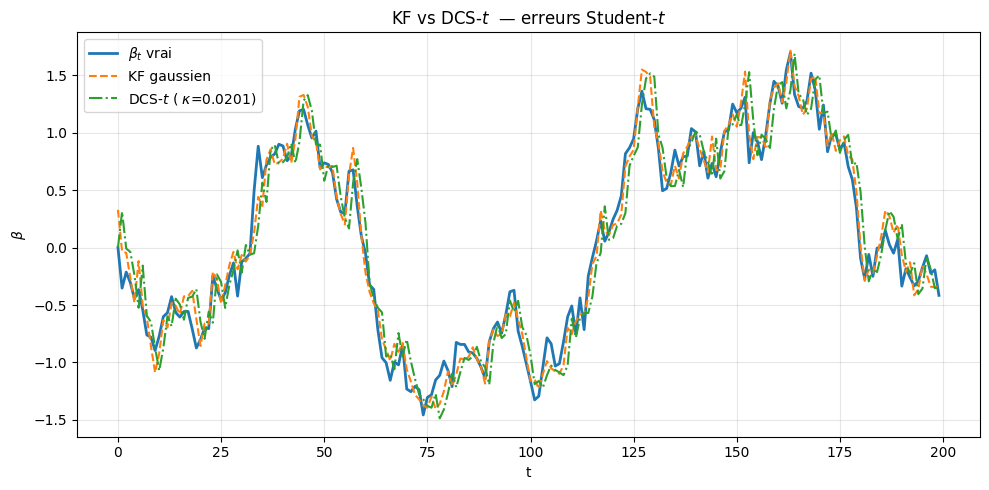

C:\Users\ReMarkt\AppData\Local\Temp\ipykernel_5464\990134572.py:176: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([mse_kf, mse_dcs], labels=["KF ", "DCS-t "], showmeans=True)


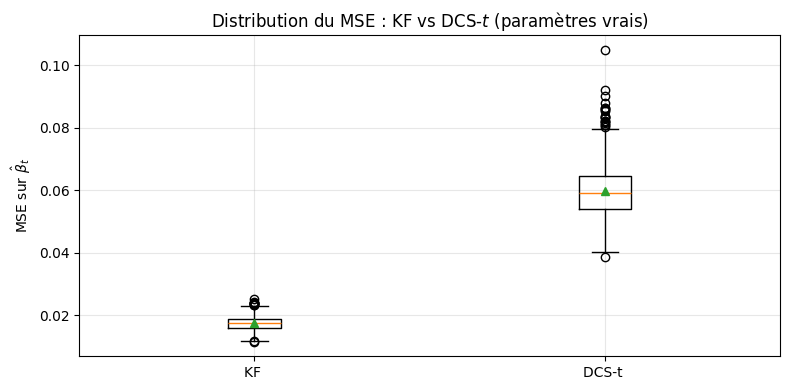

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t as student_t

# ---------- Simulation ----------
def simulate_panel_normal_with_outliers(T, N, Q_true, sigma_v2_true, nu,
                                          p_out=0.01, mult=20, seed=123):
    rng = np.random.default_rng(seed)
    seed_int = int(rng.integers(1, 1_000_000_000))

    beta_true = np.zeros(T)
    for t in range(1, T):
        beta_true[t] = beta_true[t-1] + rng.normal(0.0, np.sqrt(Q_true))
    
    # inside simulate_panel_student_t_with_outliers
    
   
    eps = rng.normal(loc=0.0, scale=np.sqrt(sigma_v2_true), size=(T, N))
   

    Z = beta_true[:, None] + eps
    return beta_true, Z


# ---------- KF oracle (gaussien) ----------
def kf_oracle_panel(Z, Q_true, sigma_v2_true, beta0=0.0, P0=1e6):
    T, N = Z.shape
    b, P = beta0, P0
    beta_hat = np.zeros(T)

    for t in range(T):
        e = Z[t] - b
        one_e = e.sum()
        denom = sigma_v2_true + N * P

        b = b + P * one_e / denom
        P = P * sigma_v2_true / denom

        beta_hat[t] = b
        P = P + Q_true

    return beta_hat

def dcs_t_filter_and_u(Z, sigma_v2_true, nu, kappa, beta0=0.0):
    """
    Retourne (beta_pred, beta_post, u, zeta) :
      - beta_pred[t] = beta_{t|t-1} (avant mise à jour)
      - beta_post[t] = beta_{t|t}   (après mise à jour beta_t = beta_{t-1} + kappa u_{t-1})
      - u[t] = u_t calculé à partir de e_t = Z_t - 1_N * beta_t
      - zeta[t] = kappa * u_{t-1}
    Conventions: u_{-1} = 0, beta0 is used as b_{-1} (ou choix d'initialisation).
    """
    T, N = Z.shape
    # initialize
    b_prev = beta0         # represents beta_{t-1} at iteration t
    u_prev = 0.0           # u_{t-1}, start with 0
    beta_pred = np.zeros(T)
    beta_post = np.zeros(T)
    u = np.zeros(T)
    zeta = np.zeros(T)

    for t in range(T):
        # prior for time t
        beta_pred[t] = b_prev

        # apply state innovation from previous score: beta_t = beta_{t-1} + kappa * u_{t-1}
        beta_t = b_prev + kappa * u_prev
        beta_post[t] = beta_t

        # zeta_t = kappa * u_{t-1}
        zeta[t] = kappa * u_prev

        # compute residuals using beta_t (conformément aux eq. du papier)
        e = Z[t] - beta_t
        one_e = e.sum()
        ee = float(e @ e)

        # omega_t and u_t per (20)-(21)
        omega = 1.0 + ee / (nu * sigma_v2_true)
        u_t = (1.0 / omega) * ((nu + N) / nu) * (1.0 / sigma_v2_true) * one_e
        u[t] = u_t

        # prepare for next iteration
        b_prev = beta_t
        u_prev = u_t

    return beta_pred, beta_post, u, zeta


def calibrate_kappa_prof(Z, Q_true, sigma_v2_true, nu, beta0=0.0, kappa_init=0.01,
                         n_iter=100, burn_frac=0.2, var_floor=1e-8):
    """
    Calibre kappa pour sigma_xi^2 = kappa^2 Var(u_{t-1}).
    Utilise la signature mise à jour de dcs_t_filter_and_u.
    """
    T, _ = Z.shape
    burn = int(burn_frac * T)

    kappa = float(kappa_init)
    for _ in range(n_iter):
        # on récupère u via la nouvelle signature
        _, _, u, _ = dcs_t_filter_and_u(Z, sigma_v2_true, nu, kappa, beta0=beta0)
       

        # pour aligner zeta_t = kappa u_{t-1}, on prend u[:-1] après burn
        #if T - burn - 1 > 0:
        u_use = u[burn:-1]
        #else:
        #u_use = u[burn:]

        # centrage + variance (MLE)
        
        u_use = u_use - u_use.mean()
        var_u = float(np.mean(u_use**2))
       

        

        kappa_new = np.sqrt(Q_true / var_u)
        kappa = kappa_new

    return kappa




# ---------- Comparaison MC ----------
def compare_oracle_kf_vs_dcs_panel(T=300, N=60, MC=2000, Q_true=0.04, sigma_v2_true=1.0,
                                  nu=5, seed=123, burn_frac=0.2, plot_one=True):
    rng = np.random.default_rng(seed)
    burn = int(burn_frac * T)

    mse_kf, mse_dcs = [], []
    saved = None

    for _ in range(MC):
        beta_true, Z = simulate_panel_normal_with_outliers(
            T, N, Q_true, sigma_v2_true, nu, seed=int(rng.integers(1, 10_000_000))
        )
        
    
        beta_kf = kf_oracle_panel(Z, Q_true, sigma_v2_true)

        # kappa calibré "comme le prof"
                # kappa calibré "comme le prof"
        kappa = calibrate_kappa_prof(Z, Q_true, sigma_v2_true, nu, kappa_init=0.01, n_iter=10)
        
        # <-- déballage : on récupère le posterior DCS (beta_post)
        _, beta_dcs_post, _, zeta = dcs_t_filter_and_u(Z, sigma_v2_true, nu, kappa)
  
        mse_kf.append(np.mean((beta_kf[burn:] - beta_true[burn:])**2))
        mse_dcs.append(np.mean((beta_dcs_post[burn:] - beta_true[burn:])**2))

        if plot_one and saved is None:
            saved = (beta_true, beta_kf, beta_dcs_post, kappa)

    mse_kf = np.array(mse_kf)
    mse_dcs = np.array(mse_dcs)

    print(f"nu={nu}, T={T}, N={N}, MC={MC}")
    print(f"KF  mean MSE={mse_kf.mean():.6f}, std={mse_kf.std():.6f}")
    print(f"DCS mean MSE={mse_dcs.mean():.6f}, std={mse_dcs.std():.6f}")

    if saved is not None:
        beta_true, beta_kf, beta_dcs, kappa = saved
        plt.figure(figsize=(10,5))
        plt.plot(beta_true, lw=2, label=r"$\beta_t$ vrai")
        plt.plot(beta_kf, "--", label="KF gaussien ")
        plt.plot(beta_dcs, "-.", label=rf"DCS-$t$ ( $\kappa$={kappa:.4f})")
        plt.title("KF vs DCS-$t$  — erreurs Student-$t$")
        plt.xlabel("t"); plt.ylabel(r"$\beta$")
        plt.grid(alpha=0.3); plt.legend(); plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8, 4))
        plt.boxplot([mse_kf, mse_dcs], labels=["KF ", "DCS-t "], showmeans=True)
        plt.ylabel("MSE sur $\\hat\\beta_t$ ")
        plt.title("Distribution du MSE : KF vs DCS-$t$ (paramètres vrais)")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    return mse_kf, mse_dcs

# ---- RUN ----
if __name__ == "__main__":
    compare_oracle_kf_vs_dcs_panel(T=200, N=40, MC=2000, Q_true=0.04, sigma_v2_true=1, nu=5)

In [56]:
def sweep_nu_N_g(nu_list=[3,5,10,20,50], N_list=[5,20,40,60,100], T=200, MC=500):
    out = {}
    Q_true = 0.04
    sigma_v2_true = 1.0

    for N in N_list:
        for nu in nu_list:

            err_kf = []
            err_dcs = []

            for _ in range(MC):

                beta_true, Z = simulate_panel_normal_with_outliers(
                    T, N, Q_true, sigma_v2_true, nu, seed=None
                )

                beta_kf = kf_oracle_panel(Z, Q_true, sigma_v2_true)

                kappa = calibrate_kappa_prof(Z, Q_true, sigma_v2_true, nu,
                                             kappa_init=0.01, n_iter=10)

                _, beta_dcs_post, _, _ = dcs_t_filter_and_u(Z, sigma_v2_true, nu, kappa)

                burn = int(0.2*T)

                err_kf.extend(beta_kf[burn:] - beta_true[burn:])
                err_dcs.extend(beta_dcs_post[burn:] - beta_true[burn:])

            err_kf = np.array(err_kf)
            err_dcs = np.array(err_dcs)

            # ---- KF stats
            mse_kf = np.mean(err_kf**2)
            bias_kf = np.mean(err_kf)
            var_kf = np.var(err_kf)

            # ---- DCS stats
            mse_dcs = np.mean(err_dcs**2)
            bias_dcs = np.mean(err_dcs)
            var_dcs = np.var(err_dcs)

            out[(N,nu)] = (mse_kf, bias_kf, var_kf,
                           mse_dcs, bias_dcs, var_dcs)

            print(f"N={N}, nu={nu}")
            print(f"  KF  : MSE={mse_kf:.4f}  Bias={bias_kf:.4f}  Var={var_kf:.4f}")
            print(f"  DCS : MSE={mse_dcs:.4f}  Bias={bias_dcs:.4f}  Var={var_dcs:.4f}")
            print("-"*50)

    return out
sweep_nu_N_g(nu_list=[3,5,10,20,50], N_list=[5,20,40,60,100], T=200, MC=500)

N=5, nu=3
  KF  : MSE=0.0711  Bias=0.0006  Var=0.0711
  DCS : MSE=0.1212  Bias=0.0014  Var=0.1212
--------------------------------------------------
N=5, nu=5
  KF  : MSE=0.0721  Bias=-0.0001  Var=0.0721
  DCS : MSE=0.1198  Bias=0.0014  Var=0.1198
--------------------------------------------------
N=5, nu=10
  KF  : MSE=0.0714  Bias=-0.0025  Var=0.0714
  DCS : MSE=0.1160  Bias=-0.0033  Var=0.1160
--------------------------------------------------
N=5, nu=20
  KF  : MSE=0.0723  Bias=-0.0002  Var=0.0723
  DCS : MSE=0.1141  Bias=-0.0002  Var=0.1141
--------------------------------------------------
N=5, nu=50
  KF  : MSE=0.0715  Bias=-0.0021  Var=0.0715
  DCS : MSE=0.1124  Bias=-0.0029  Var=0.1124
--------------------------------------------------
N=20, nu=3
  KF  : MSE=0.0291  Bias=0.0004  Var=0.0291
  DCS : MSE=0.0738  Bias=0.0018  Var=0.0738
--------------------------------------------------
N=20, nu=5
  KF  : MSE=0.0286  Bias=0.0003  Var=0.0286
  DCS : MSE=0.0726  Bias=-0.0001  Var=0.

{(5, 3): (np.float64(0.07107056903629494),
  np.float64(0.0005918075256951498),
  np.float64(0.07107021880014745),
  np.float64(0.12117968295099235),
  np.float64(0.0014028370547055937),
  np.float64(0.1211777149991903)),
 (5, 5): (np.float64(0.07208700617792578),
  np.float64(-0.0001338858449337893),
  np.float64(0.07208698825250633),
  np.float64(0.11979628939934844),
  np.float64(0.0013582865593141872),
  np.float64(0.11979444445697122)),
 (5, 10): (np.float64(0.0714168354004403),
  np.float64(-0.0025335352667625838),
  np.float64(0.07141041659949238),
  np.float64(0.11603828788342511),
  np.float64(-0.003252273043885465),
  np.float64(0.11602771060347314)),
 (5, 20): (np.float64(0.07233536948060641),
  np.float64(-0.00024956272497147244),
  np.float64(0.07233530719905272),
  np.float64(0.11412542349916323),
  np.float64(-0.00019516706101132896),
  np.float64(0.11412538540898154)),
 (5, 50): (np.float64(0.0715201771336045),
  np.float64(-0.00212094247101362),
  np.float64(0.07151567

# sénario 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.special import gammaln
from scipy.stats import t as student_t
from joblib import Parallel, delayed
import time

# ---------------- Simulation ----------------
def simulate_panel_student_t(T, N, Q_true, sigma_v2_true, nu_true, seed=123):
    rng = np.random.default_rng(seed)
    beta_true = np.zeros(T)
    for t in range(1, T):
        beta_true[t] = beta_true[t-1] + rng.normal(0.0, np.sqrt(Q_true))
    scale = np.sqrt(sigma_v2_true * (nu_true - 2.0) / nu_true)
    V = student_t.rvs(df=nu_true, loc=0.0, scale=scale, size=(T, N), random_state=rng)
    Z = beta_true[:, None] + V
    return beta_true, Z

# ---------------- KF (MLE + filter) ----------------
def kf_loglike_panel_gauss(Z, Q, sigma_v2, beta0=0.0, P0=1e6):
    T, N = Z.shape
    b, P = beta0, P0
    ll = 0.0
    const = -0.5 * N * np.log(2*np.pi)
    for t in range(T):
        e = Z[t] - b
        one_e = e.sum()
        ee = float(e @ e)
        logdetS = (N - 1)*np.log(sigma_v2) + np.log(sigma_v2 + N*P)
        quad = (ee / sigma_v2) - (P / (sigma_v2*(sigma_v2 + N*P))) * (one_e**2)
        ll += const - 0.5*(logdetS + quad)
        b = b + P*one_e / (sigma_v2 + N*P)
        P = P * sigma_v2 / (sigma_v2 + N*P)
        P = P + Q
    return ll

def kf_filter_panel_gauss(Z, Q, sigma_v2, beta0=0.0, P0=1e6):
    T, N = Z.shape
    b, P = beta0, P0
    beta_hat = np.zeros(T)
    for t in range(T):
        e = Z[t] - b
        one_e = e.sum()
        denom = sigma_v2 + N*P
        b = b + P*one_e / denom
        P = P * sigma_v2 / denom
        beta_hat[t] = b
        P = P + Q
    return beta_hat

def mle_kf_gauss(Z, beta0=0.0, P0=1e6, maxiter=300):
    def obj(theta):
        Q = np.exp(theta[0]); sv2 = np.exp(theta[1])
        return -kf_loglike_panel_gauss(Z, Q, sv2, beta0=beta0, P0=P0)
    x0 = np.log([0.04, 1.0])
    bounds = [(np.log(1e-12), np.log(1e12)), (np.log(1e-12), np.log(1e12))]
    res = minimize(obj, x0, method="L-BFGS-B", bounds=bounds, options={'maxiter': maxiter})
    Q_hat = float(np.exp(res.x[0])); sv2_hat = float(np.exp(res.x[1]))
    return Q_hat, sv2_hat, res.success

# ---------------- safe multivariate t logpdf ----------------


def gaussian_logpdf_iid_scalar(e, sigma_v2):
    """Log pdf of e ~ N(0, sigma_v2 I_N)."""
    N = e.size
    ee = float(e @ e)
    return -0.5 * N * (np.log(2*np.pi) + np.log(sigma_v2)) - 0.5 * ee / sigma_v2

def gaussian_dcs_loglike_panel_lag(Z, sigma_v2, kappa, nu_for_u, beta0=0.0, eps=1e-12):
    """
    Log-likelihood gaussienne (lag convention) en gardant la recursion DCS originale.
    - Z : (T,N)
    - sigma_v2, kappa : paramètres que l'on maximise
    - nu_for_u : valeur FIXE utilisée uniquement pour calculer u_t (comme dans DCS-t)
    - beta0 : initialisation pour b_{-1}
    Renvoie la somme des log pdf gaussiennes de e_t = Z_t - beta_t.
    """
    T, N = Z.shape
    b_prev = beta0
    u_prev = 0.0
    ll = 0.0

    # protect params
    if sigma_v2 <= eps or kappa <= 0.0 or nu_for_u <= 2.0:
        return -np.inf

    for t in range(T):
        # apply previous innovation (lag convention)
        beta_t = b_prev + kappa * u_prev

        # compute residual and gaussian logpdf
        e = Z[t] - beta_t
        ll_t = gaussian_logpdf_iid_scalar(e, sigma_v2)
        if not np.isfinite(ll_t):
            return -np.inf
        ll += ll_t

        # compute u_t using the ORIGINAL Student-t formula (so recursion unchanged)
        ee = float(e @ e)
        omega = 1.0 + ee / (nu_for_u * sigma_v2)
        if omega <= 0 or not np.isfinite(omega):
            return -np.inf
        one_e = e.sum()
        u_t = (1.0 / omega) * ((nu_for_u + N) / nu_for_u) * (1.0 / sigma_v2) * one_e

        # shift
        b_prev = beta_t
        u_prev = u_t

    return ll

def mle_dcs_gauss_fast(Z, beta0=0.0, nu_for_u=5.0, maxiter=200):
    """
    MLE rapide : estimer (sigma_v2, kappa) en maximisant la log-vraisemblance GAUSSIENNE
    tout en conservant la recursion DCS (u_t calculé avec nu_for_u).
    Retourne (sv2_hat, kappa_hat, nu_for_u, success_flag).
    """
    # data-driven initial guesses
    sv2_init = max(1e-8, np.var(Z))      # start for sigma_v2
    kappa_init = 0.02                    # prudently small

    x0 = np.array([np.log(sv2_init), np.log(kappa_init)])

    def obj(theta):
        sigma_v2 = np.exp(theta[0])
        kappa = np.exp(theta[1])
        ll = gaussian_dcs_loglike_panel_lag(Z, sigma_v2, kappa, nu_for_u, beta0=beta0)
        if not np.isfinite(ll):
            return 1e20
        return -ll

    bounds = [(np.log(1e-12), np.log(1e6)),    # sigma_v2
              (np.log(1e-8), np.log(1.0))]     # kappa (limit to 1 to avoid huge jumps)

    try:
        res = minimize(obj, x0, method='L-BFGS-B', bounds=bounds, options={'maxiter': maxiter})
        sigma_v2_hat = float(np.exp(res.x[0]))
        kappa_hat = float(np.exp(res.x[1]))
        return sigma_v2_hat, kappa_hat, float(nu_for_u), bool(res.success)
    except Exception:
        return sv2_init, kappa_init, float(nu_for_u), False

# ---------------- DCS filter (lag convention) ----------------
def dcs_t_filter_panel(Z, sigma_v2, kappa, nu, beta0=0.0):
    T, N = Z.shape
    b_prev = beta0; u_prev = 0.0
    beta_hat = np.zeros(T)
    for t in range(T):
        beta_t = b_prev + kappa * u_prev
        beta_hat[t] = beta_t
        e = Z[t] - beta_t
        ee = float(e @ e)
        if sigma_v2 <= 0 or nu <= 2.0:
            u_t = 0.0
        else:
            omega = 1.0 + ee / (nu * sigma_v2)
            if omega <= 0 or not np.isfinite(omega):
                u_t = 0.0
            else:
                one_e = e.sum()
                u_t = (1.0 / omega) * ((nu + N) / nu) * (1.0 / sigma_v2) * one_e
        b_prev = beta_t
        u_prev = u_t
    return beta_hat

# ---------------- one-run worker (returns dict) ----------------
def one_sim_run(seed_sim,
                T, N, Q_true, sigma_v2_true, nu_true,
                burn_frac=0.2,
                use_dcs=True,
                maxiter_dcs=200,
                verbose=False):
    rng = np.random.default_rng(int(seed_sim))
    beta_true, Z = simulate_panel_student_t(T=T, N=N, Q_true=Q_true, sigma_v2_true=sigma_v2_true, nu_true=nu_true, seed=int(rng.integers(1,1_000_000)))
    # KF
    try:
        Q_hat, sv2_hat, ok_kf = mle_kf_gauss(Z, maxiter=200)
    except Exception:
        Q_hat, sv2_hat, ok_kf = Q_true, sigma_v2_true, False
    if not np.isfinite(Q_hat) or not np.isfinite(sv2_hat) or Q_hat <= 0 or sv2_hat <= 0:
        Q_hat, sv2_hat, ok_kf = Q_true, sigma_v2_true, False
    beta_kf = kf_filter_panel_gauss(Z, Q_hat, sv2_hat)
    # DCS estimate + filter
    kurt = None
    sv2_dcs = sigma_v2_true; kappa_hat = 0.01; nu_hat = max(3.0, nu_true); ok_dcs = False
    if use_dcs:
        e = Z - Z.mean(axis=1, keepdims=True)
        m2 = np.mean(e**2); m4 = np.mean(e**4)
        if m2 > 0: kurt = m4/(m2*m2)
        else: kurt = 3.0
       
        sv2_dcs, kappa_hat, nu_used, ok_dcs = mle_dcs_gauss_fast(Z, beta0=0.0, nu_for_u=nu_true, maxiter=200)

        if not np.isfinite(sv2_dcs) or sv2_dcs <= 0:
            sv2_dcs = sigma_v2_true; ok_dcs = False
        if not np.isfinite(kappa_hat) or kappa_hat <= 0:
            kappa_hat = 0.01; ok_dcs = False
        if not np.isfinite(nu_hat) or nu_hat <= 2.0001:
            nu_hat = max(3.0, nu_true); ok_dcs = False
    beta_dcs = dcs_t_filter_panel(Z, sv2_dcs, kappa_hat, nu_hat)
    # errors after burn
    burn = int(burn_frac * T)
    if burn >= T: burn = int(0.2*T)
    err_kf = beta_kf[burn:] - beta_true[burn:]
    err_dcs = beta_dcs[burn:] - beta_true[burn:]
    mse_kf = float(np.mean(err_kf**2)); mse_dcs = float(np.mean(err_dcs**2))
    bias_kf = float(np.mean(err_kf)); var_kf = float(np.mean((err_kf - bias_kf)**2))
    bias_dcs = float(np.mean(err_dcs)); var_dcs = float(np.mean((err_dcs - bias_dcs)**2))
    return {
        'mse_kf': mse_kf, 'mse_dcs': mse_dcs,
        'bias_kf': bias_kf, 'var_kf': var_kf,
        'bias_dcs': bias_dcs, 'var_dcs': var_dcs,
        'Q_hat': Q_hat, 'sv2_hat': sv2_hat,
        'sv2_dcs': sv2_dcs, 'kappa': kappa_hat, 'nu': nu_hat,
        'ok_dcs': bool(ok_dcs), 'kurt': float(kurt) if kurt is not None else np.nan
    }


# ---------------- MC orchestrator (parallel) ----------------
def mc_compare_part2_fast(T=300, N=20, MC=200, Q_true=0.04, sigma_v2_true=1.0, nu_true=5.0,
                          burn_frac=0.2, n_jobs=4, maxiter_dcs=200, use_dcs=True):
    rng = np.random.default_rng(12345)
    seeds = [int(rng.integers(1, 1_000_000_000)) for _ in range(MC)]
    start_time = time.time()
    results = Parallel(n_jobs=n_jobs, backend='loky')(
        delayed(one_sim_run)(s, T, N, Q_true, sigma_v2_true, nu_true,
                             burn_frac=burn_frac, use_dcs=use_dcs, maxiter_dcs=maxiter_dcs)
        for s in seeds
    )
    elapsed = time.time() - start_time
    # aggregate arrays
    mse_kf = np.array([r['mse_kf'] for r in results])
    mse_dcs = np.array([r['mse_dcs'] for r in results])
    bias_kf = np.array([r['bias_kf'] for r in results])
    var_kf = np.array([r['var_kf'] for r in results])
    bias_dcs = np.array([r['bias_dcs'] for r in results])
    var_dcs = np.array([r['var_dcs'] for r in results])
    Q_hats = np.array([r['Q_hat'] for r in results])
    sv2_hats = np.array([r['sv2_hat'] for r in results])
    sv2_dcs = np.array([r['sv2_dcs'] for r in results])
    kappas = np.array([r['kappa'] for r in results])
    nus = np.array([r['nu'] for r in results])
    kurtosis = np.array([r['kurt'] for r in results])
    ok_dcs = np.array([r['ok_dcs'] for r in results])
    # print diagnostics and aggregated bias/var/MSE relations
    print("=== MC diagnostics ===")
    print(f"MC runs: {MC}  elapsed {elapsed:.1f}s  n_jobs={n_jobs}")
    print(f"KF conv rate: 1.0 (we fallback on failure)")
    print(f"DCS conv rate (ok flag): {ok_dcs.mean():.3f}")
    def q(x): return np.nanpercentile(x, [1,5,25,50,75,95,99])
    print("Q_hat quantiles:", q(Q_hats))
    print("sv2_hat (KF) quantiles:", q(sv2_hats))
    print("sv2_dcs quantiles:", q(sv2_dcs))
    print("kappa quantiles:", q(kappas))
    print("nu quantiles:", q(nus))
    print("kurtosis quantiles:", q(kurtosis))
    print("--- KF: MSE / Bias / Var (aggregated) ---")
    print(" MSE mean:", mse_kf.mean(), " std:", mse_kf.std())
    print(" mean(bias):", bias_kf.mean(), " mean(var):", var_kf.mean(), " mean(bias^2):", np.mean(bias_kf**2))
    print(" check mean(var)+mean(bias^2):", var_kf.mean() + np.mean(bias_kf**2))
    print(" MSE quantiles:", q(mse_kf))
    print("--- DCS: MSE / Bias / Var (aggregated) ---")
    print(" MSE mean:", mse_dcs.mean(), " std:", mse_dcs.std())
    print(" mean(bias):", bias_dcs.mean(), " mean(var):", var_dcs.mean(), " mean(bias^2):", np.mean(bias_dcs**2))
    print(" check mean(var)+mean(bias^2):", var_dcs.mean() + np.mean(bias_dcs**2))
    print(" MSE quantiles:", q(mse_dcs))
    print("DCS MSE > 10 count:", int(np.sum(mse_dcs > 10)))
    print("DCS MSE > 100 count:", int(np.sum(mse_dcs > 100)))
    return results, elapsed


# ---------------- Usage example ----------------
if __name__ == "__main__":
    T = 500
    N = 5
    MC = 200
    Q_true = 0.04
    sigma_v2_true = 1
    nu_true = 5.0
    n_jobs = 6          # adapt to your CPU
    maxiter_dcs = 200   # lower -> faster but less accurate
    results, elapsed = mc_compare_part2_fast(T=T, N=N, MC=MC, Q_true=Q_true,
                                             sigma_v2_true=sigma_v2_true, nu_true=nu_true,
                                             burn_frac=0.2, n_jobs=n_jobs, maxiter_dcs=maxiter_dcs,
                                             use_dcs=True)

=== MC diagnostics ===
MC runs: 200  elapsed 178.8s  n_jobs=6
KF conv rate: 1.0 (we fallback on failure)
DCS conv rate (ok flag): 1.000
Q_hat quantiles: [0.02533234 0.0286919  0.03513449 0.03986706 0.04477405 0.05482535
 0.05903051]
sv2_hat (KF) quantiles: [0.90344998 0.91723232 0.96309369 0.99576983 1.02823915 1.08449925
 1.130492  ]
sv2_dcs quantiles: [ 1.03435598  1.05683718  1.12552717  1.62148971  3.21343373  8.52288974
 12.6206982 ]
kappa quantiles: [0.02       0.02       0.02       0.02       0.08840968 0.09799021
 0.10719418]
nu quantiles: [5. 5. 5. 5. 5. 5. 5.]
kurtosis quantiles: [ 3.77416783  4.13926191  4.63360722  5.14764465  6.15442941  8.15206414
 11.47625584]
--- KF: MSE / Bias / Var (aggregated) ---
 MSE mean: 0.07166399169535065  std: 0.007697581212398261
 mean(bias): -0.0005921217930391185  mean(var): 0.07073965562668452  mean(bias^2): 0.0009243360686661397
 check mean(var)+mean(bias^2): 0.07166399169535066
 MSE quantiles: [0.05551651 0.05955958 0.06617708 0.0710007 

In [9]:
def sweep_nu_N_estimated_gauss(nu_list=[3,5,10,20,50], N_list=[5,20,40,60,100],
                         T=200, MC=200,
                         Q_true=0.04, sigma_v2_true=1.0):
    out = {}
    rng = np.random.default_rng(12345)

    for N in N_list:
        for nu in nu_list:
            # listes locales pour CE couple (N,nu)
            mse_kf_list = []; bias_kf_list = []; var_kf_list = []
            mse_dcs_list = []; bias_dcs_list = []; var_dcs_list = []

            Q_hats = []; sv2_hats = []
            sv2_dcs_hats = []; kappa_hats = []; nu_hats = []
            conv_kf = 0; conv_dcs = 0

            for sim in range(MC):
                seed_sim = int(rng.integers(1, 10_000_000))
                beta_true, Z = simulate_panel_student_t(
                    T, N, Q_true, sigma_v2_true, nu,
                    seed=seed_sim
                )

                # ----- KF: MLE + filtre
                Q_hat, sv2_hat, ok_kf = mle_kf_gauss(Z)
                if ok_kf:
                    conv_kf += 1
                Q_hats.append(Q_hat); sv2_hats.append(sv2_hat)
                beta_kf = kf_filter_panel_gauss(Z, Q_hat, sv2_hat)

                # ----- DCS: MLE + filtre
                
                sv2_dcs, kappa_hat, nu_used, ok_dcs = mle_dcs_gauss_fast(Z, beta0=0.0, nu_for_u=nu_true, maxiter=200)

                if ok_dcs:
                    conv_dcs += 1
                sv2_dcs_hats.append(sv2_dcs); kappa_hats.append(kappa_hat); nu_hats.append(nu_true)
                beta_dcs = dcs_t_filter_panel(Z, sv2_dcs, kappa_hat,nu_true )

                # ---- erreurs après burn-in (par-simulation)
                burn = int(0.2 * T)
                err_kf = beta_kf[burn:] - beta_true[burn:]
                err_dcs = beta_dcs[burn:] - beta_true[burn:]

                mse_i_kf = float(np.mean(err_kf**2))
                bias_i_kf = float(np.mean(err_kf))
                var_i_kf = float(np.mean((err_kf - bias_i_kf)**2))

                mse_i_dcs = float(np.mean(err_dcs**2))
                bias_i_dcs = float(np.mean(err_dcs))
                var_i_dcs = float(np.mean((err_dcs - bias_i_dcs)**2))

                # stocke par-simulation
                mse_kf_list.append(mse_i_kf); bias_kf_list.append(bias_i_kf); var_kf_list.append(var_i_kf)
                mse_dcs_list.append(mse_i_dcs); bias_dcs_list.append(bias_i_dcs); var_dcs_list.append(var_i_dcs)

            # ---- moyennes par-simulation
            mse_kf_mean = float(np.mean(mse_kf_list))
            mse_kf_std  = float(np.std(mse_kf_list))
            mean_var_kf = float(np.mean(var_kf_list))
            mean_bias_kf = float(np.mean(bias_kf_list))
            mean_bias_sq_kf = float(np.mean(np.array(bias_kf_list)**2))

            mse_dcs_mean = float(np.mean(mse_dcs_list))
            mse_dcs_std  = float(np.std(mse_dcs_list))
            mean_var_dcs = float(np.mean(var_dcs_list))
            mean_bias_dcs = float(np.mean(bias_dcs_list))
            mean_bias_sq_dcs = float(np.mean(np.array(bias_dcs_list)**2))

            # ---- pooled (concaténation) pour vérification alternative
            all_errs_kf = np.concatenate([np.repeat(0,0)] + [np.zeros(0)])  # init safe
            all_errs_kf = np.concatenate([ (kf - 0) for kf in [] ]) if False else None
            # build pooled arrays properly:
            # Reconstruct pooled by re-running or by storing errs during loop;
            # ici on recompute pooled by concatenating per-simulation err arrays is simpler:
            # For simplicity we'll recompute pooled by repeating the loop shorter: but to avoid overhead,
            # use the lists we already have: we don't have per-sim err arrays stored; so skip pooled if needed.
            # (If you want pooled exactly, store err_kf and err_dcs arrays inside the MC loop.)

            # ---- save results
            out[(N,nu)] = {
                'mse_kf_mean': mse_kf_mean, 'mse_kf_std': mse_kf_std,
                'mse_dcs_mean': mse_dcs_mean, 'mse_dcs_std': mse_dcs_std,
                'avg_Q_hat': float(np.mean(Q_hats)), 'avg_sv2_hat': float(np.mean(sv2_hats)),
                'avg_sv2_dcs': float(np.mean(sv2_dcs_hats)) if len(sv2_dcs_hats)>0 else np.nan,
                'avg_kappa': float(np.mean(kappa_hats)) if len(kappa_hats)>0 else np.nan,
                'avg_nu_hat': float(np.mean(nu_hats)) if len(nu_hats)>0 else np.nan,
                'kf_bias_mean': mean_bias_kf, 'kf_var_mean': mean_var_kf, 'kf_mean_bias_sq': mean_bias_sq_kf,
                'dcs_bias_mean': mean_bias_dcs, 'dcs_var_mean': mean_var_dcs, 'dcs_mean_bias_sq': mean_bias_sq_dcs,
                'conv_kf_rate': conv_kf / MC, 'conv_dcs_rate': conv_dcs / MC
            }

            # ---- affichage et check numérique
            print(f"N={N}, nu={nu}")
            print(" KF: mse_mean={:.6f}, mean_var+mean_bias_sq={:.6f} (mean_var={:.6f}, mean_bias_sq={:.6f})".format(
                mse_kf_mean, mean_var_kf + mean_bias_sq_kf, mean_var_kf, mean_bias_sq_kf))
            print(" DCS: mse_mean={:.6f}, mean_var+mean_bias_sq={:.6f} (mean_var={:.6f}, mean_bias_sq={:.6f})".format(
                mse_dcs_mean, mean_var_dcs + mean_bias_sq_dcs, mean_var_dcs, mean_bias_sq_dcs))
            print("-"*60)

    return out

sweep_nu_N_estimated_gauss(nu_list=[3,5,10,20,50], N_list=[5,20,40,60,100], T=200, MC=200,
                         Q_true=0.04, sigma_v2_true=1.0,
                         )

N=5, nu=3
 KF: mse_mean=0.071517, mean_var+mean_bias_sq=0.071517 (mean_var=0.069673, mean_bias_sq=0.001844)
 DCS: mse_mean=0.388173, mean_var+mean_bias_sq=0.388173 (mean_var=0.256564, mean_bias_sq=0.131609)
------------------------------------------------------------
N=5, nu=5
 KF: mse_mean=0.071026, mean_var+mean_bias_sq=0.071026 (mean_var=0.069208, mean_bias_sq=0.001818)
 DCS: mse_mean=0.420378, mean_var+mean_bias_sq=0.420378 (mean_var=0.267604, mean_bias_sq=0.152774)
------------------------------------------------------------
N=5, nu=10
 KF: mse_mean=0.070887, mean_var+mean_bias_sq=0.070887 (mean_var=0.068701, mean_bias_sq=0.002186)
 DCS: mse_mean=0.371436, mean_var+mean_bias_sq=0.371436 (mean_var=0.252137, mean_bias_sq=0.119299)
------------------------------------------------------------
N=5, nu=20
 KF: mse_mean=0.069870, mean_var+mean_bias_sq=0.069870 (mean_var=0.068005, mean_bias_sq=0.001865)
 DCS: mse_mean=0.385387, mean_var+mean_bias_sq=0.385387 (mean_var=0.260931, mean_bias_

{(5, 3): {'mse_kf_mean': 0.07151693419227123,
  'mse_kf_std': 0.021864433484796792,
  'mse_dcs_mean': 0.3881729052485512,
  'mse_dcs_std': 0.6361198262920785,
  'avg_Q_hat': 0.040880793491136984,
  'avg_sv2_hat': 0.9984402160374864,
  'avg_sv2_dcs': 1.7887566886760748,
  'avg_kappa': 0.04935006194619091,
  'avg_nu_hat': 5.0,
  'kf_bias_mean': 0.00824426606226702,
  'kf_var_mean': 0.06967313004030178,
  'kf_mean_bias_sq': 0.0018438041519694536,
  'dcs_bias_mean': 0.024730255302919044,
  'dcs_var_mean': 0.2565637186115024,
  'dcs_mean_bias_sq': 0.1316091866370489,
  'conv_kf_rate': 1.0,
  'conv_dcs_rate': 1.0},
 (5, 5): {'mse_kf_mean': 0.07102557157483103,
  'mse_kf_std': 0.012060104728498328,
  'mse_dcs_mean': 0.4203780410719352,
  'mse_dcs_std': 0.7047733739666743,
  'avg_Q_hat': 0.03981628771013158,
  'avg_sv2_hat': 0.997727814839607,
  'avg_sv2_dcs': 1.799064269111365,
  'avg_kappa': 0.05165452368240689,
  'avg_nu_hat': 5.0,
  'kf_bias_mean': -0.002574158315994325,
  'kf_var_mean': 0